## Personalized Treatment Recommendation

### In this project, we intend to analyse the dataset and identify factors that lead to cardiovascular disease amongst the average person. Using our findings, we will then try to recommend a personalized treatment in order for them to reduce their risks of getting them.

In [82]:
# --- Importing Libraries ---
import pandas as pd
import numpy as np
import seaborn as sb
import warnings
import os
import yellowbrick
import pickle
import textwrap
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC, ConfusionMatrix
from yellowbrick.style import set_palette
from yellowbrick.model_selection import LearningCurve, FeatureImportances
from yellowbrick.contrib.wrapper import wrap
from matplotlib.collections import PathCollection
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from yellowbrick.datasets import load_spam


# --- Libraries Settings ---
pd.set_option("display.precision", 4)
warnings.filterwarnings('ignore')
sb.set_style('whitegrid')
plt.rcParams['figure.dpi']=100
set_palette('dark')

## Things that we did to clean up the dataset in the CSV

- Removed ID count as it was not neccessary
 
- Modified age to be counted in terms of years instead of days to make it easier to deduce their age


- Modified Height from cm to m, allowing it be utilised for medical formulas
  
- Added in 3 medical formulas for BMI (utilising body weight and height), MAP (utilising systolic blood pressure and diastolic blood pressure), and PP (utilising systolic blood pressure (SBP) and diastolic blood pressure (DBP))

- Body Mass Index (BMI= Weight in kg / (Height in m)^2)
is a measure of body fat based on your weight in relation to your height. It helps categorise individuals as follows:
    
    Underweight: Less than 18.5

    Normal weight: 18.5 to 24.9

    Overweight: 25 to 29.9

    Obesity: 30 or more

- Mean Arterial Pressure (MAP= (SBP+2×DBP)/3)
represents the average pressure in a person's arteries during one cardiac cycle. Usually used to assess organ perfusion (ie. whether organs receive adequate blood flow).It helps categorise individuals as follows:

    Low MAP: Less than 70mmHg

    Normal MAP: Between 70mmHg and 100mmHg

    High MAP: Greater than 100mmHg

- Pulse Pressure (PP=SBP−DB)
is the difference between systolic and diastolic blood pressure. It can indicate the health of your arteries and heart. Usually used to identify arterial stiffness (ie. the ability of the arteries to expand and contract with each heartbeat). It helps categorise individuals as follows:

    Low pulse pressure: Less than 40mmHg

    Normal pulse pressure: Between 40mmHg and 60mmHg

    High pulse pressure: Greater than 60mmHg



- Rounded off values to 2 decimal places for Age, BMI and MAP for ease of referencing data


In [2]:
healthData = pd.read_csv('../cardio_train.csv')
healthData.head()

,age (in years),height (in m),weight (in kg),bmi (body mass index),ap_hi (systolic blood pressure),ap_lo (diastolic blood pressure),map (mean arterial pressure),pp (pulse pressure),"cholesterol (1- normal, 2 - above normal, 3- well above normal)","gluc (1- normal, 2 - above normal, 3- well above normal)","gender( 1 for Women, 2 for Men)","smoke (0 - does not smoke, 1 - smokes)","alco (0 - does not alcohol, 1 - consumes alcohol)","active (0 - does not exercise, 1 - exercises)","cardio (0 - no cardiovascular disease, 1 -has cardiovascular disease)"
0,50.39,1.68,62.0,21.97,110,80,90.00,30,1,1,2,0,0,1,0
1,55.42,1.56,85.0,34.93,140,90,106.67,50,3,1,1,0,0,1,1
2,51.66,1.65,64.0,23.51,130,70,90.00,60,3,1,1,0,0,0,1
3,48.28,1.69,82.0,28.71,150,100,116.67,50,1,1,2,0,0,1,1
4,47.87,1.56,56.0,23.01,100,60,73.33,40,1,1,1,0,0,0,0


In [3]:
healthData.describe()

,age (in years),height (in m),weight (in kg),bmi (body mass index),ap_hi (systolic blood pressure),ap_lo (diastolic blood pressure),map (mean arterial pressure),pp (pulse pressure),"cholesterol (1- normal, 2 - above normal, 3- well above normal)","gluc (1- normal, 2 - above normal, 3- well above normal)","gender( 1 for Women, 2 for Men)","smoke (0 - does not smoke, 1 - smokes)","alco (0 - does not alcohol, 1 - consumes alcohol)","active (0 - does not exercise, 1 - exercises)","cardio (0 - no cardiovascular disease, 1 -has cardiovascular disease)"
count,70000.0000,70000.0000,70000.0000,70000.0000,70000.0000,70000.0000,70000.0000,70000.0000,70000.0000,70000.0000,70000.0000,70000.0000,70000.0000,70000.0000,70000.0000
mean,53.3393,1.6436,74.2057,27.5566,128.8173,96.6304,107.3584,32.1869,1.3669,1.2265,1.3496,0.0881,0.0538,0.8037,0.4997
std,6.7596,0.0821,14.3958,6.0914,154.0114,188.4725,136.4938,241.4696,0.6803,0.5723,0.4768,0.2835,0.2256,0.3972,0.5000
min,29.5800,0.5500,10.0000,3.4700,-150.0000,-70.0000,-41.6700,-10800.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000
25%,48.3900,1.5900,65.0000,23.8800,120.0000,80.0000,93.3300,40.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,0.0000
50%,53.9800,1.6500,72.0000,26.3750,120.0000,80.0000,93.3300,40.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,0.0000
75%,58.4300,1.7000,82.0000,30.2200,140.0000,90.0000,103.3300,50.0000,2.0000,1.0000,2.0000,0.0000,0.0000,1.0000,1.0000
max,64.9700,2.5000,200.0000,298.6700,16020.0000,11000.0000,7400.0000,15940.0000,3.0000,3.0000,2.0000,1.0000,1.0000,1.0000,1.0000


In [4]:
healthData.shape

(70000, 15)

In [5]:
healthData.dtypes

age (in years)                                                           float64
height (in m)                                                            float64
weight (in kg)                                                           float64
bmi (body mass index)                                                    float64
ap_hi (systolic blood pressure)                                            int64
ap_lo (diastolic blood pressure)                                           int64
map (mean arterial pressure)                                             float64
pp (pulse pressure)                                                        int64
cholesterol (1- normal, 2 - above normal, 3- well above normal)            int64
gluc (1- normal, 2 - above normal, 3- well above normal)                   int64
gender( 1 for Women, 2 for Men)                                            int64
smoke (0 - does not smoke, 1 - smokes)                                     int64
alco (0 - does not alcohol, 

## Exploratory Data Analysis and Further Data Cleaning (removing outliers)

### Systolic blood pressure and diastolic blood pressure, pulse pressure, and mean arterial pressure are supposed to be positive, medically speaking, for a living person. 


### As such, we will remove rows with non-positive values for these specified columns

In [6]:
# Identifying outliers with 0 or below
negative_ap_hi = healthData[healthData['ap_hi (systolic blood pressure)'] <= 0]
negative_ap_lo = healthData[healthData['ap_lo (diastolic blood pressure)'] <= 0]
negative_pp = healthData[healthData['pp (pulse pressure)'] <= 0]
negative_map = healthData[healthData['map (mean arterial pressure)'] <= 0]

negative_ap_hi_count = negative_ap_hi.shape[0]
negative_ap_lo_count = negative_ap_lo.shape[0]
negative_pp_count = negative_pp.shape[0]
negative_map_count = negative_map.shape[0]

# Getting unique rows across all categories
unique_negatives = pd.concat([negative_ap_hi, negative_ap_lo, negative_pp, negative_map]).drop_duplicates()
unique_negative_count = unique_negatives.shape[0]

# Print the counts before removing the outliers
print(f"Non-positive ap_hi count: {negative_ap_hi_count}")
print(f"Non-positive ap_lo count: {negative_ap_lo_count}")
print(f"Non-positive pulse pressure count: {negative_pp_count}")
print(f"Non-positive mean arterial pressure count: {negative_map_count}")
print(f"Total unique non-positive outlier count: {unique_negative_count}")

# Removing rows with 0 or below values in the specified columns
healthData = healthData[(healthData['ap_hi (systolic blood pressure)'] > 0) &
                        (healthData['ap_lo (diastolic blood pressure)'] > 0) &
                        (healthData['pp (pulse pressure)'] > 0) &
                        (healthData['map (mean arterial pressure)'] > 0)]

healthData.shape

Non-positive ap_hi count: 7
Non-positive ap_lo count: 22
Non-positive pulse pressure count: 1236
Non-positive mean arterial pressure count: 1
Total unique non-positive outlier count: 1258


(68742, 15)

## Age (in Years)
### Plot Boxplot, Histogram, and Violin plot

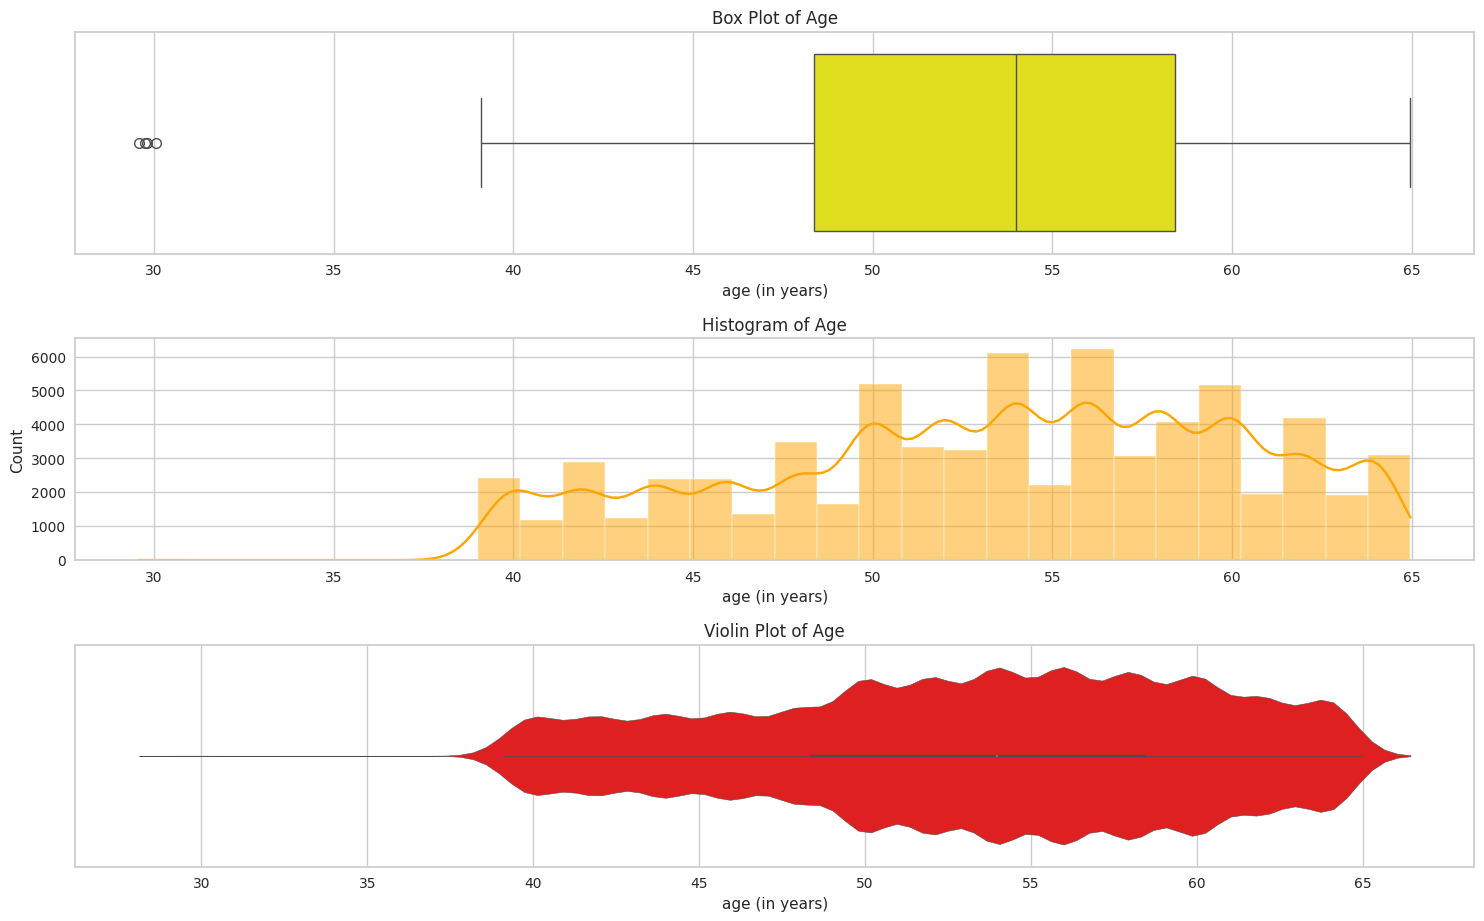

Boxplot Points for 'age (in years)':
Minimum Value (Lower Whisker): 33.32000000000001
Q1 (25th Percentile): 48.38
Median (50th Percentile): 53.98
Q3 (75th Percentile): 58.42
Maximum Value (Upper Whisker): 64.97

Outlier Counts for 'age (in years)':
Count of points below lower whisker: 4
Count of points above upper whisker: 0


In [7]:
# Creating box plot, histplot, and violin plot for 'age (in years)'
plt.figure(figsize=(15, 12))

plt.subplot(4, 1, 1)
sb.boxplot(x=healthData['age (in years)'], color='yellow')
plt.title('Box Plot of Age')

plt.subplot(4, 1, 2)
sb.histplot(healthData['age (in years)'], color='orange', kde=True, bins=30)
plt.title('Histogram of Age')

plt.subplot(4, 1, 3)
sb.violinplot(x=healthData['age (in years)'], color='red')
plt.title('Violin Plot of Age')

plt.tight_layout()
plt.show()

# Extracting statistical values for boxplot of 'age (in years)'
age_boxplot_stats = healthData['age (in years)'].describe()

# Calculating the necessary quartiles and IQR for boxplot:
q1 = age_boxplot_stats['25%']  # Q1 (25th percentile)
median = age_boxplot_stats['50%']  # Q2 (Median, 50th percentile)
q3 = age_boxplot_stats['75%']  # Q3 (75th percentile)

iqr = q3 - q1  # Interquartile Range (IQR)

lower_whisker = q1 - 1.5 * iqr  # Lower whisker boundary (without outliers)
upper_whisker = q3 + 1.5 * iqr  # Upper whisker boundary (without outliers)

# Printing the boxplot points
print("Boxplot Points for 'age (in years)':")
print(f"Minimum Value (Lower Whisker): {max(lower_whisker, healthData['age (in years)'].min())}")
print(f"Q1 (25th Percentile): {q1}")
print(f"Median (50th Percentile): {median}")
print(f"Q3 (75th Percentile): {q3}")
print(f"Maximum Value (Upper Whisker): {min(upper_whisker, healthData['age (in years)'].max())}")

# Counting outlier points below and above the lower and upper whisker
outliers_below = healthData[healthData['age (in years)'] < lower_whisker].shape[0]
outliers_above = healthData[healthData['age (in years)'] > upper_whisker].shape[0]

print("\nOutlier Counts for 'age (in years)':")
print(f"Count of points below lower whisker: {outliers_below}")
print(f"Count of points above upper whisker: {outliers_above}")

### Remove outliers as we focus on people aged 40 and above.
### Plot the updated Boxplot, Histogram, and Violin plot.


Data shape after removing outliers: (66986, 15)


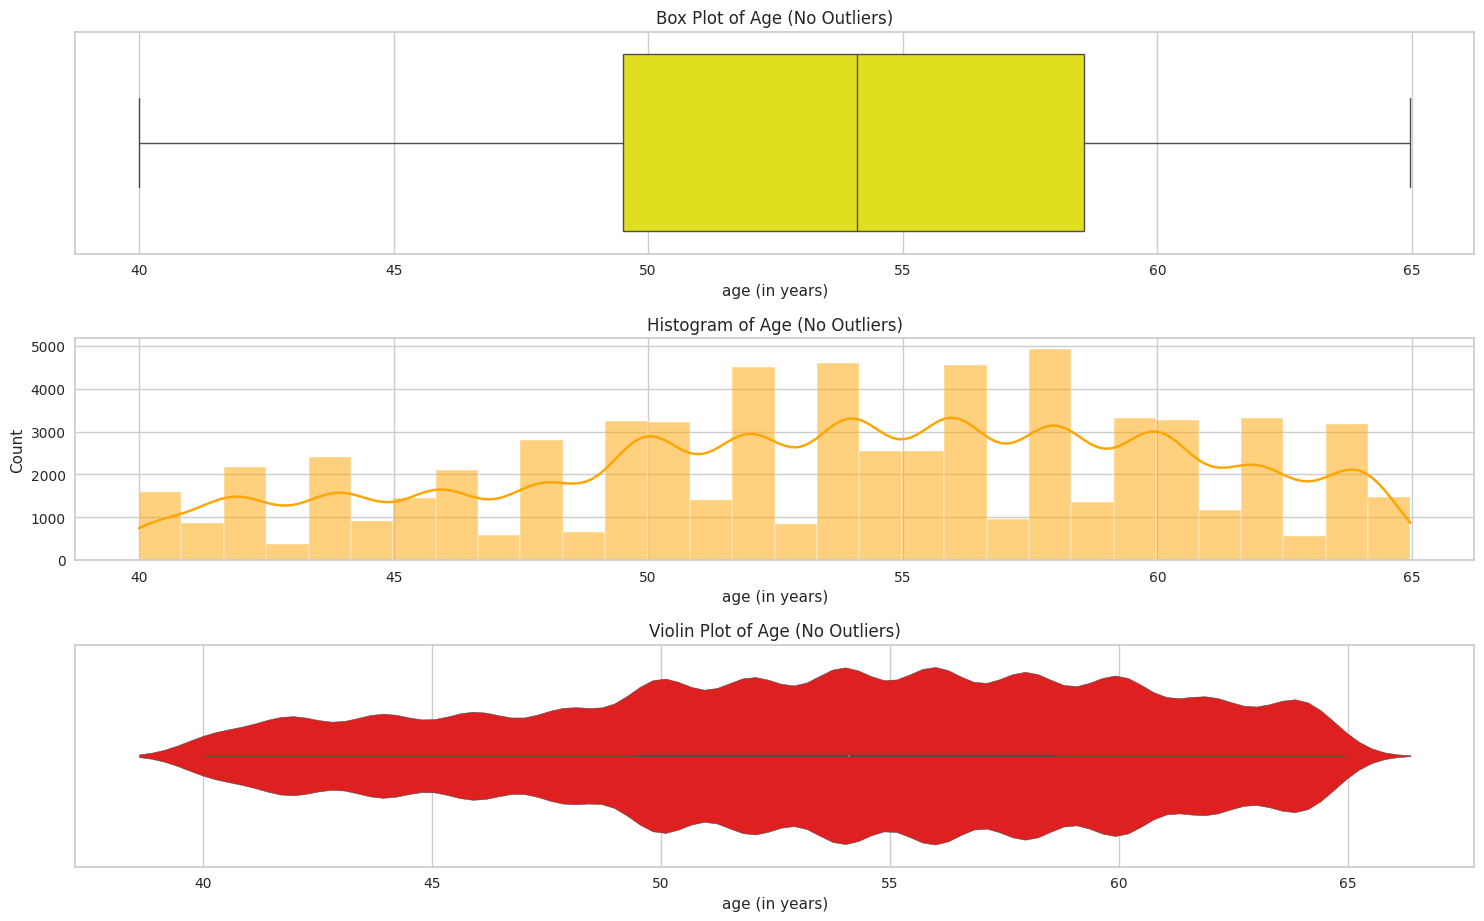

In [8]:
# 1. Permanently remove outliers
healthData = healthData[
    (healthData['age (in years)'] >= 40) &
    (healthData['age (in years)'] >= lower_whisker) &
    (healthData['age (in years)'] <= upper_whisker)
]
print(f"Data shape after removing outliers: {healthData.shape}")

# 2. Re-plot the updated dataset to confirm outliers are removed
plt.figure(figsize=(15, 12))

plt.subplot(4, 1, 1)
sb.boxplot(x=healthData['age (in years)'], color='yellow')
plt.title('Box Plot of Age (No Outliers)')

plt.subplot(4, 1, 2)
sb.histplot(healthData['age (in years)'], color='orange', kde=True, bins=30)
plt.title('Histogram of Age (No Outliers)')

plt.subplot(4, 1, 3)
sb.violinplot(x=healthData['age (in years)'], color='red')
plt.title('Violin Plot of Age (No Outliers)')

plt.tight_layout()
plt.show()



In [9]:
healthData.shape

(66986, 15)

## Height (in m)
### Plot Boxplot, Histogram, and Violin plot

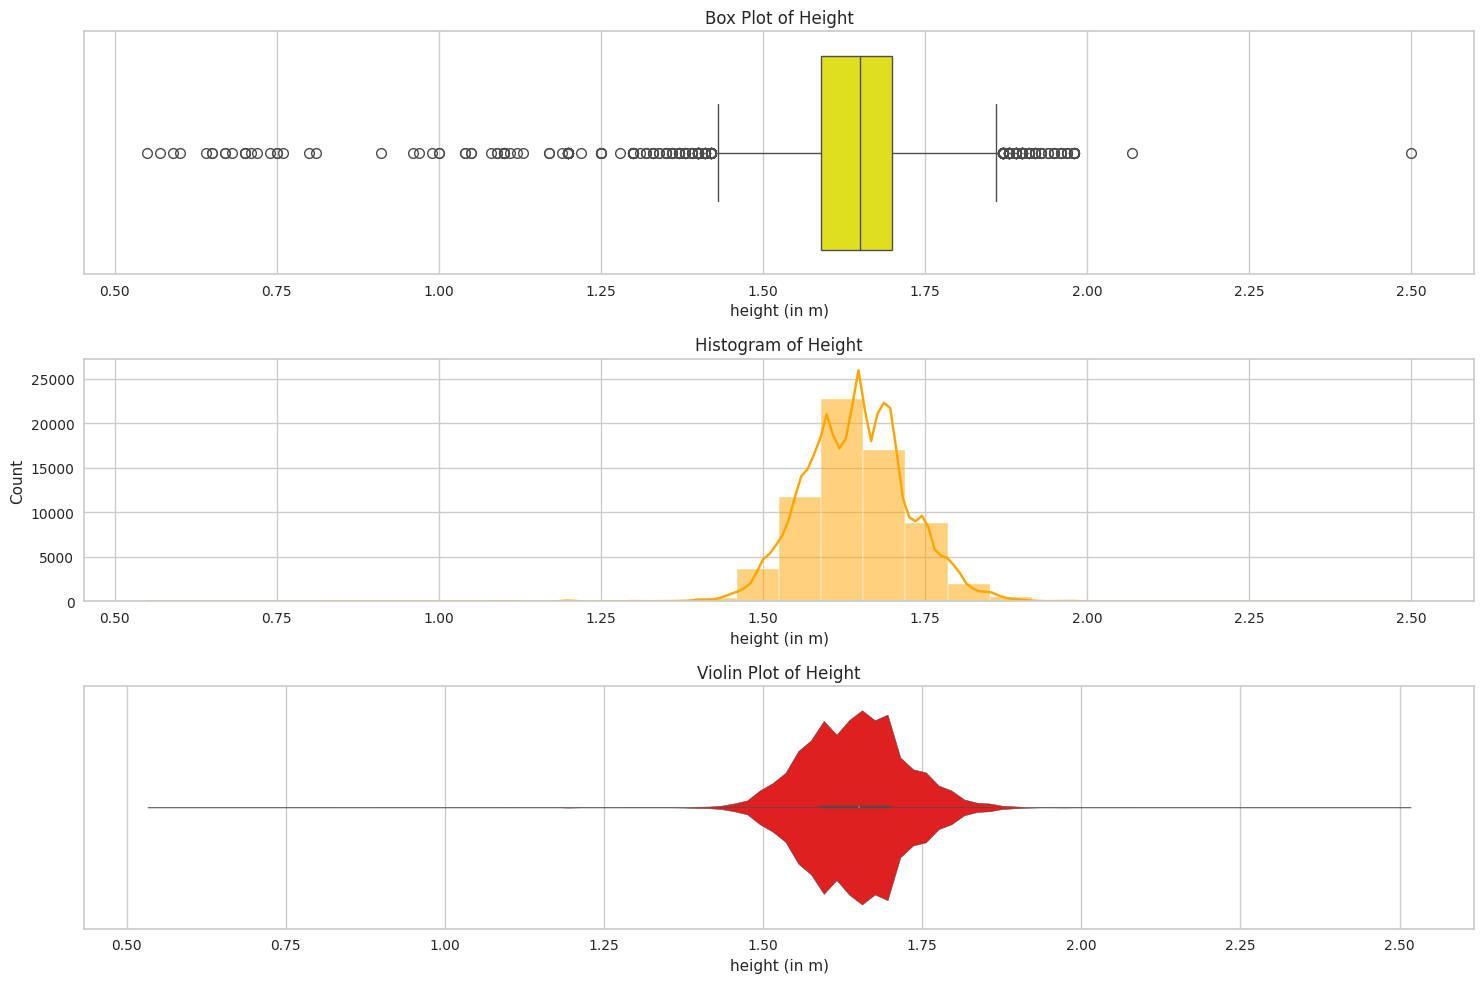

Boxplot Points for 'height (in m)':
Minimum Value (Lower Whisker): 1.4250000000000003
Q1 (25th Percentile): 1.59
Median (50th Percentile): 1.65
Q3 (75th Percentile): 1.7
Maximum Value (Upper Whisker): 1.8649999999999998

Outlier Counts for 'height (in m)'.:
Count of points below lower whisker: 234
Count of points above upper whisker: 253


In [10]:
# Creating box plot, histplot, and violin plot for 'height (in m)'
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
sb.boxplot(x=healthData['height (in m)'], color='yellow')
plt.title('Box Plot of Height')

plt.subplot(3, 1, 2)
sb.histplot(healthData['height (in m)'], color='orange', kde=True, bins=30)
plt.title('Histogram of Height')

plt.subplot(3, 1, 3)
sb.violinplot(x=healthData['height (in m)'], color='red')
plt.title('Violin Plot of Height')

plt.tight_layout()
plt.show()

# Extracting statistical values for boxplot of 'height (in m)'
height_boxplot_stats = healthData['height (in m)'].describe()

# Calculating the necessary quartiles and IQR for boxplot:
q1 = height_boxplot_stats['25%']  # Q1 (25th percentile)
median = height_boxplot_stats['50%']  # Q2 (Median, 50th percentile)
q3 = height_boxplot_stats['75%']  # Q3 (75th percentile)

iqr = q3 - q1  # Interquartile Range (IQR)

lower_whisker = q1 - 1.5 * iqr  # Lower whisker boundary (without outliers)
upper_whisker = q3 + 1.5 * iqr  # Upper whisker boundary (without outliers)

# Printing the boxplot points
print("Boxplot Points for 'height (in m)':")
print(f"Minimum Value (Lower Whisker): {max(lower_whisker, healthData['height (in m)'].min())}")
print(f"Q1 (25th Percentile): {q1}")
print(f"Median (50th Percentile): {median}")
print(f"Q3 (75th Percentile): {q3}")
print(f"Maximum Value (Upper Whisker): {min(upper_whisker, healthData['height (in m)'].max())}")

# Counting outlier points below and above the lower and upper whisker
outliers_below = healthData[healthData['height (in m)'] < lower_whisker].shape[0]
outliers_above = healthData[healthData['height (in m)'] > upper_whisker].shape[0]

print("\nOutlier Counts for 'height (in m)'.:")
print(f"Count of points below lower whisker: {outliers_below}")
print(f"Count of points above upper whisker: {outliers_above}")

### Remove outliers outside the lower and upper whiskers as our focus is on the average person. 
### Then, plot the updated Boxplot, Histogram, and Violin plot.

Shape after removing outliers: (66499, 15)


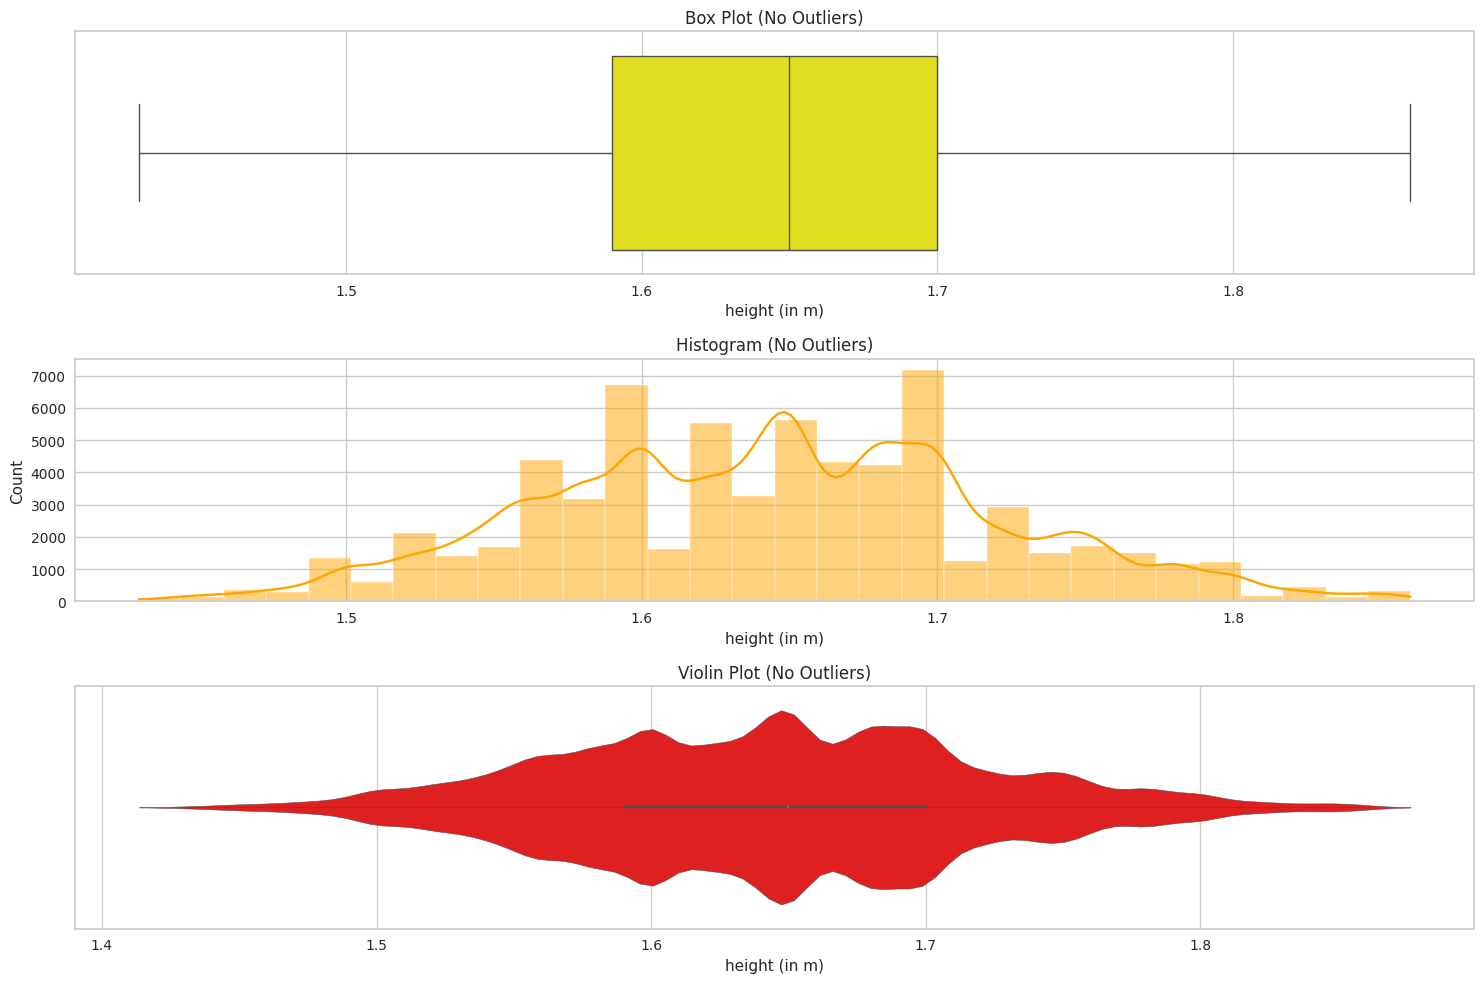

In [11]:
# Remove outliers
healthData = healthData[
    (healthData['height (in m)'] >= lower_whisker) &
    (healthData['height (in m)'] <= upper_whisker)
]
print(f"Shape after removing outliers: {healthData.shape}")

# Plot without outliers
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

sb.boxplot(x=healthData['height (in m)'], ax=axes[0], color='yellow')
axes[0].set_title('Box Plot (No Outliers)')

sb.histplot(healthData['height (in m)'], ax=axes[1], color='orange', kde=True, bins=30)
axes[1].set_title('Histogram (No Outliers)')

sb.violinplot(x=healthData['height (in m)'], ax=axes[2], color='red')
axes[2].set_title('Violin Plot (No Outliers)')

plt.tight_layout()
plt.show()

In [12]:
healthData.shape

(66499, 15)

## Weight (in kg)
### Plot Boxplot, Histogram, and Violin plot

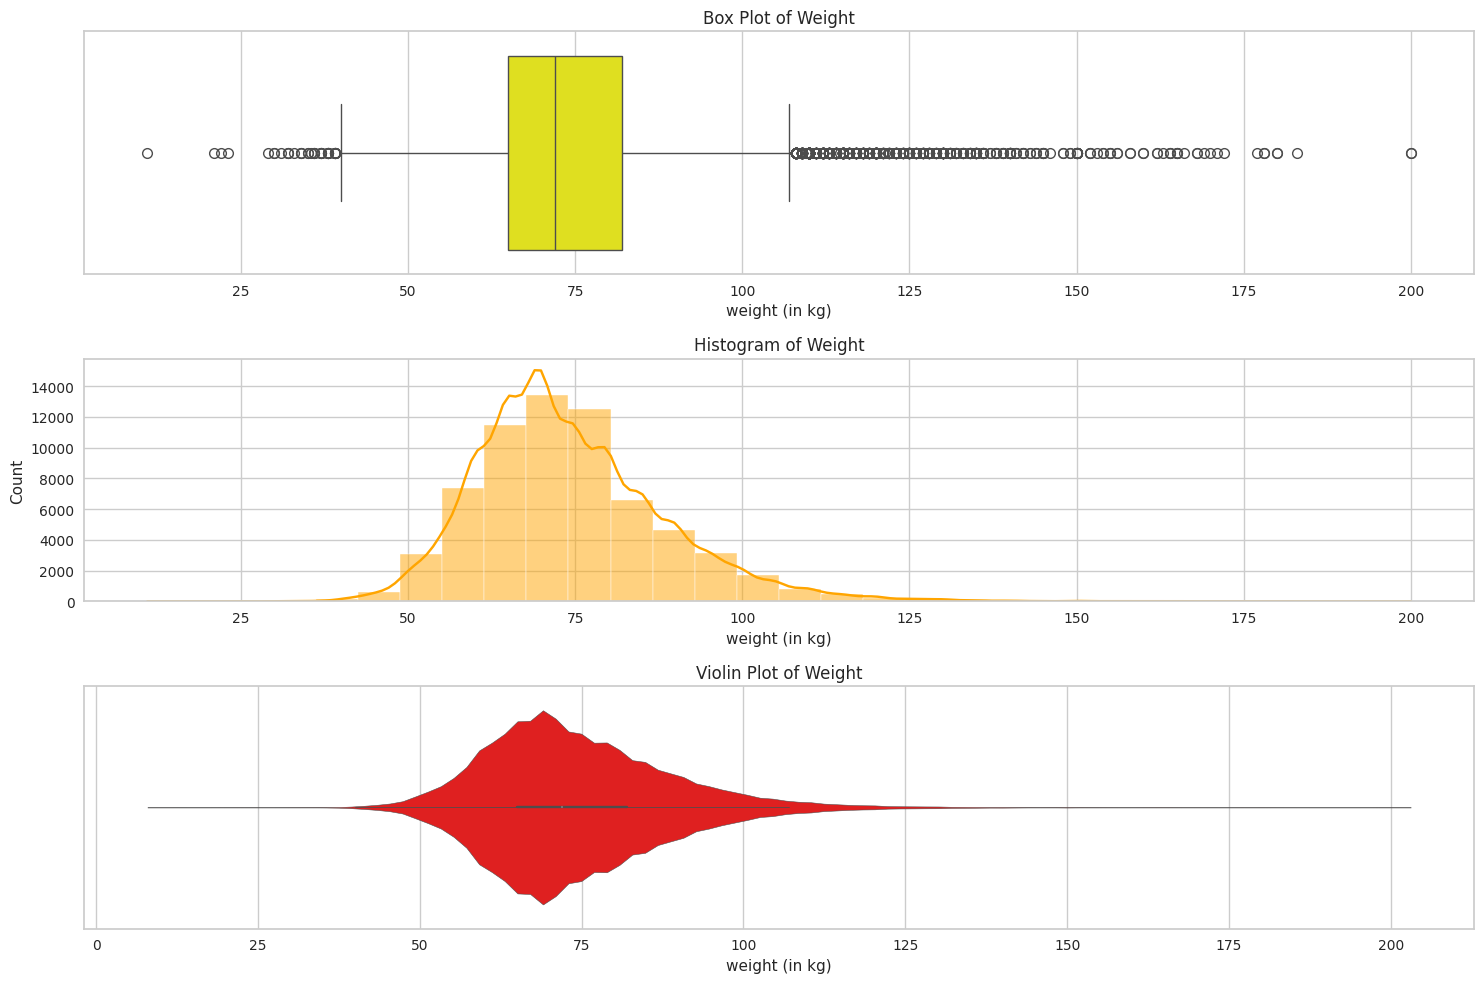

Boxplot Points for 'weight (in kg)':
Minimum Value (Lower Whisker): 39.5
Q1 (25th Percentile): 65.0
Median (50th Percentile): 72.0
Q3 (75th Percentile): 82.0
Maximum Value (Upper Whisker): 107.5

Outlier Counts for 'weight (in kg)':
Count of points below lower whisker: 42
Count of points above upper whisker: 1603


In [13]:
# Creating box plot, histplot, and violin plot for 'weight in kg'
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
sb.boxplot(x=healthData['weight (in kg)'], color='yellow')
plt.title('Box Plot of Weight')

plt.subplot(3, 1, 2)
sb.histplot(healthData['weight (in kg)'], color='orange', kde=True, bins=30)
plt.title('Histogram of Weight')

plt.subplot(3, 1, 3)
sb.violinplot(x=healthData['weight (in kg)'], color='red')
plt.title('Violin Plot of Weight')

plt.tight_layout()
plt.show()

# Extracting statistical values for boxplot of 'weight (in kg)'
weight_boxplot_stats = healthData['weight (in kg)'].describe()

# Calculating the necessary quartiles and IQR for boxplot:
q1 = weight_boxplot_stats['25%']  # Q1 (25th percentile)
median = weight_boxplot_stats['50%']  # Q2 (Median, 50th percentile)
q3 = weight_boxplot_stats['75%']  # Q3 (75th percentile)

iqr = q3 - q1  # Interquartile Range (IQR)

lower_whisker = q1 - 1.5 * iqr  # Lower whisker boundary (without outliers)
upper_whisker = q3 + 1.5 * iqr  # Upper whisker boundary (without outliers)

# Printing the boxplot points
print("Boxplot Points for 'weight (in kg)':")
print(f"Minimum Value (Lower Whisker): {max(lower_whisker, healthData['weight (in kg)'].min())}")
print(f"Q1 (25th Percentile): {q1}")
print(f"Median (50th Percentile): {median}")
print(f"Q3 (75th Percentile): {q3}")
print(f"Maximum Value (Upper Whisker): {min(upper_whisker, healthData['weight (in kg)'].max())}")

# Counting outlier points below and above the lower and upper whisker
outliers_below = healthData[healthData['weight (in kg)'] < lower_whisker].shape[0]
outliers_above = healthData[healthData['weight (in kg)'] > upper_whisker].shape[0]

print("\nOutlier Counts for 'weight (in kg)':")
print(f"Count of points below lower whisker: {outliers_below}")
print(f"Count of points above upper whisker: {outliers_above}")

### Remove outliers outside the lower and upper whiskers as our focus is on the average person.

### Then, plot the updated Boxplot, Histogram, and Violin plot.

Shape after removing outliers: (64854, 15)


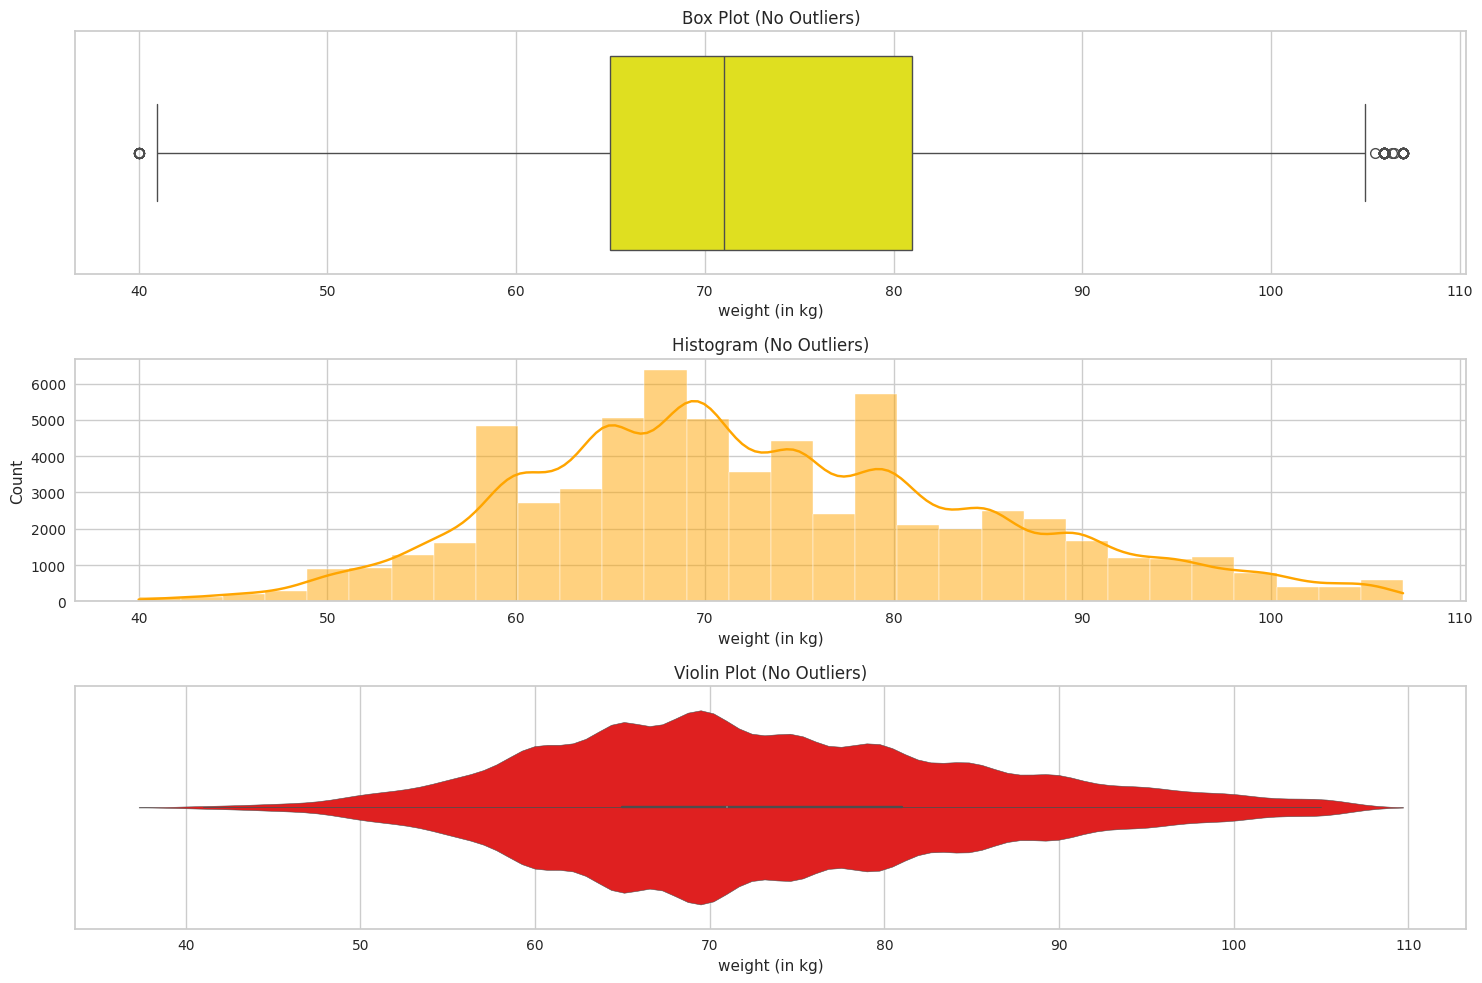

In [14]:
# Remove outliers
healthData = healthData[
    (healthData['weight (in kg)'] >= lower_whisker) &
    (healthData['weight (in kg)'] <= upper_whisker)
]
print(f"Shape after removing outliers: {healthData.shape}")

# Plot without outliers
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

sb.boxplot(x=healthData['weight (in kg)'], ax=axes[0], color='yellow')
axes[0].set_title('Box Plot (No Outliers)')

sb.histplot(healthData['weight (in kg)'], ax=axes[1], color='orange', kde=True, bins=30)
axes[1].set_title('Histogram (No Outliers)')

sb.violinplot(x=healthData['weight (in kg)'], ax=axes[2], color='red')
axes[2].set_title('Violin Plot (No Outliers)')

plt.tight_layout()
plt.show()

In [15]:
healthData.shape

(64854, 15)

### It appears that there are still outliers in the box plots, this is because seaborn computes a new Q1, Q3, and whiskers on the trimmed dataset. So some points in the subset might still lie beyond these new whiskers and get drawn as outliers again.

## Body Mass Index (BMI)
### Plot Boxplot, Histogram, and Violin plot

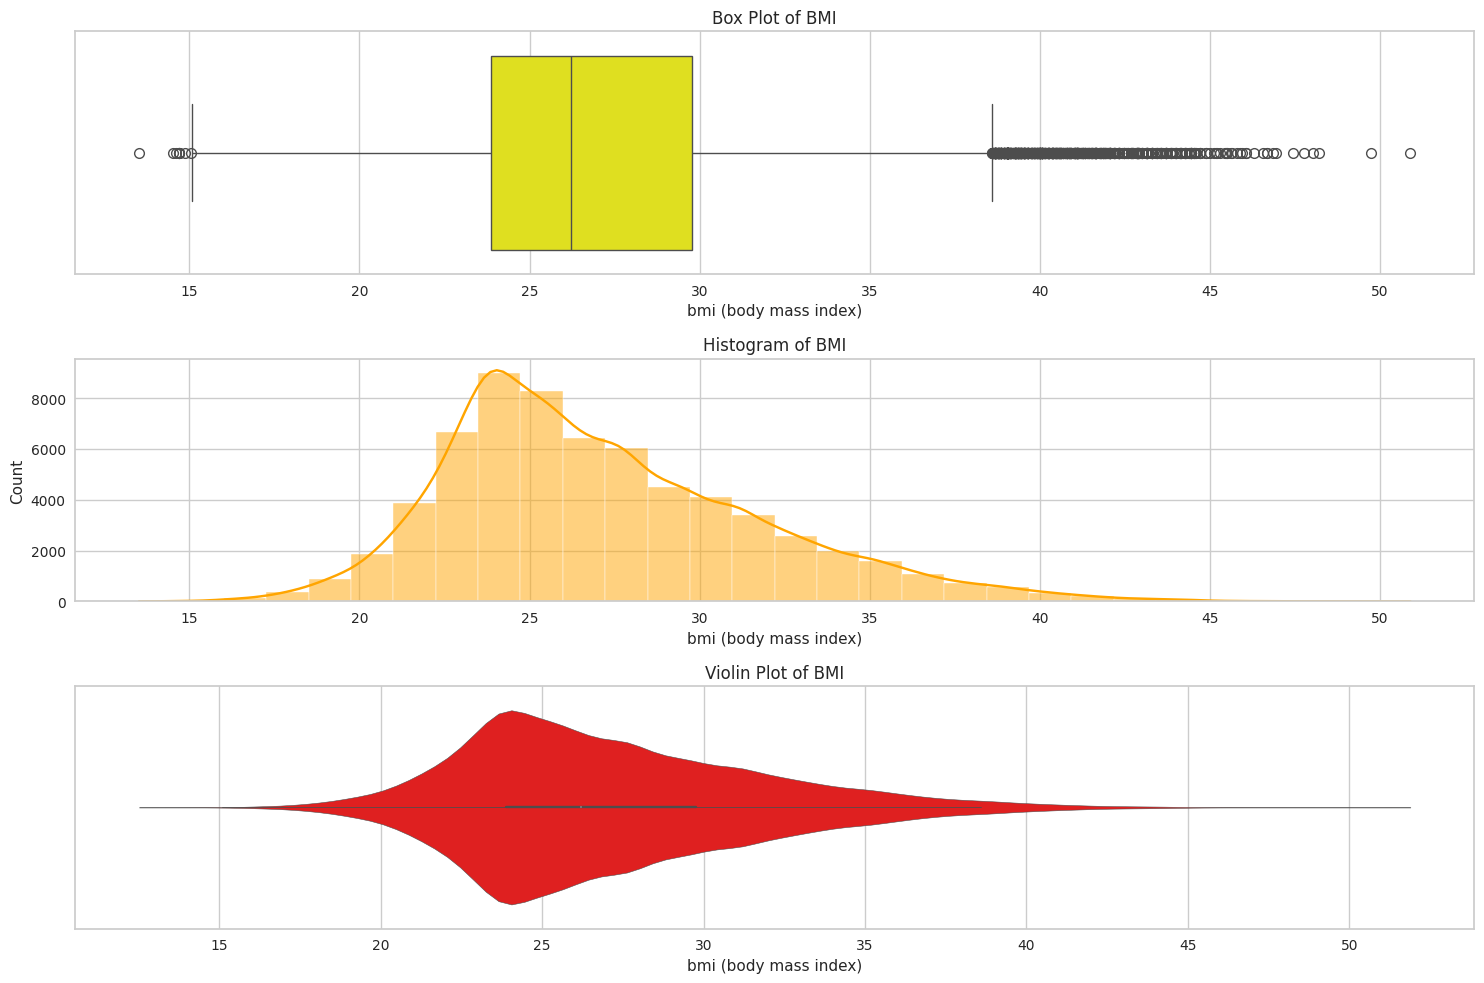


Outlier Counts for 'bmi (body mass index)':
Count of points below lower whisker: 10
Count of points above upper whisker: 1230


In [16]:
# Creating box plot, histplot, and violin plot for 'bmi (body mass index)'
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
sb.boxplot(x=healthData['bmi (body mass index)'], color='yellow')
plt.title('Box Plot of BMI')

plt.subplot(3, 1, 2)
sb.histplot(healthData['bmi (body mass index)'], color='orange', kde=True, bins=30)
plt.title('Histogram of BMI')

plt.subplot(3, 1, 3)
sb.violinplot(x=healthData['bmi (body mass index)'], color='red')
plt.title('Violin Plot of BMI')

plt.tight_layout()
plt.show()

# Extracting statistical values for boxplot of 'bmi (body mass index)'
bmi_boxplot_stats = healthData['bmi (body mass index)'].describe()

# Calculating the necessary quartiles and IQR for boxplot:
q1 = bmi_boxplot_stats['25%']  # Q1 (25th percentile)
median = bmi_boxplot_stats['50%']  # Q2 (Median, 50th percentile)
q3 = bmi_boxplot_stats['75%']  # Q3 (75th percentile)

iqr = q3 - q1  # Interquartile Range (IQR)

lower_whisker = q1 - 1.5 * iqr  # Lower whisker boundary (without outliers)
upper_whisker = q3 + 1.5 * iqr  # Upper whisker boundary (without outliers)

# Counting outlier points below and above the lower and upper whisker
outliers_below = healthData[healthData['bmi (body mass index)'] < lower_whisker].shape[0]
outliers_above = healthData[healthData['bmi (body mass index)'] > upper_whisker].shape[0]

print("\nOutlier Counts for 'bmi (body mass index)':")
print(f"Count of points below lower whisker: {outliers_below}")
print(f"Count of points above upper whisker: {outliers_above}")

### Remove outliers outside the lower and upper whiskers as our focus is on the average person.
### Then, plot the updated Boxplot, Histogram, and Violin plot.

Shape after removing outliers: (63614, 15)


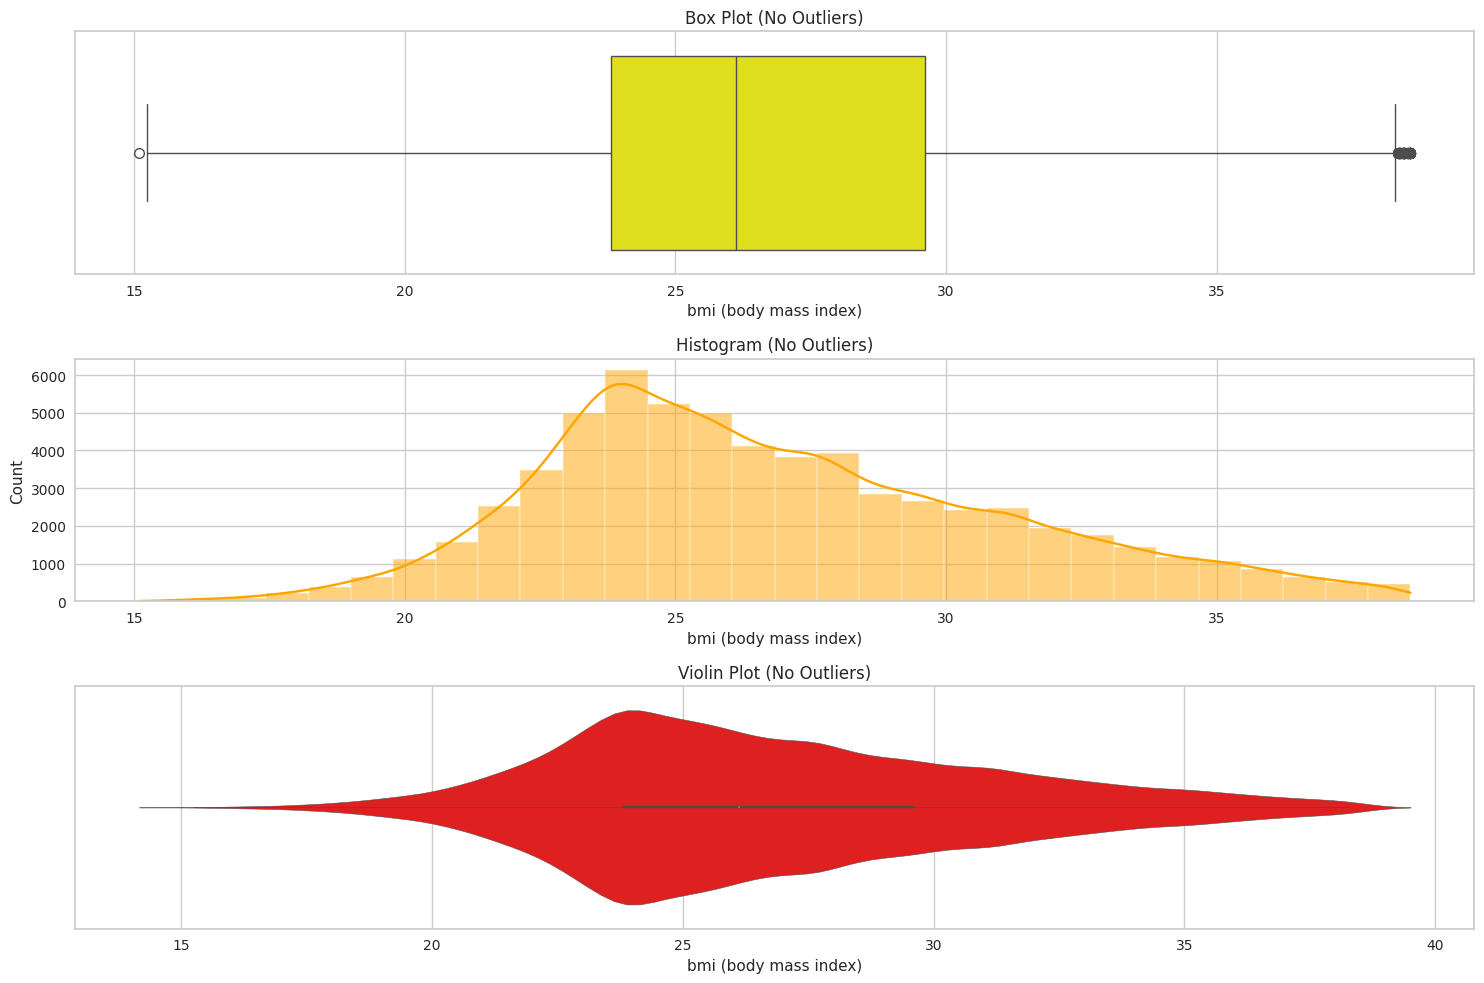

In [17]:
# Remove outliers
healthData = healthData[
    (healthData['bmi (body mass index)'] >= lower_whisker) &
    (healthData['bmi (body mass index)'] <= upper_whisker)
]
print(f"Shape after removing outliers: {healthData.shape}")

# Plot without outliers
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

sb.boxplot(x=healthData['bmi (body mass index)'], ax=axes[0], color='yellow')
axes[0].set_title('Box Plot (No Outliers)')

sb.histplot(healthData['bmi (body mass index)'], ax=axes[1], color='orange', kde=True, bins=30)
axes[1].set_title('Histogram (No Outliers)')

sb.violinplot(x=healthData['bmi (body mass index)'], ax=axes[2], color='red')
axes[2].set_title('Violin Plot (No Outliers)')

plt.tight_layout()
plt.show()

In [18]:
healthData.shape

(63614, 15)

### It appears that there are still outliers in the box plots, this is because seaborn computes a new Q1, Q3, and whiskers on the trimmed dataset. So some points in the subset might still lie beyond these new whiskers and get drawn as outliers again.

## Systolic Blood Pressure (SBP)
### Plot Boxplot, Histogram, and Violin plot

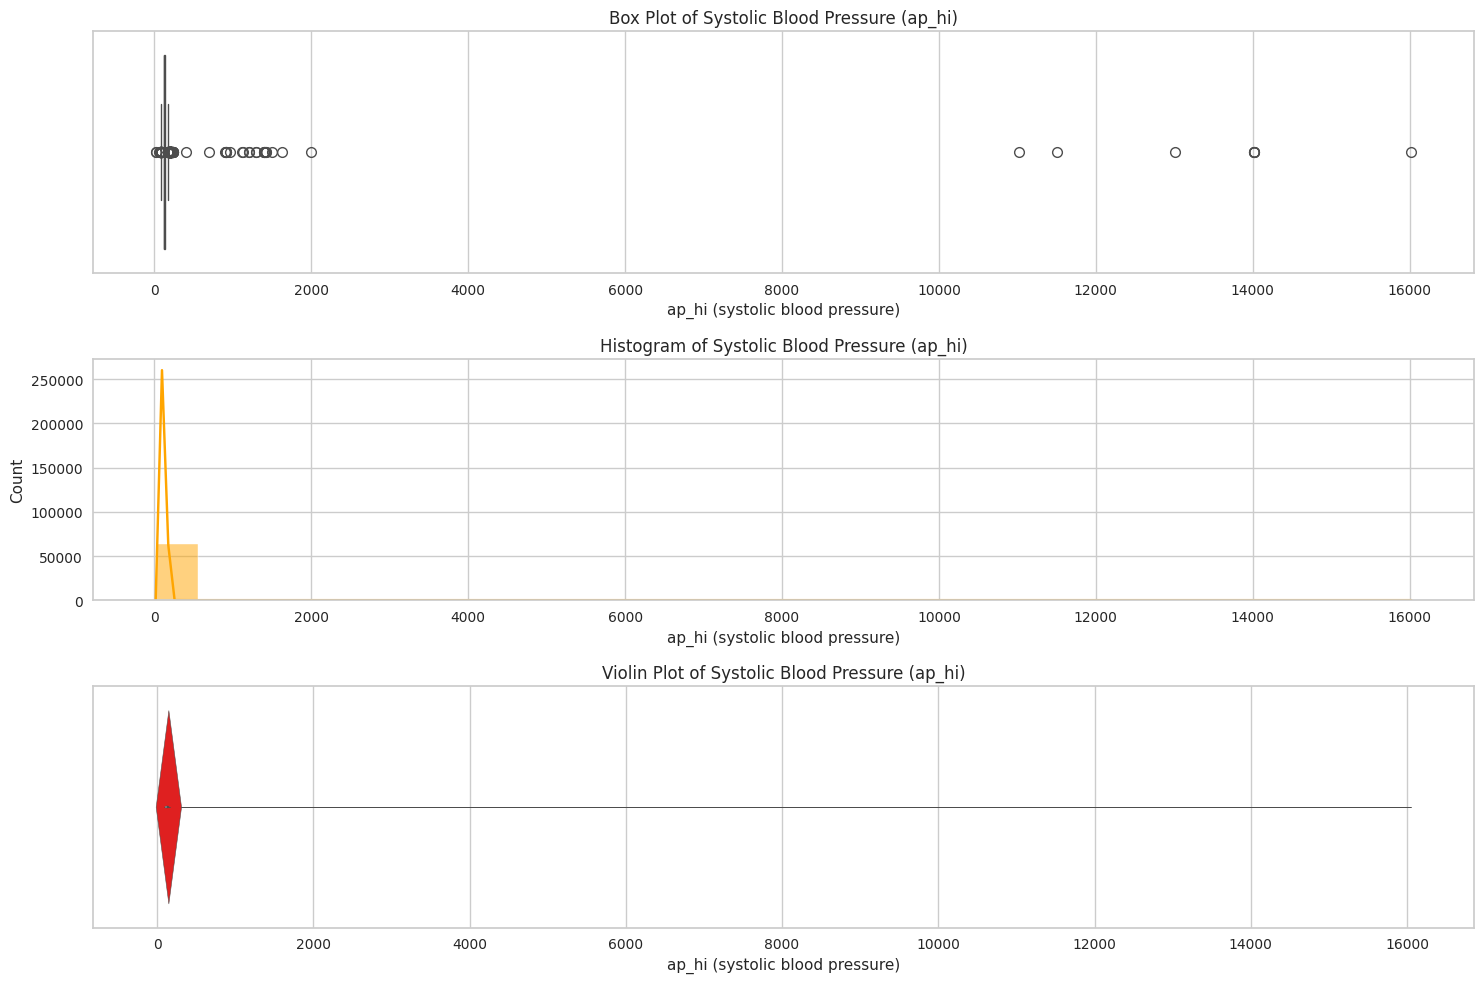

Boxplot Points for 'ap_hi (systolic blood pressure)'
Minimum Value (Lower Whisker): 90.0
Q1 (25th Percentile): 120.0
Median (50th Percentile): 120.0
Q3 (75th Percentile): 140.0
Maximum Value (Upper Whisker): 170.0

Outlier Counts for 'ap_hi (systolic blood pressure)':
Count of points below lower whisker: 74
Count of points above upper whisker: 815


In [19]:
# Creating box plot, histplot, and violin plot for 'ap_hi (systolic blood pressure)'
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
sb.boxplot(x=healthData['ap_hi (systolic blood pressure)'], color='yellow')
plt.title('Box Plot of Systolic Blood Pressure (ap_hi)')

plt.subplot(3, 1, 2)
sb.histplot(healthData['ap_hi (systolic blood pressure)'], color='orange', kde=True, bins=30)
plt.title('Histogram of Systolic Blood Pressure (ap_hi)')

plt.subplot(3, 1, 3)
sb.violinplot(x=healthData['ap_hi (systolic blood pressure)'], color='red')
plt.title('Violin Plot of Systolic Blood Pressure (ap_hi)')

plt.tight_layout()
plt.show()

# Extracting statistical values for boxplot of 'ap_hi (systolic blood pressure)'
ap_hi_boxplot_stats = healthData['ap_hi (systolic blood pressure)'].describe()

# Calculating the necessary quartiles and IQR for boxplot:
q1 = ap_hi_boxplot_stats['25%']  # Q1 (25th percentile)
median = ap_hi_boxplot_stats['50%']  # Q2 (Median, 50th percentile)
q3 = ap_hi_boxplot_stats['75%']  # Q3 (75th percentile)

iqr = q3 - q1  # Interquartile Range (IQR)

lower_whisker = q1 - 1.5 * iqr  # Lower whisker boundary (without outliers)
upper_whisker = q3 + 1.5 * iqr  # Upper whisker boundary (without outliers)

# Printing the boxplot points
print("Boxplot Points for 'ap_hi (systolic blood pressure)'")
print(f"Minimum Value (Lower Whisker): {max(lower_whisker, healthData['ap_hi (systolic blood pressure)'].min())}")
print(f"Q1 (25th Percentile): {q1}")
print(f"Median (50th Percentile): {median}")
print(f"Q3 (75th Percentile): {q3}")
print(f"Maximum Value (Upper Whisker): {min(upper_whisker, healthData['ap_hi (systolic blood pressure)'].max())}")

# Counting outlier points below and above the lower and upper whisker
outliers_below = healthData[healthData['ap_hi (systolic blood pressure)'] < lower_whisker].shape[0]
outliers_above = healthData[healthData['ap_hi (systolic blood pressure)'] > upper_whisker].shape[0]

print("\nOutlier Counts for 'ap_hi (systolic blood pressure)':")
print(f"Count of points below lower whisker: {outliers_below}")
print(f"Count of points above upper whisker: {outliers_above}")

### Remove outliers outside the lower and upper whiskers as our focus is on the average person.
### Then, plot the updated Boxplot, Histogram, and Violin plot.

Shape after removing outliers: (62725, 15)


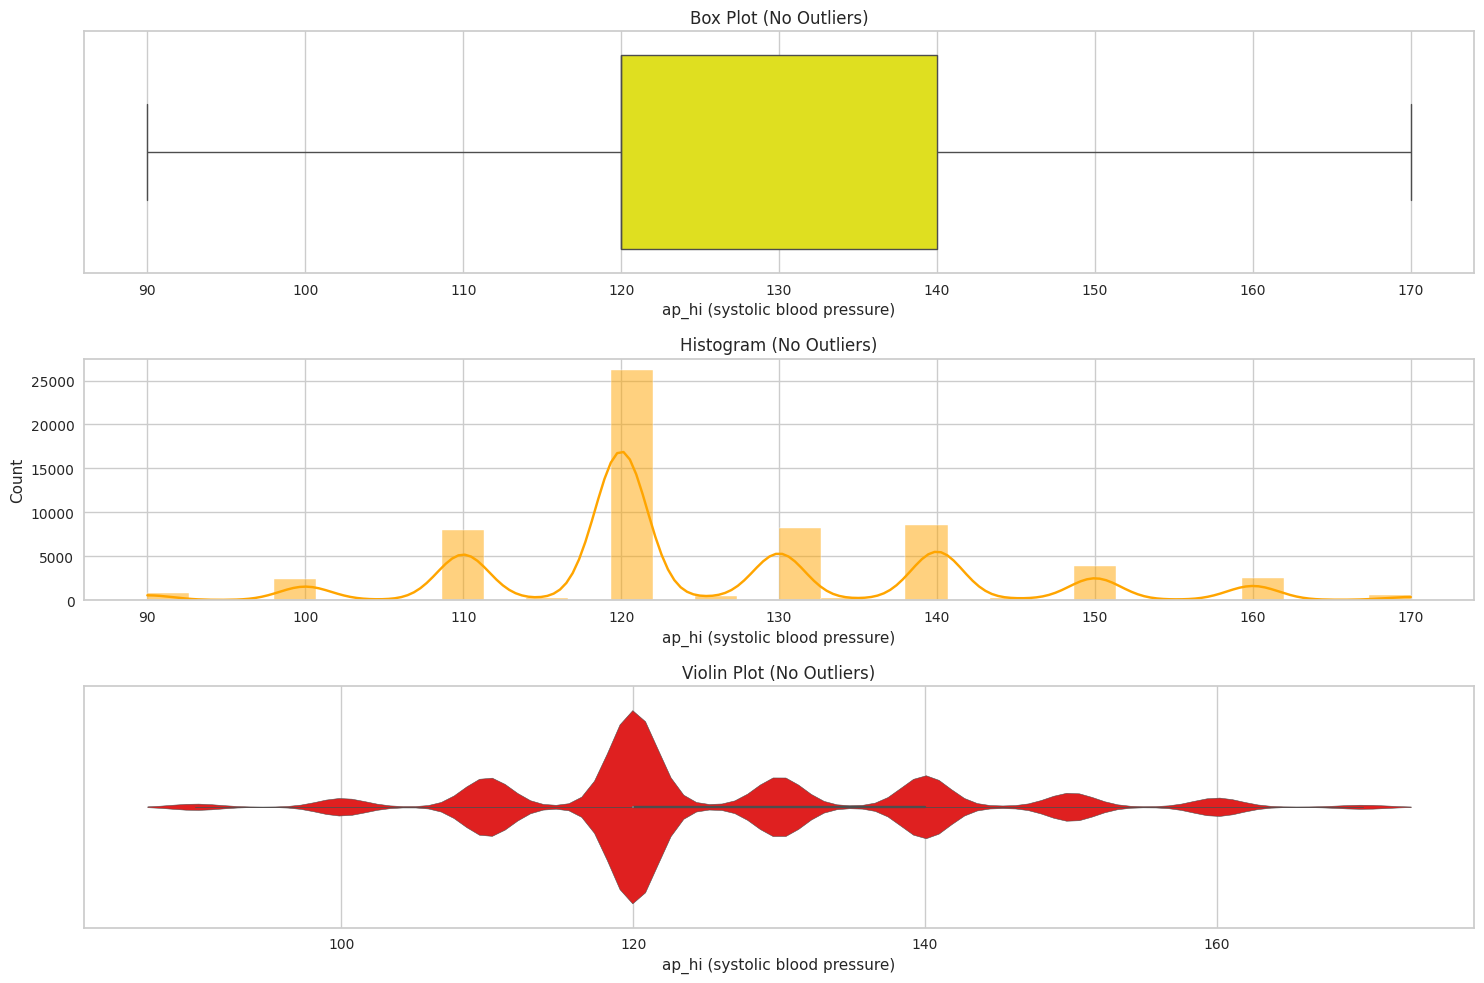

In [20]:
# Remove outliers
healthData = healthData[
    (healthData['ap_hi (systolic blood pressure)'] >= lower_whisker) &
    (healthData['ap_hi (systolic blood pressure)'] <= upper_whisker)
]
print(f"Shape after removing outliers: {healthData.shape}")

# Plot without outliers
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

sb.boxplot(x=healthData['ap_hi (systolic blood pressure)'], ax=axes[0], color='yellow')
axes[0].set_title('Box Plot (No Outliers)')

sb.histplot(healthData['ap_hi (systolic blood pressure)'], ax=axes[1], color='orange', kde=True, bins=30)
axes[1].set_title('Histogram (No Outliers)')

sb.violinplot(x=healthData['ap_hi (systolic blood pressure)'], ax=axes[2], color='red')
axes[2].set_title('Violin Plot (No Outliers)')

plt.tight_layout()
plt.show()

In [21]:
healthData.shape

(62725, 15)

## Diastolic Blood Pressure (DBP)
### Plot Boxplot, Histogram, and Violin plot

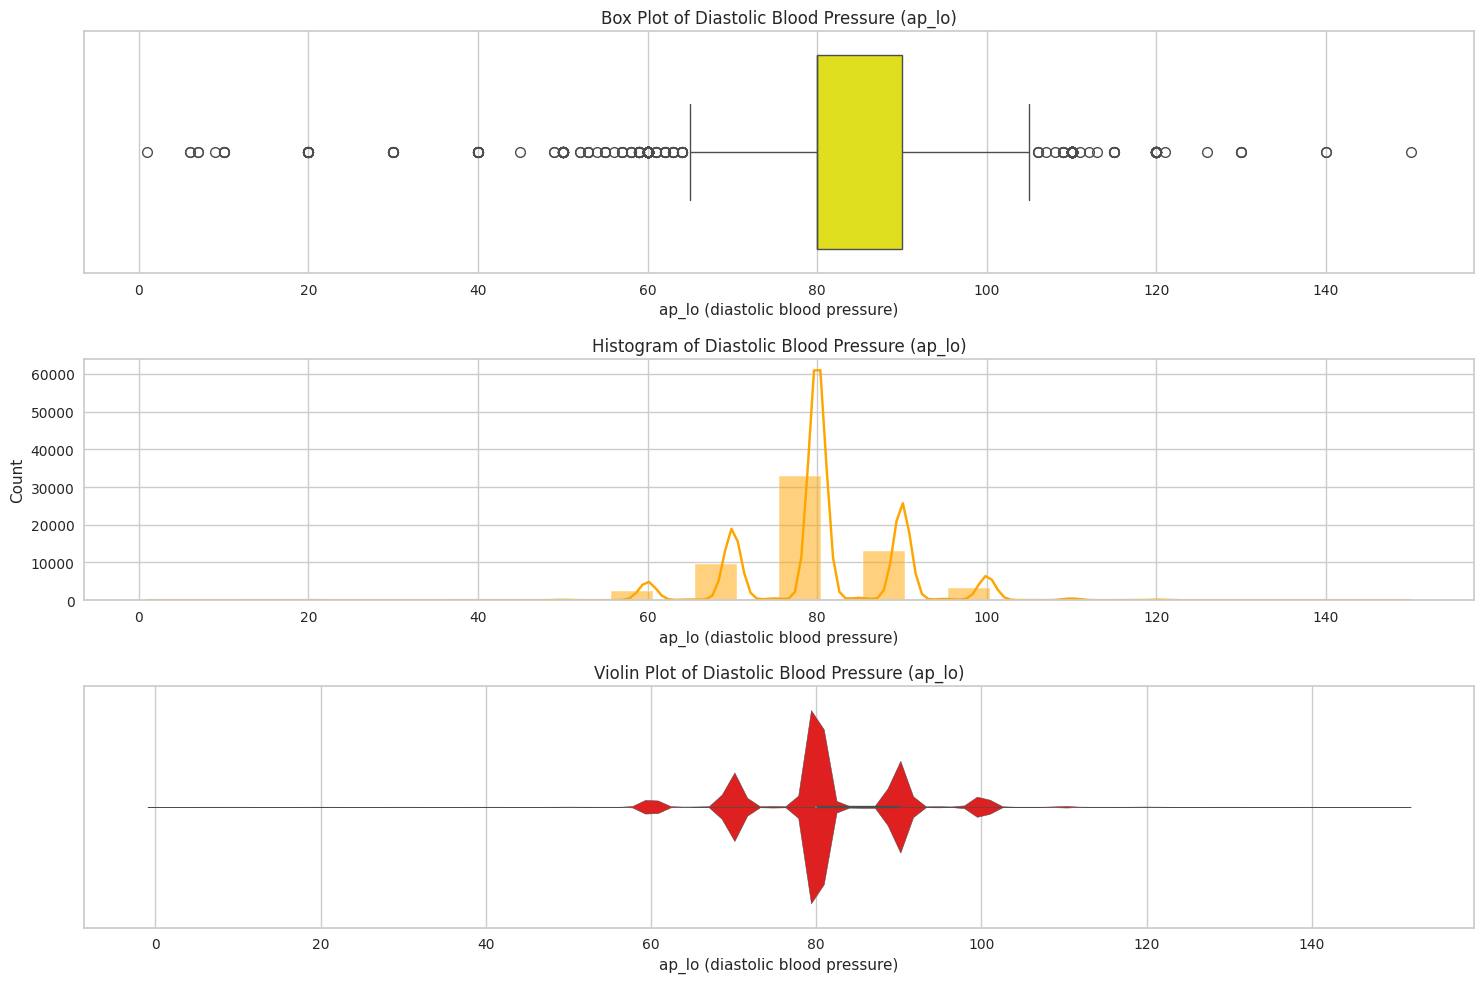

Boxplot Points for 'ap_lo (diastolic blood pressure)'
Minimum Value (Lower Whisker): 65.0
Q1 (25th Percentile): 80.0
Median (50th Percentile): 80.0
Q3 (75th Percentile): 90.0
Maximum Value (Upper Whisker): 105.0

Outlier Counts for 'ap_lo (diastolic blood pressure)':
Count of points below lower whisker: 2587
Count of points above upper whisker: 311


In [22]:
# Creating box plot, histplot, and violin plot for 'ap_lo (diastolic blood pressure)'
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
sb.boxplot(x=healthData['ap_lo (diastolic blood pressure)'], color='yellow')
plt.title('Box Plot of Diastolic Blood Pressure (ap_lo)')

plt.subplot(3, 1, 2)
sb.histplot(healthData['ap_lo (diastolic blood pressure)'], color='orange', kde=True, bins=30)
plt.title('Histogram of Diastolic Blood Pressure (ap_lo)')

plt.subplot(3, 1, 3)
sb.violinplot(x=healthData['ap_lo (diastolic blood pressure)'], color='red')
plt.title('Violin Plot of Diastolic Blood Pressure (ap_lo)')

plt.tight_layout()
plt.show()

# Extracting statistical values for boxplot of 'ap_lo (diastolic blood pressure)'
ap_lo_boxplot_stats = healthData['ap_lo (diastolic blood pressure)'].describe()

# Calculating the necessary quartiles and IQR for boxplot:
q1 = ap_lo_boxplot_stats['25%']  # Q1 (25th percentile)
median = ap_lo_boxplot_stats['50%']  # Q2 (Median, 50th percentile)
q3 = ap_lo_boxplot_stats['75%']  # Q3 (75th percentile)

iqr = q3 - q1  # Interquartile Range (IQR)

lower_whisker = q1 - 1.5 * iqr  # Lower whisker boundary (without outliers)
upper_whisker = q3 + 1.5 * iqr  # Upper whisker boundary (without outliers)

# Printing the boxplot points
print("Boxplot Points for 'ap_lo (diastolic blood pressure)'")
print(f"Minimum Value (Lower Whisker): {max(lower_whisker, healthData['ap_lo (diastolic blood pressure)'].min())}")
print(f"Q1 (25th Percentile): {q1}")
print(f"Median (50th Percentile): {median}")
print(f"Q3 (75th Percentile): {q3}")
print(f"Maximum Value (Upper Whisker): {min(upper_whisker, healthData['ap_lo (diastolic blood pressure)'].max())}")

# Counting outlier points below and above the lower and upper whisker
outliers_below = healthData[healthData['ap_lo (diastolic blood pressure)'] < lower_whisker].shape[0]
outliers_above = healthData[healthData['ap_lo (diastolic blood pressure)'] > upper_whisker].shape[0]

print("\nOutlier Counts for 'ap_lo (diastolic blood pressure)':")
print(f"Count of points below lower whisker: {outliers_below}")
print(f"Count of points above upper whisker: {outliers_above}")

### Remove outliers outside the lower and upper whiskers as our focus is on the average person.
### Then, plot the updated Boxplot, Histogram, and Violin plot.

Shape after removing outliers: (59827, 15)


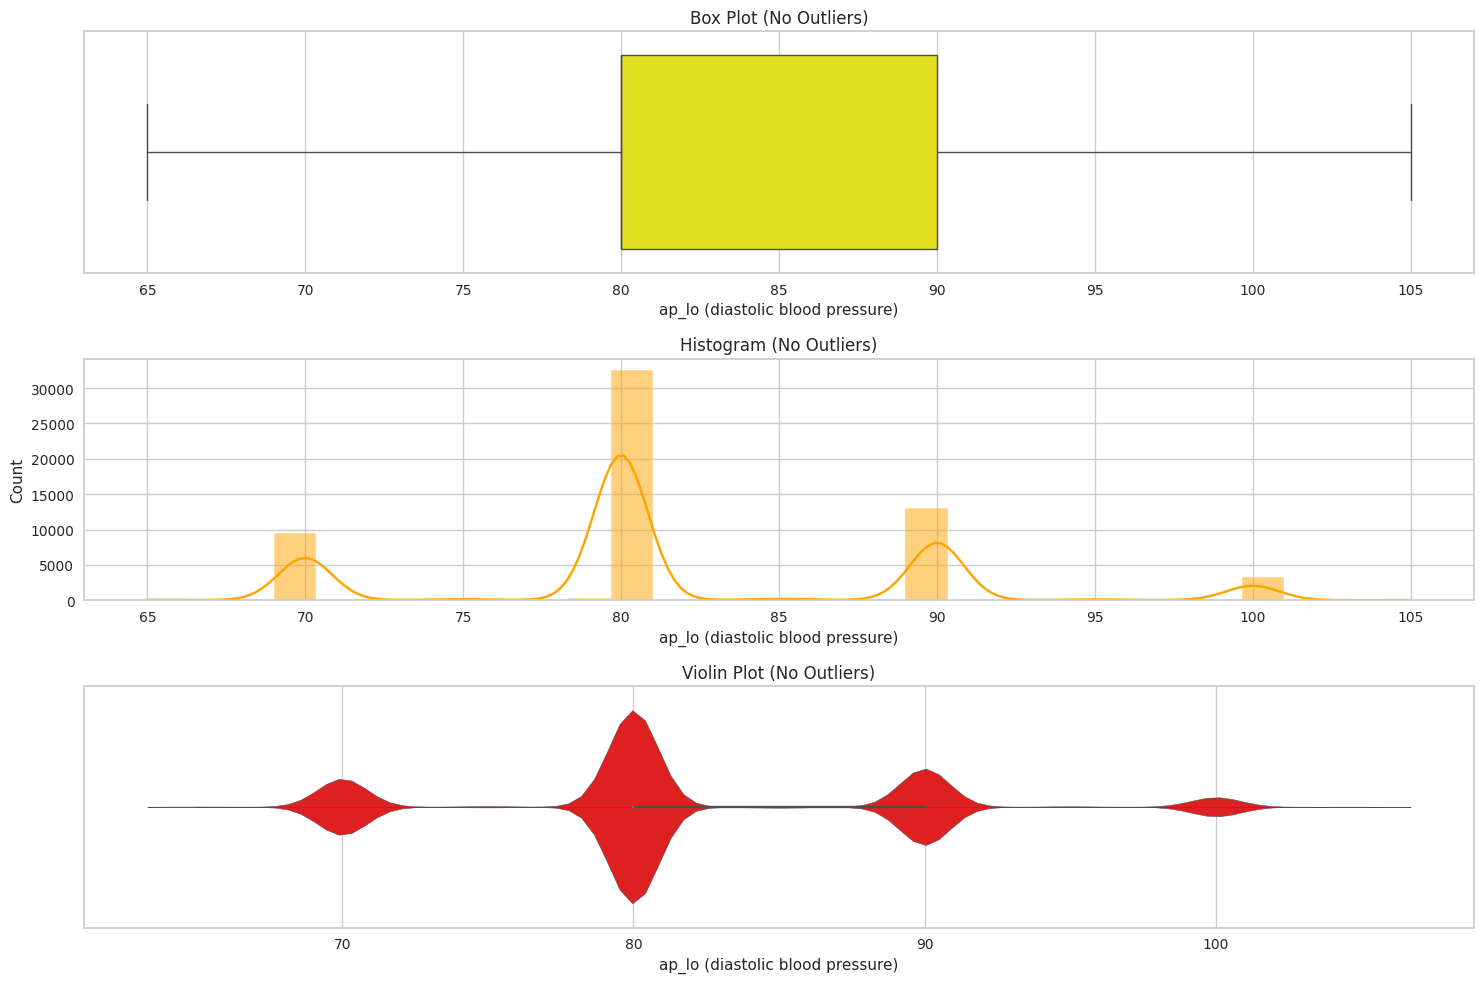

In [23]:
# Remove outliers
healthData = healthData[
    (healthData['ap_lo (diastolic blood pressure)'] >= lower_whisker) &
    (healthData['ap_lo (diastolic blood pressure)'] <= upper_whisker)
]
print(f"Shape after removing outliers: {healthData.shape}")

# Plot without outliers
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

sb.boxplot(x=healthData['ap_lo (diastolic blood pressure)'], ax=axes[0], color='yellow')
axes[0].set_title('Box Plot (No Outliers)')

sb.histplot(healthData['ap_lo (diastolic blood pressure)'], ax=axes[1], color='orange', kde=True, bins=30)
axes[1].set_title('Histogram (No Outliers)')

sb.violinplot(x=healthData['ap_lo (diastolic blood pressure)'], ax=axes[2], color='red')
axes[2].set_title('Violin Plot (No Outliers)')

plt.tight_layout()
plt.show()

In [24]:
healthData.shape

(59827, 15)

## Mean Arterial Pressure (MAP)
### Plot Boxplot, Histogram, and Violin plot

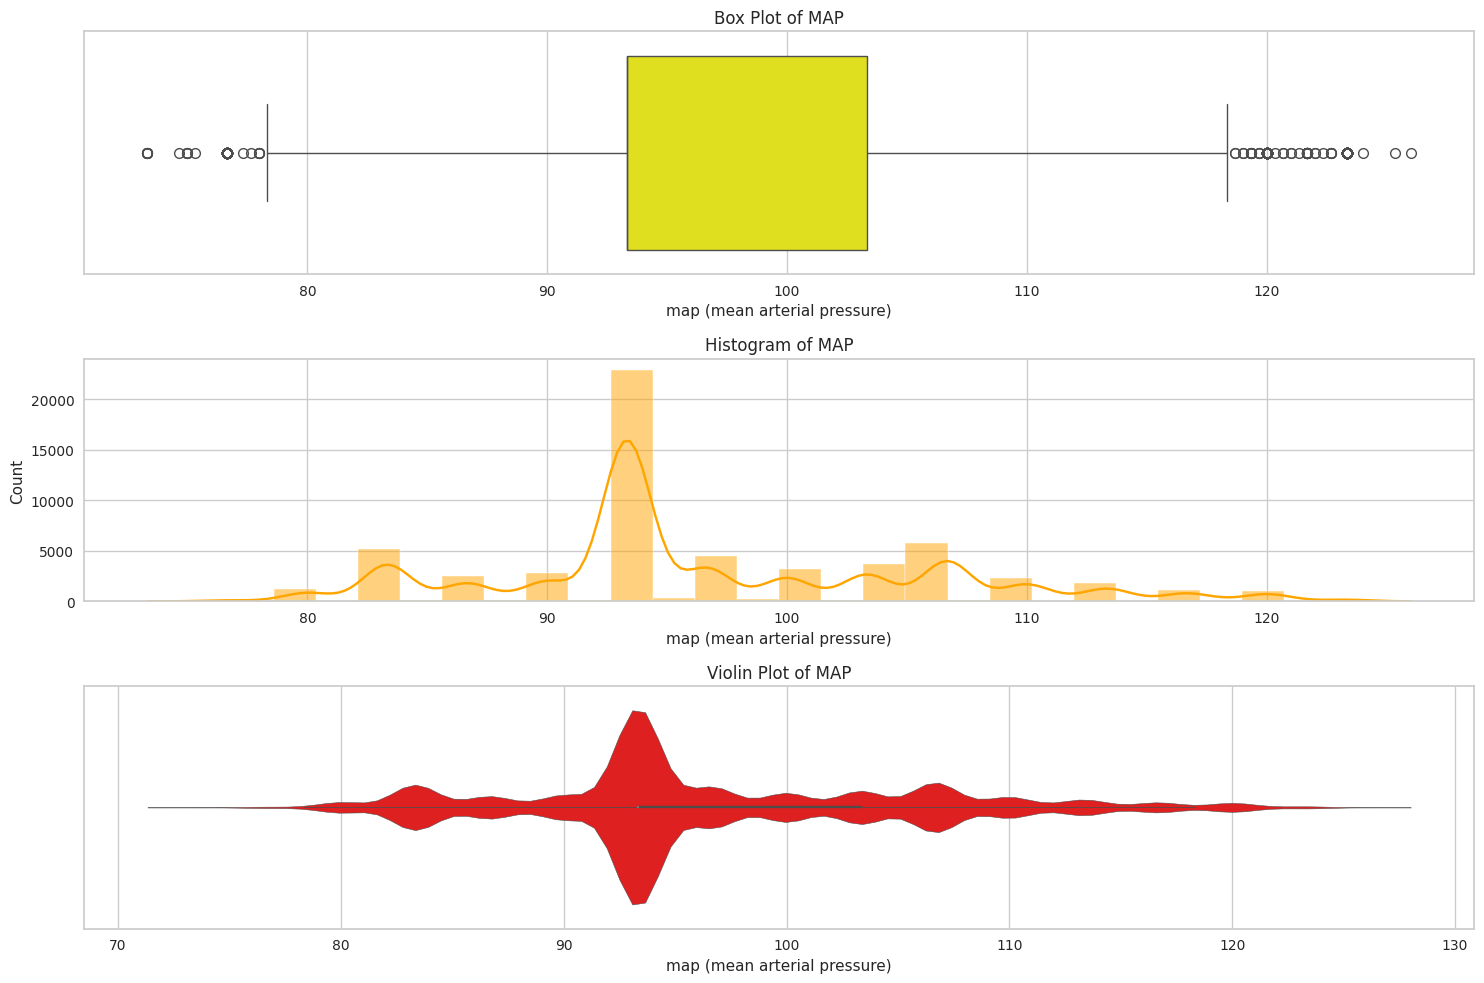

Boxplot Points for 'map (mean arterial pressure)'
Minimum Value (Lower Whisker): 78.33
Q1 (25th Percentile): 93.33
Median (50th Percentile): 93.33
Q3 (75th Percentile): 103.33
Maximum Value (Upper Whisker): 118.33

Outlier Counts for 'map (mean arterial pressure)':
Count of points below lower whisker: 159
Count of points above upper whisker: 1280


In [25]:
# Correcting the column name to match what is in the dataset.
# Based on the dataset, the correct column name is 'map (mean arterial pressure)', not 'map (Mean arterial pressure)'.

# Creating box plot, histplot, and violin plot for 'map (mean arterial pressure)'
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
sb.boxplot(x=healthData['map (mean arterial pressure)'], color='yellow')
plt.title('Box Plot of MAP')

plt.subplot(3, 1, 2)
sb.histplot(healthData['map (mean arterial pressure)'], color='orange', kde=True, bins=30)
plt.title('Histogram of MAP')

plt.subplot(3, 1, 3)
sb.violinplot(x=healthData['map (mean arterial pressure)'], color='red')
plt.title('Violin Plot of MAP')

plt.tight_layout()
plt.show()

# Extracting statistical values for boxplot of 'map (mean arterial pressure)'
map_boxplot_stats = healthData['map (mean arterial pressure)'].describe()

# Calculating the necessary quartiles and IQR for boxplot:
q1 = map_boxplot_stats['25%']  # Q1 (25th percentile)
median = map_boxplot_stats['50%']  # Q2 (Median, 50th percentile)
q3 = map_boxplot_stats['75%']  # Q3 (75th percentile)

iqr = q3 - q1  # Interquartile Range (IQR)

lower_whisker = q1 - 1.5 * iqr  # Lower whisker boundary (without outliers)
upper_whisker = q3 + 1.5 * iqr  # Upper whisker boundary (without outliers)

# Printing the boxplot points
print("Boxplot Points for 'map (mean arterial pressure)'")
print(f"Minimum Value (Lower Whisker): {max(lower_whisker, healthData['map (mean arterial pressure)'].min())}")
print(f"Q1 (25th Percentile): {q1}")
print(f"Median (50th Percentile): {median}")
print(f"Q3 (75th Percentile): {q3}")
print(f"Maximum Value (Upper Whisker): {min(upper_whisker, healthData['map (mean arterial pressure)'].max())}")

# Counting outlier points below and above the lower and upper whisker
outliers_below = healthData[healthData['map (mean arterial pressure)'] < lower_whisker].shape[0]
outliers_above = healthData[healthData['map (mean arterial pressure)'] > upper_whisker].shape[0]

print("\nOutlier Counts for 'map (mean arterial pressure)':")
print(f"Count of points below lower whisker: {outliers_below}")
print(f"Count of points above upper whisker: {outliers_above}")

### Remove outliers outside the lower and upper whiskers as our focus is on the average person.
### Then, plot the updated Boxplot, Histogram, and Violin plot.

Shape after removing outliers: (58388, 15)


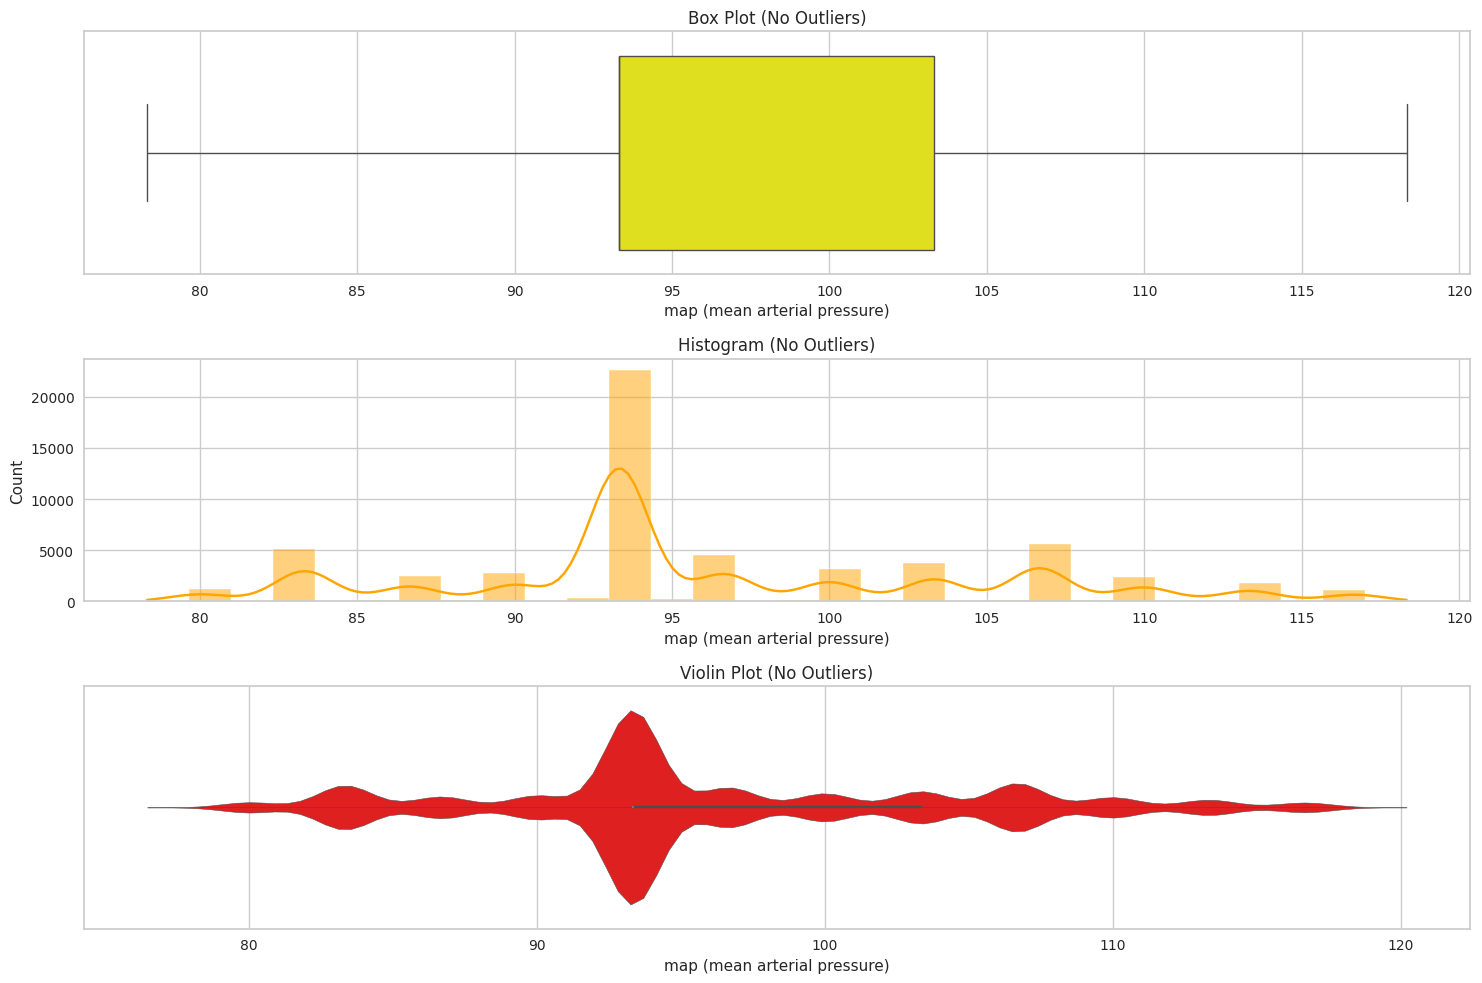

In [26]:
# Remove outliers
healthData = healthData[
    (healthData['map (mean arterial pressure)'] >= lower_whisker) &
    (healthData['map (mean arterial pressure)'] <= upper_whisker)
]
print(f"Shape after removing outliers: {healthData.shape}")

# Plot without outliers
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

sb.boxplot(x=healthData['map (mean arterial pressure)'], ax=axes[0], color='yellow')
axes[0].set_title('Box Plot (No Outliers)')

sb.histplot(healthData['map (mean arterial pressure)'], ax=axes[1], color='orange', kde=True, bins=30)
axes[1].set_title('Histogram (No Outliers)')

sb.violinplot(x=healthData['map (mean arterial pressure)'], ax=axes[2], color='red')
axes[2].set_title('Violin Plot (No Outliers)')

plt.tight_layout()
plt.show()

In [27]:
healthData.shape

(58388, 15)

## Pulse Pressure (PP)
### Plot Boxplot, Histogram, and Violin plot

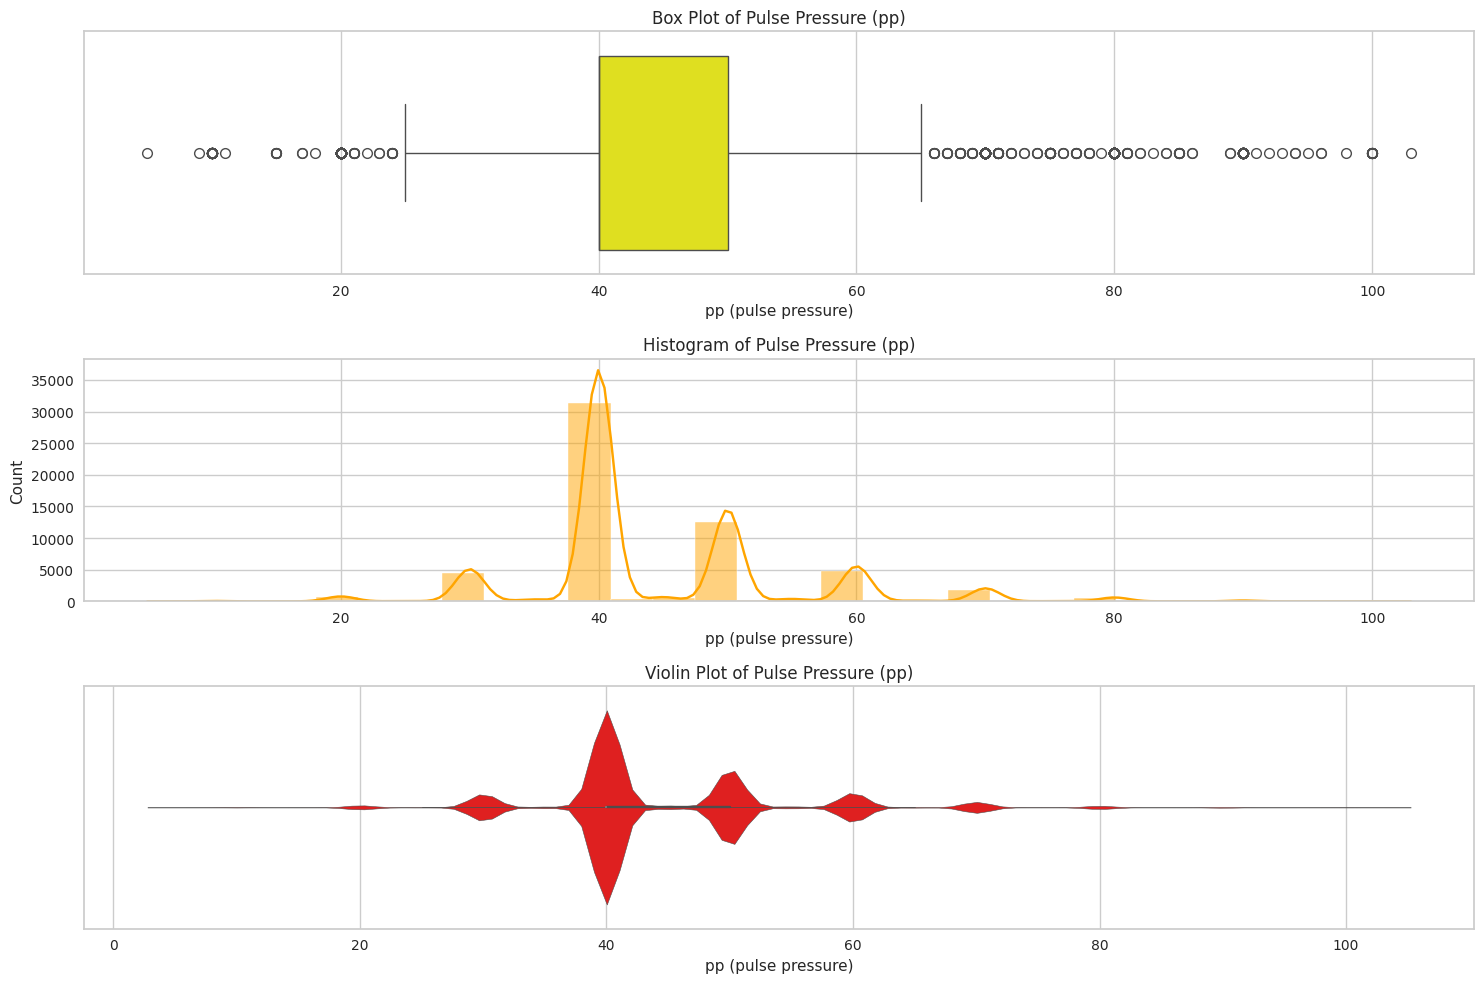

Boxplot Points for 'pp (pulse pressure)'
Minimum Value (Lower Whisker): 25.0
Q1 (25th Percentile): 40.0
Median (50th Percentile): 40.0
Q3 (75th Percentile): 50.0
Maximum Value (Upper Whisker): 65.0

Outlier Counts for 'pp (pulse pressure)':
Count of points below lower whisker: 753
Count of points above upper whisker: 2541


In [28]:
# Fixing the KeyError by checking and using the correct column name from the dataset.
# From the dataset provided earlier, the accurate column name is 'pp (pulse pressure)'.

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
sb.boxplot(x=healthData['pp (pulse pressure)'], color='yellow')
plt.title('Box Plot of Pulse Pressure (pp)')

plt.subplot(3, 1, 2)
sb.histplot(healthData['pp (pulse pressure)'], color='orange', kde=True, bins=30)
plt.title('Histogram of Pulse Pressure (pp)')

plt.subplot(3, 1, 3)
sb.violinplot(x=healthData['pp (pulse pressure)'], color='red')
plt.title('Violin Plot of Pulse Pressure (pp)')

plt.tight_layout()
plt.show()

# Extracting statistical values for boxplot of 'pp (pulse pressure)'
pp_boxplot_stats = healthData['pp (pulse pressure)'].describe()

# Calculating the necessary quartiles and IQR for boxplot:
q1 = pp_boxplot_stats['25%']  # Q1 (25th percentile)
median = pp_boxplot_stats['50%']  # Q2 (Median, 50th percentile)
q3 = pp_boxplot_stats['75%']  # Q3 (75th percentile)

iqr = q3 - q1  # Interquartile Range (IQR)

lower_whisker = q1 - 1.5 * iqr  # Lower whisker boundary (without outliers)
upper_whisker = q3 + 1.5 * iqr  # Upper whisker boundary (without outliers)

# Printing the boxplot points
print("Boxplot Points for 'pp (pulse pressure)'")
print(f"Minimum Value (Lower Whisker): {max(lower_whisker, healthData['pp (pulse pressure)'].min())}")
print(f"Q1 (25th Percentile): {q1}")
print(f"Median (50th Percentile): {median}")
print(f"Q3 (75th Percentile): {q3}")
print(f"Maximum Value (Upper Whisker): {min(upper_whisker, healthData['pp (pulse pressure)'].max())}")

# Counting outlier points below and above the lower and upper whisker
outliers_below = healthData[healthData['pp (pulse pressure)'] < lower_whisker].shape[0]
outliers_above = healthData[healthData['pp (pulse pressure)'] > upper_whisker].shape[0]

print("\nOutlier Counts for 'pp (pulse pressure)':")
print(f"Count of points below lower whisker: {outliers_below}")
print(f"Count of points above upper whisker: {outliers_above}")

### Remove outliers outside the lower and upper whiskers as our focus is on the average person.
### Then, plot the updated Boxplot, Histogram, and Violin plot.

Shape after removing outliers: (55094, 15)


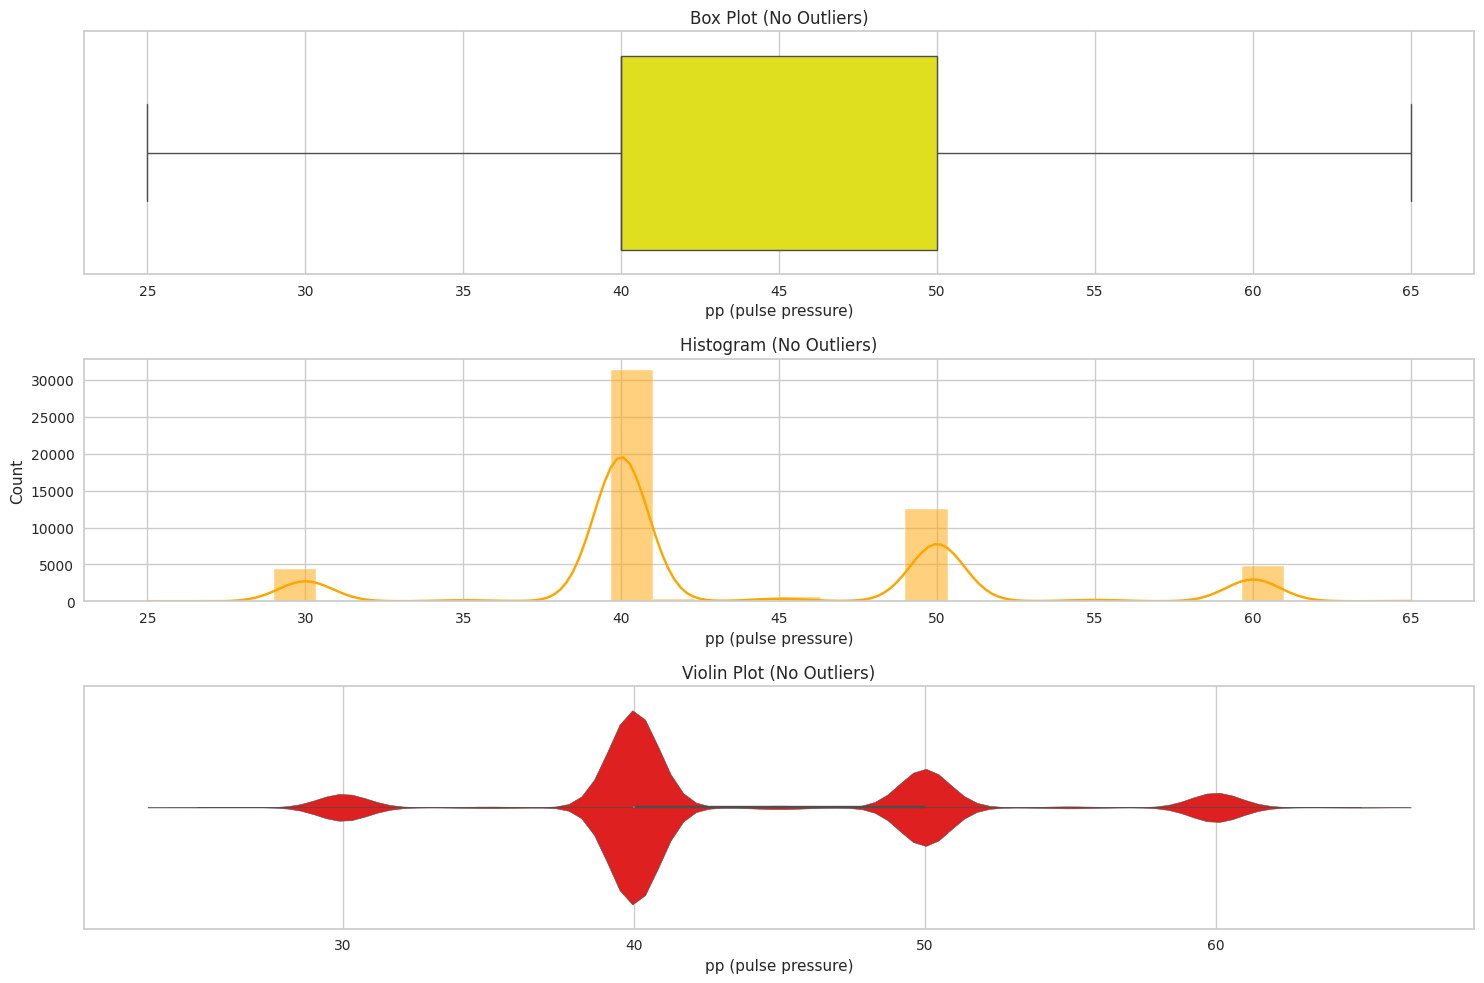

In [29]:
# Remove outliers
healthData = healthData[
    (healthData['pp (pulse pressure)'] >= lower_whisker) &
    (healthData['pp (pulse pressure)'] <= upper_whisker)
]
print(f"Shape after removing outliers: {healthData.shape}")

# Plot without outliers
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

sb.boxplot(x=healthData['pp (pulse pressure)'], ax=axes[0], color='yellow')
axes[0].set_title('Box Plot (No Outliers)')

sb.histplot(healthData['pp (pulse pressure)'], ax=axes[1], color='orange', kde=True, bins=30)
axes[1].set_title('Histogram (No Outliers)')

sb.violinplot(x=healthData['pp (pulse pressure)'], ax=axes[2], color='red')
axes[2].set_title('Violin Plot (No Outliers)')

plt.tight_layout()
plt.show()

In [30]:
healthData.shape

(55094, 15)

## Blood Pressure (BP)

Based on medical standards, we will categorise Blood Pressure into different stages as follows:

    Normal Blood Pressure:
        Systolic: Less than 120 mm Hg
        Diastolic: Less than 80 mm Hg

    Elevated Blood Pressure:
        Systolic: 120-129 mm Hg
        Diastolic: Less than 80 mm Hg

    Hypertension Stage 1:
        Systolic: 130-139 mm Hg
        Diastolic: 80-89 mm Hg

    Hypertension Stage 2:
        Systolic: 140 mm Hg or higher
        Diastolic: 90 mm Hg or higher
        
    Hypertensive Crisis:
        Systolic: Higher than 180 mm Hg
        Diastolic: Higher than 120 mm Hg

Blood Pressure Category Value Counts:
Blood Pressure Category
Normal Blood Pressure       6651.0
Elevated Blood Pressure     2475.0
Hypertension Stage 1       35593.0
Hypertension Stage 2       10375.0
Hypertensive Crisis            NaN
Uncategorised                  NaN
Name: count, dtype: float64


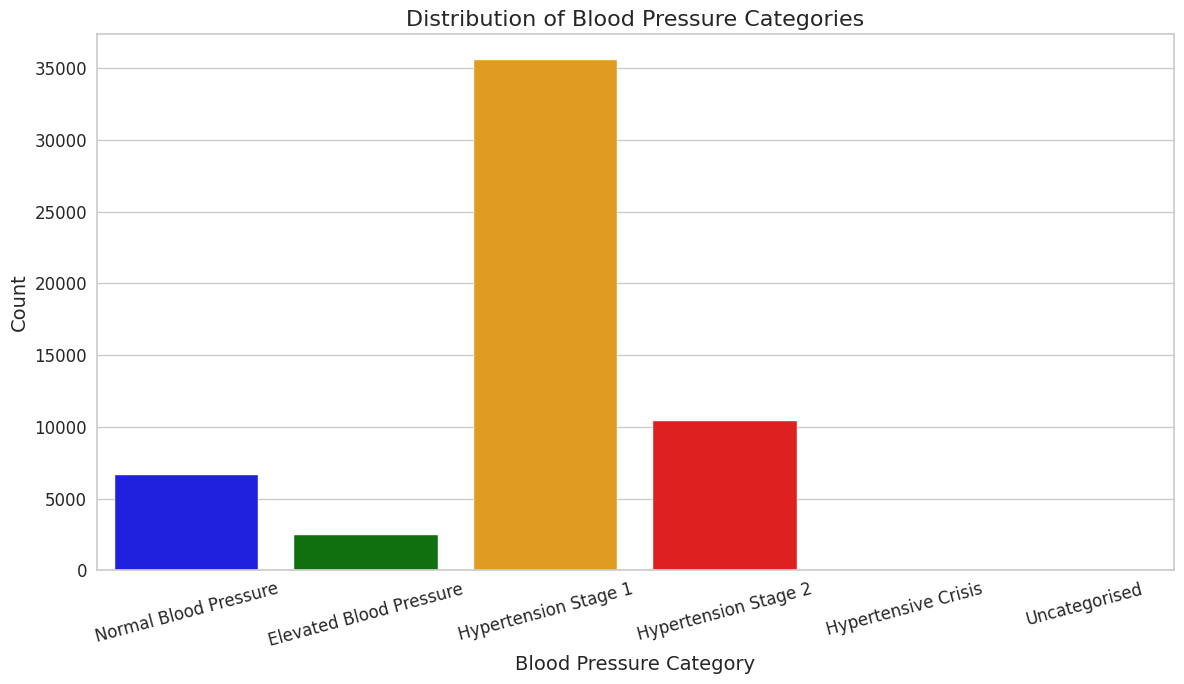

In [31]:
# Categorizing Blood Pressure based on Normal, Elevated, Hypertension Stages, and Hypertensive Crisis
# Adding an "Uncategorised" category for cases that do not fit the given conditions
bp_categories = []

for index, row in healthData.iterrows():
    systolic = row['ap_hi (systolic blood pressure)']
    diastolic = row['ap_lo (diastolic blood pressure)']

    if systolic < 120 and diastolic < 80:
        bp_categories.append('Normal Blood Pressure')
    elif 120 <= systolic <= 129 and diastolic < 80:
        bp_categories.append('Elevated Blood Pressure')
    elif 130 <= systolic <= 139 or 80 <= diastolic <= 89:
        bp_categories.append('Hypertension Stage 1')
    elif systolic >= 140 or diastolic >= 90:
        if systolic > 180 or diastolic > 120:
            bp_categories.append('Hypertensive Crisis')
        else:
            bp_categories.append('Hypertension Stage 2')
    else:
        bp_categories.append('Uncategorised')

# Adding this categorization as a new column in the DataFrame
healthData['Blood Pressure Category'] = bp_categories

# Counting each Blood Pressure category value
bp_category_counts = healthData['Blood Pressure Category'].value_counts()

# Reordering the categories to be in the desired order
ordered_bp_categories = [
    'Normal Blood Pressure',
    'Elevated Blood Pressure',
    'Hypertension Stage 1',
    'Hypertension Stage 2',
    'Hypertensive Crisis',
    'Uncategorised'
]
bp_category_counts = bp_category_counts.reindex(ordered_bp_categories)

# Display the split-up data based on Blood Pressure categories
print("Blood Pressure Category Value Counts:")
print(bp_category_counts)

# Creating a plot with distinct colors for the Blood Pressure Categories
plt.figure(figsize=(12, 7))
sb.barplot(x=bp_category_counts.index, y=bp_category_counts.values, palette=["blue", "green", "orange", "red", "maroon", "grey"])
plt.title('Distribution of Blood Pressure Categories', fontsize=16)
plt.xlabel('Blood Pressure Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12, rotation=15)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


## Cholesterol Levels
Based on medical standards, we will categorise Cholesterol into different stages as follows:

    Normal Cholestorol Levels: Less than 200 mg/dL

    Above Normal Cholestorol Levels: 200-239 mg/dL

    Well Above Normal Cholestorol Levels: 240 mg/dL or higher


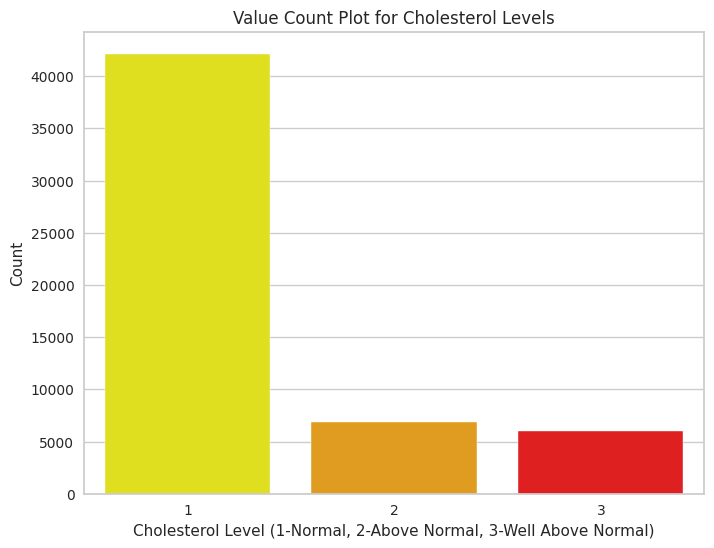


Cholesterol Levels Counts and Meanings:
Level 1: Normal cholesterol - 42145 individuals
Level 2: Above normal cholesterol - 6903 individuals
Level 3: Well above normal cholesterol - 6046 individuals


In [32]:
# Creating a count plot for 'cholesterol'
plt.figure(figsize=(8, 6))
cholesterol_colors = ['yellow', 'orange', 'red']
sb.countplot(x=healthData['cholesterol (1- normal, 2 - above normal, 3- well above normal)'], palette=cholesterol_colors)
plt.title('Value Count Plot for Cholesterol Levels')
plt.xlabel('Cholesterol Level (1-Normal, 2-Above Normal, 3-Well Above Normal)')
plt.ylabel('Count')
plt.show()

# Counting unique values for the 'cholesterol level' column and providing their significance
cholesterol_counts = healthData['cholesterol (1- normal, 2 - above normal, 3- well above normal)'].value_counts()

print("\nCholesterol Levels Counts and Meanings:")
for level, count in cholesterol_counts.items():
    if level == 1:
        print(f"Level {level}: Normal cholesterol - {count} individuals")
    elif level == 2:
        print(f"Level {level}: Above normal cholesterol - {count} individuals")
    elif level == 3:
        print(f"Level {level}: Well above normal cholesterol - {count} individuals")

## Glucose Levels

Based on medical standards, we will categorise Glucose Levels into different stages as follows:
    
    Normal Glucose Levels: 70-100 mg/dL

    Above Normal Glucose Levels: 100-125 mg/dL

    Well Above Normal Glucose Levels: 126 mg/dL and above

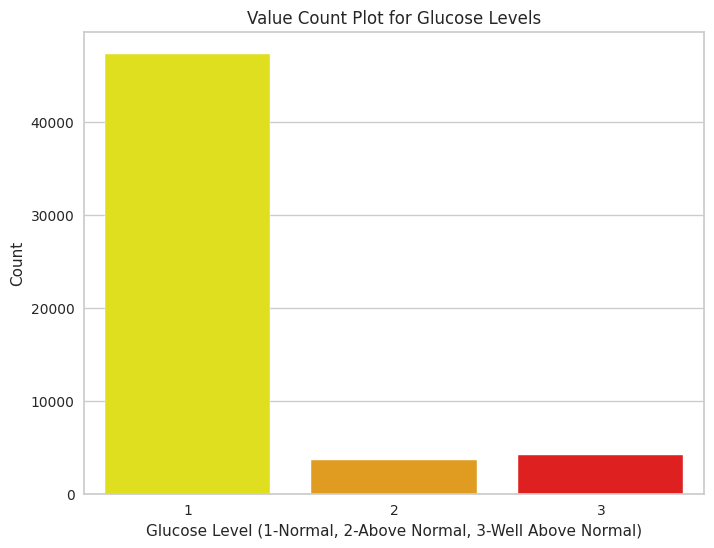


Glucose Levels Counts and Meanings:
Level 1: Normal glucose level - 47291 individuals
Level 3: Well above normal glucose level - 4157 individuals
Level 2: Above normal glucose level - 3646 individuals


In [33]:
# Creating a count plot for 'gluc'
plt.figure(figsize=(8, 6))
gluc_colors = ['yellow', 'orange', 'red']
sb.countplot(x=healthData['gluc (1- normal, 2 - above normal, 3- well above normal)'], palette=gluc_colors)
plt.title('Value Count Plot for Glucose Levels')
plt.xlabel('Glucose Level (1-Normal, 2-Above Normal, 3-Well Above Normal)')
plt.ylabel('Count')
plt.show()

# Counting unique values for the 'gluc' column and providing their significance
gluc_counts = healthData['gluc (1- normal, 2 - above normal, 3- well above normal)'].value_counts()

print("\nGlucose Levels Counts and Meanings:")
for level, count in gluc_counts.items():
    if level == 1:
        print(f"Level {level}: Normal glucose level - {count} individuals")
    elif level == 2:
        print(f"Level {level}: Above normal glucose level - {count} individuals")
    elif level == 3:
        print(f"Level {level}: Well above normal glucose level - {count} individuals")

## Gender

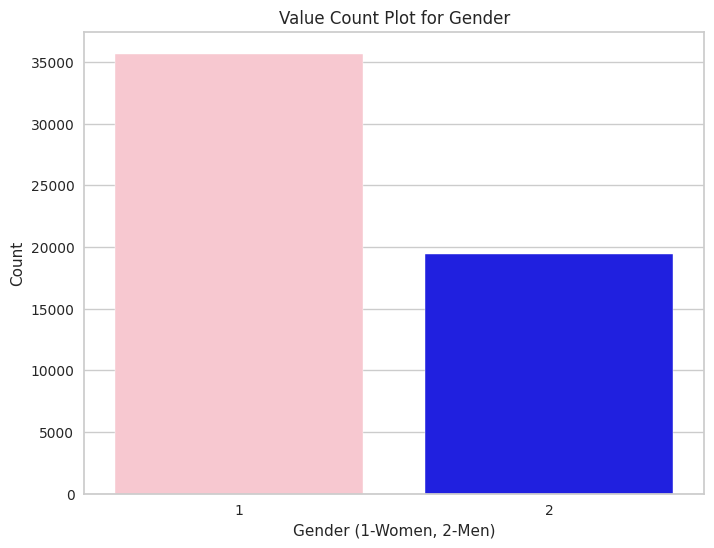


Gender Counts and Meanings:
Gender 1: Women - 35669 individuals
Gender 2: Men - 19425 individuals


In [34]:
# Creating a count plot for 'gender'
plt.figure(figsize=(8, 6))
gender_colors = ['pink', 'blue']
sb.countplot(x=healthData['gender( 1 for Women, 2 for Men)'], palette=gender_colors)
plt.title('Value Count Plot for Gender')
plt.xlabel('Gender (1-Women, 2-Men)')
plt.ylabel('Count')
plt.show()

# Counting unique values for the 'gender' column and providing their significance
gender_counts = healthData['gender( 1 for Women, 2 for Men)'].value_counts()

print("\nGender Counts and Meanings:")
for gender, count in gender_counts.items():
    if gender == 1:
        print(f"Gender {gender}: Women - {count} individuals")
    elif gender == 2:
        print(f"Gender {gender}: Men - {count} individuals")

## Smoking Habits

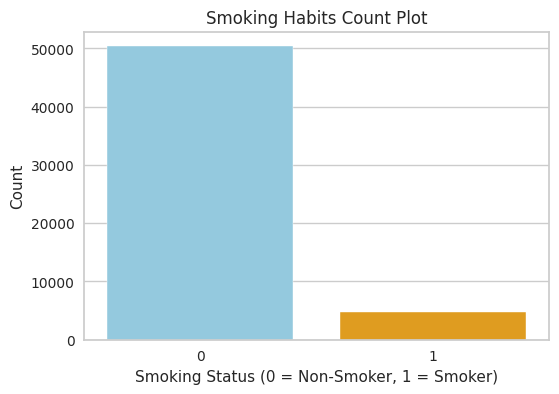


Smoking Habits Counts and Meanings:
Smoke 0: Does not smoke - 50352 individuals
Smoke 1: Smokes - 4742 individuals


In [35]:
# Counting unique values for 'smoke (0 - does not smoke, 1 - smokes)' column
smoke_counts = healthData['smoke (0 - does not smoke, 1 - smokes)'].value_counts()

plt.figure(figsize=(6, 4))
sb.countplot(x='smoke (0 - does not smoke, 1 - smokes)', data=healthData, palette=['skyblue', 'orange'])
plt.title("Smoking Habits Count Plot")
plt.xlabel("Smoking Status (0 = Non-Smoker, 1 = Smoker)")
plt.ylabel("Count")
plt.show()

# Counting unique values for the 'smoke (0 - does not smoke, 1 - smokes)' column and providing their significance
smoke_counts = healthData['smoke (0 - does not smoke, 1 - smokes)'].value_counts()

print("\nSmoking Habits Counts and Meanings:")
for smoke, count in smoke_counts.items():
    if smoke == 0:
        print(f"Smoke {smoke}: Does not smoke - {count} individuals")
    elif smoke == 1:
        print(f"Smoke {smoke}: Smokes - {count} individuals")

## Alcohol Consumption

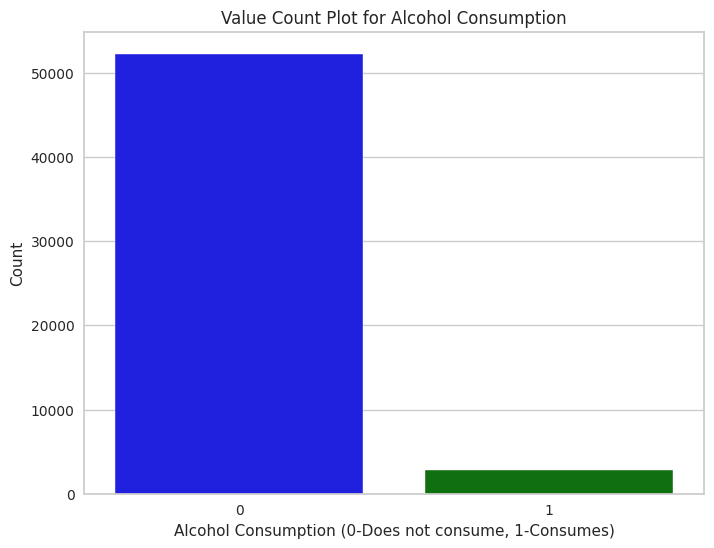


Alcohol Consumption Counts and Meanings:
Alcohol Consumption 0: Does not consume alcohol - 52269 individuals
Alcohol Consumption 1: Consumes alcohol - 2825 individuals


In [36]:
# Creating a count plot for 'alco'
plt.figure(figsize=(8, 6))
alco_colors = ['blue', 'green']
sb.countplot(x=healthData['alco (0 - does not alcohol, 1 - consumes alcohol)'], palette=alco_colors)
plt.title('Value Count Plot for Alcohol Consumption')
plt.xlabel('Alcohol Consumption (0-Does not consume, 1-Consumes)')
plt.ylabel('Count')
plt.show()

# Counting unique values for the 'alco' column and providing their significance
alco_counts = healthData['alco (0 - does not alcohol, 1 - consumes alcohol)'].value_counts()

print("\nAlcohol Consumption Counts and Meanings:")
for alco, count in alco_counts.items():
    if alco == 0:
        print(f"Alcohol Consumption {alco}: Does not consume alcohol - {count} individuals")
    elif alco == 1:
        print(f"Alcohol Consumption {alco}: Consumes alcohol - {count} individuals")

## Exercise Activity

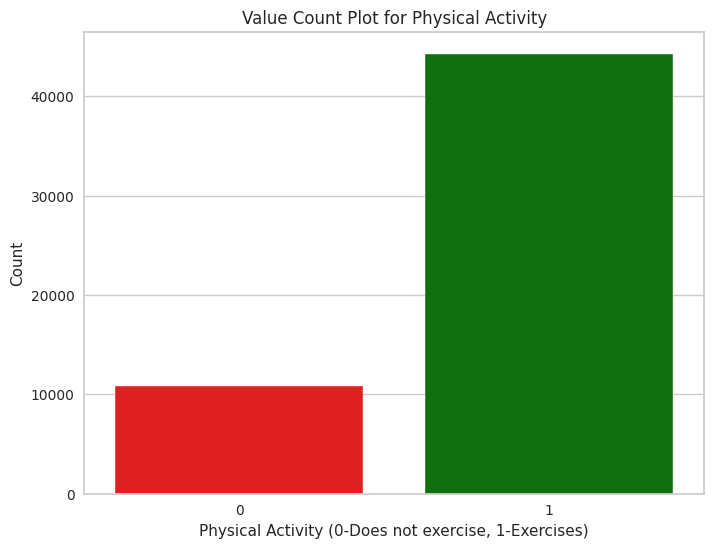


Physical Activity Levels Counts and Meanings:
Activity Level 1: Exercises - 44289 individuals
Activity Level 0: Does not exercise - 10805 individuals


In [37]:
# Creating a count plot for 'active (0 - does not exercise, 1 - exercises)'
plt.figure(figsize=(8, 6))
active_colors = ['red', 'green']
sb.countplot(x=healthData['active (0 - does not exercise, 1 - exercises)'], palette=active_colors)
plt.title('Value Count Plot for Physical Activity')
plt.xlabel('Physical Activity (0-Does not exercise, 1-Exercises)')
plt.ylabel('Count')
plt.show()

# Counting unique values for the 'active' column and providing their significance
active_counts = healthData['active (0 - does not exercise, 1 - exercises)'].value_counts()

print("\nPhysical Activity Levels Counts and Meanings:")
for activity, count in active_counts.items():
    if activity == 0:
        print(f"Activity Level {activity}: Does not exercise - {count} individuals")
    elif activity == 1:
        print(f"Activity Level {activity}: Exercises - {count} individuals")

## Cardiovascular Disease

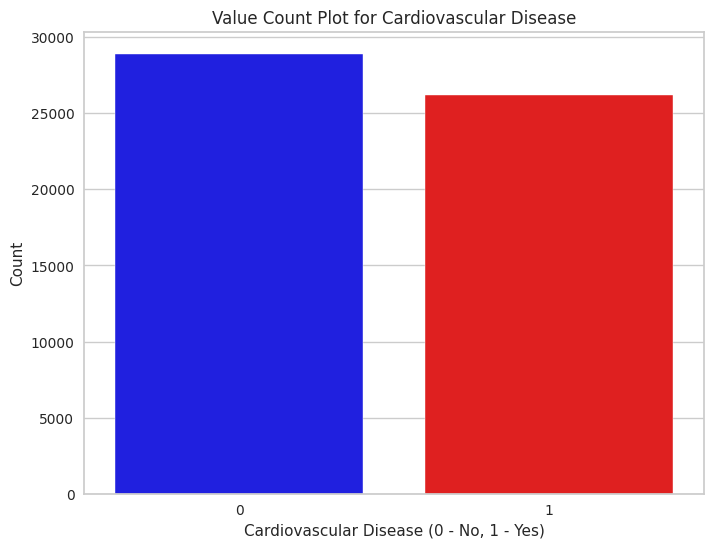


Cardiovascular Disease Counts and Meanings:
Status 0: No cardiovascular disease - 28907 individuals
Status 1: Has cardiovascular disease - 26187 individuals


In [38]:
# Creating a count plot for 'cardio'
plt.figure(figsize=(8, 6))
cardio_colors = ['blue', 'red']
sb.countplot(x=healthData['cardio (0 - no cardiovascular disease, 1 -has cardiovascular disease)'], palette=cardio_colors)
plt.title('Value Count Plot for Cardiovascular Disease')
plt.xlabel('Cardiovascular Disease (0 - No, 1 - Yes)')
plt.ylabel('Count')
plt.show()

# Counting unique values for the 'cardio' column and providing their significance
cardio_counts = healthData['cardio (0 - no cardiovascular disease, 1 -has cardiovascular disease)'].value_counts()

print("\nCardiovascular Disease Counts and Meanings:")
for status, count in cardio_counts.items():
    if status == 0:
        print(f"Status {status}: No cardiovascular disease - {count} individuals")
    elif status == 1:
        print(f"Status {status}: Has cardiovascular disease - {count} individuals")

## Sorting Age, BMI, MAP, and Pulse Pressure into different categories and plotting their barplots:
    Age
    18-29
    30-39
    40-49
    50-59
    60-69
    70+

    BMI
    Underweight: Less than 18.5
    Normal weight: 18.5 to 24.9
    Overweight: 25 to 29.9
    Obesity: 30 or more

    MAP
    Low MAP: Less than 70mmHg
    Normal MAP: Between 70mmHg and 100mmHg
    High MAP: Greater than 100mmHg

    Pulse Pressure
    Low pulse pressure: Less than 40mmHg
    Normal pulse pressure: Between 40mmHg and 60mmHg
    High pulse pressure: Greater than 60mmHg

Age Category Value Counts:

 Age Category
18-29        NaN
30-39        NaN
40-49    15978.0
50-59    28873.0
60-69    10243.0
70+          NaN
Name: count, dtype: float64


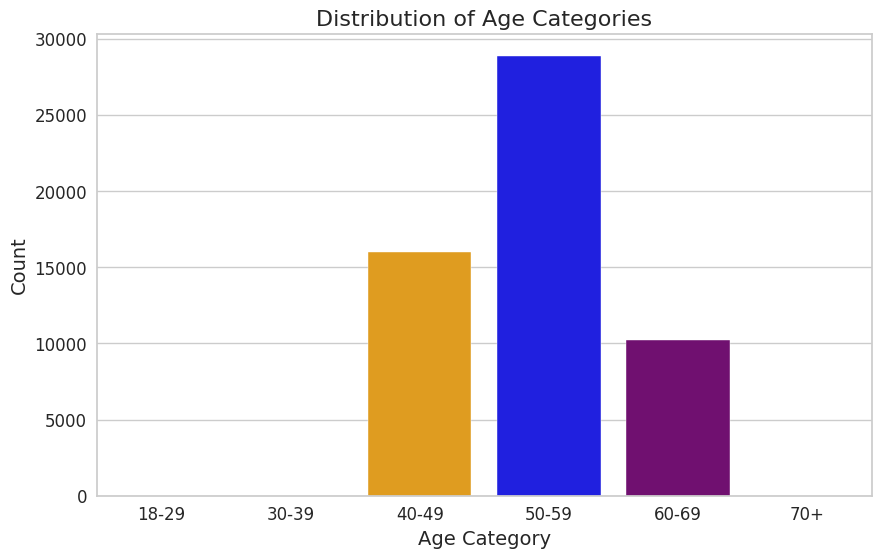

BMI Category Value Counts:

 BMI Category
Underweight        409
Normal weight    21431
Overweight       20972
Obesity          12282
Name: count, dtype: int64


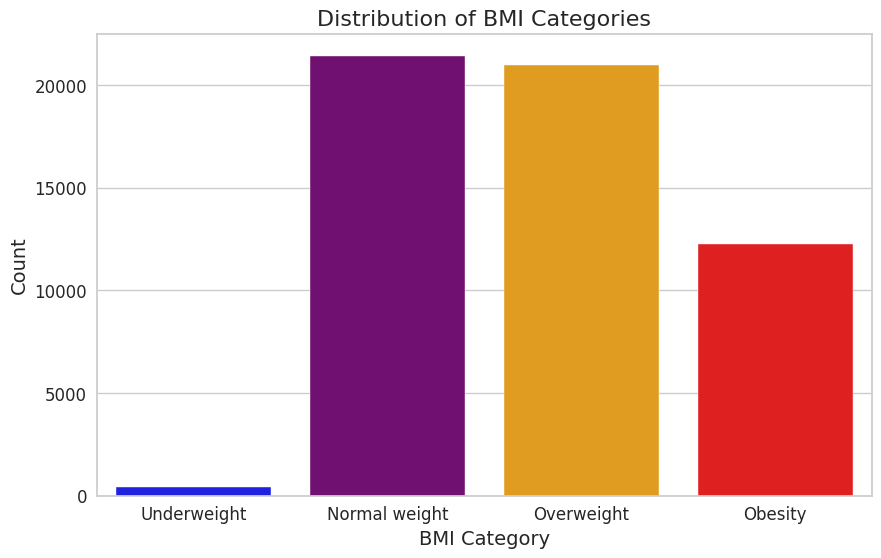

MAP Category Value Counts:
MAP Category
Low MAP           NaN
Normal MAP    42106.0
High MAP      12988.0
Name: count, dtype: float64


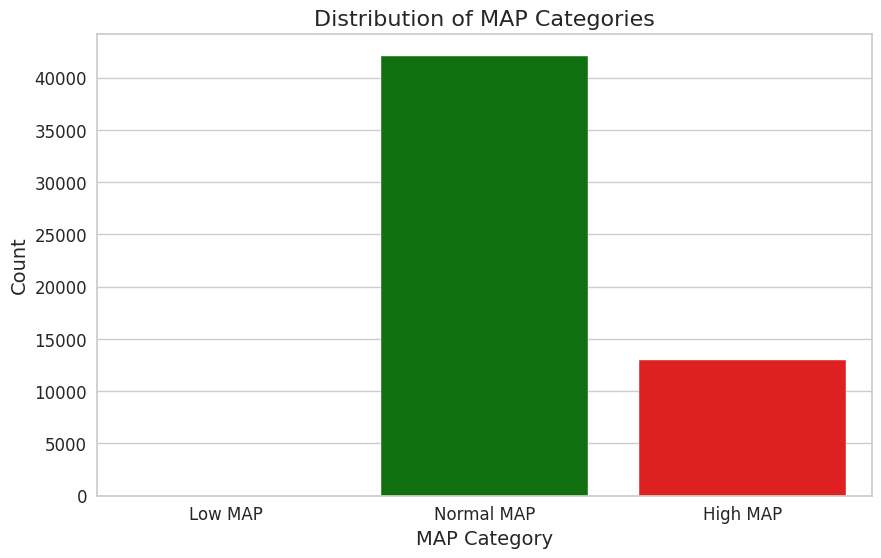

Pulse Pressure Category Value Counts:
Pulse Pressure Category
Low Pulse Pressure        4851
Normal Pulse Pressure    50066
High Pulse Pressure        177
Name: count, dtype: int64


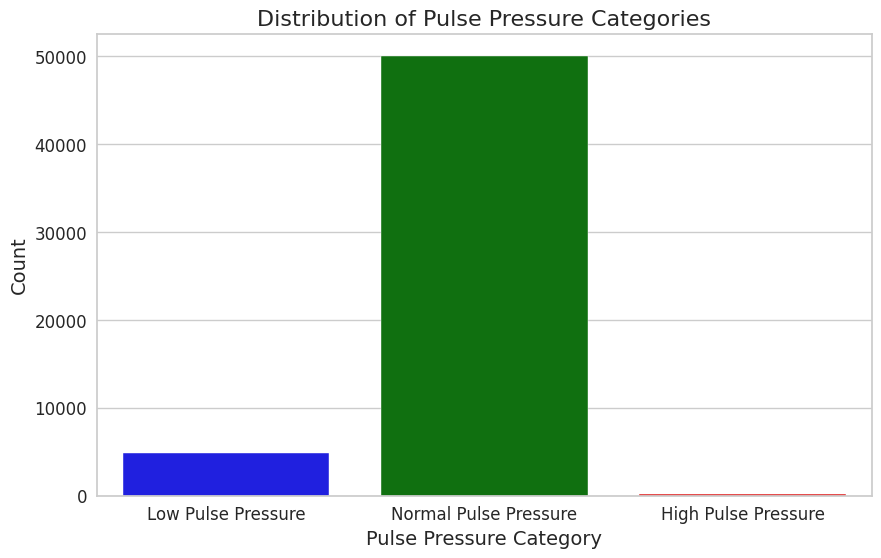

In [39]:
# Categorising the age into different categories: 'age (in years) bracket': ['18-29', '30-39', '40-49', '50-59', '60-69', '70+'],
age_categories = []

for age in healthData['age (in years)']:
    if age < 30:
        age_categories.append('18-29')
    elif age < 40:
        age_categories.append('30-39')
    elif age < 50:
        age_categories.append('40-49')
    elif age < 60:
        age_categories.append('50-59')
    elif age < 70:
        age_categories.append('60-69')
    else:
        age_categories.append('70+')

# Adding this categorization as a new column in the DataFrame
healthData['Age Category'] = age_categories

# Counting each category value
age_category_counts = healthData['Age Category'].value_counts()

# Reordering the categories to be in the desired order
ordered_age_categories = ['18-29', '30-39', '40-49', '50-59', '60-69', '70+']
age_category_counts = age_category_counts.reindex(ordered_age_categories)

# Display the split-up data based on age categories
print("Age Category Value Counts:")
print("\n",age_category_counts)

# Creating a plot with 3 different colors for the Age Categories
plt.figure(figsize=(10, 6))
sb.barplot(x=age_category_counts.index, y=age_category_counts.values, palette=["blue", "purple", "orange"])
plt.title('Distribution of Age Categories', fontsize=16)
plt.xlabel('Age Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


# Categorizing the BMI into different categories: Underweight, Normal weight, Overweight, and Obesity
bmi_categories = []

for bmi in healthData['bmi (body mass index)']:
    if bmi < 18.5:
        bmi_categories.append('Underweight')
    elif bmi < 25:
        bmi_categories.append('Normal weight')
    elif bmi < 30:
        bmi_categories.append('Overweight')
    else:
        bmi_categories.append('Obesity')

# Adding this categorization as a new column in the DataFrame
healthData['BMI Category'] = bmi_categories

# Counting each category value
bmi_category_counts = healthData['BMI Category'].value_counts()

# Reordering the categories to be in the desired order
ordered_categories = ['Underweight', 'Normal weight', 'Overweight', 'Obesity']
bmi_category_counts = bmi_category_counts.reindex(ordered_categories)

# Display the split-up data based on BMI categories
print("BMI Category Value Counts:")
print("\n",bmi_category_counts)

# Creating a bar plot with 4 different colors for the BMI Categories
plt.figure(figsize=(10, 6))
sb.barplot(x=bmi_category_counts.index, y=bmi_category_counts.values, palette=["blue", "purple", "orange", "red"])
plt.title('Distribution of BMI Categories', fontsize=16)
plt.xlabel('BMI Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


# Categorizing the MAP into Low, Normal, and High categories
map_categories = []

for map_value in healthData['map (mean arterial pressure)']:
    if map_value < 70:
        map_categories.append('Low MAP')
    elif 70 <= map_value <= 100:
        map_categories.append('Normal MAP')
    else:
        map_categories.append('High MAP')

# Adding this categorization as a new column in the DataFrame
healthData['MAP Category'] = map_categories

# Counting each MAP category value
map_category_counts = healthData['MAP Category'].value_counts()

# Reordering the categories to be in the desired order
ordered_map_categories = ['Low MAP', 'Normal MAP', 'High MAP']
map_category_counts = map_category_counts.reindex(ordered_map_categories)

# Display the split-up data based on MAP categories
print("MAP Category Value Counts:")
print(map_category_counts)

# Creating a plot with 3 different colors for the MAP Categories
plt.figure(figsize=(10, 6))
sb.barplot(x=map_category_counts.index, y=map_category_counts.values, palette=["blue", "green", "red"])
plt.title('Distribution of MAP Categories', fontsize=16)
plt.xlabel('MAP Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


# Categorizing the Pulse Pressure into Low, Normal, and High categories
pp_categories = []

for pp_value in healthData['pp (pulse pressure)']:
    if pp_value < 40:
        pp_categories.append('Low Pulse Pressure')
    elif 40 <= pp_value <= 60:
        pp_categories.append('Normal Pulse Pressure')
    else:
        pp_categories.append('High Pulse Pressure')

# Adding this categorization as a new column in the DataFrame
healthData['Pulse Pressure Category'] = pp_categories

# Counting each Pulse Pressure category value
pp_category_counts = healthData['Pulse Pressure Category'].value_counts()

# Reordering the categories to be in the desired order
ordered_pp_categories = ['Low Pulse Pressure', 'Normal Pulse Pressure', 'High Pulse Pressure']
pp_category_counts = pp_category_counts.reindex(ordered_pp_categories)

# Display the split-up data based on Pulse Pressure categories
print("Pulse Pressure Category Value Counts:")
print(pp_category_counts)

# Creating a plot with 3 different colors for the Pulse Pressure Categories
plt.figure(figsize=(10, 6))
sb.barplot(x=pp_category_counts.index, y=pp_category_counts.values, palette=["blue", "green", "red"])
plt.title('Distribution of Pulse Pressure Categories', fontsize=16)
plt.xlabel('Pulse Pressure Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Now, recheck how the dataframe looks like after cleaning up the data.

In [40]:
healthData.describe(include='all')

,age (in years),height (in m),weight (in kg),bmi (body mass index),ap_hi (systolic blood pressure),ap_lo (diastolic blood pressure),map (mean arterial pressure),pp (pulse pressure),"cholesterol (1- normal, 2 - above normal, 3- well above normal)","gluc (1- normal, 2 - above normal, 3- well above normal)","gender( 1 for Women, 2 for Men)","smoke (0 - does not smoke, 1 - smokes)","alco (0 - does not alcohol, 1 - consumes alcohol)","active (0 - does not exercise, 1 - exercises)","cardio (0 - no cardiovascular disease, 1 -has cardiovascular disease)",Blood Pressure Category,Age Category,BMI Category,MAP Category,Pulse Pressure Category
count,55094.0000,55094.0000,55094.0000,55094.0000,55094.0000,55094.0000,55094.0000,55094.0000,55094.0000,55094.0000,55094.0000,55094.0000,55094.0000,55094.0000,55094.0000,55094,55094,55094,55094,55094
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3,4,2,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hypertension Stage 1,50-59,Normal weight,Normal MAP,Normal Pulse Pressure
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35593,28873,21431,42106,50066
mean,53.6125,1.6460,72.5404,26.7936,124.6166,81.2006,95.6715,43.4160,1.3448,1.2171,1.3526,0.0861,0.0513,0.8039,0.4753,NaN,NaN,NaN,NaN,NaN
std,6.4535,0.0744,11.7367,4.1581,11.4881,7.1999,8.1069,7.6029,0.6674,0.5665,0.4778,0.2805,0.2206,0.3971,0.4994,NaN,NaN,NaN,NaN,NaN
min,40.0000,1.4300,40.0000,15.0900,95.0000,65.0000,78.3300,25.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN
25%,49.4800,1.6000,65.0000,23.8100,120.0000,80.0000,93.3300,40.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,0.0000,NaN,NaN,NaN,NaN,NaN
50%,54.0600,1.6500,71.0000,26.0400,120.0000,80.0000,93.3300,40.0000,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,0.0000,NaN,NaN,NaN,NaN,NaN
75%,58.4400,1.7000,80.0000,29.4000,130.0000,87.0000,100.0000,50.0000,1.0000,1.0000,2.0000,0.0000,0.0000,1.0000,1.0000,NaN,NaN,NaN,NaN,NaN


In [41]:
healthData.head(20)

,age (in years),height (in m),weight (in kg),bmi (body mass index),ap_hi (systolic blood pressure),ap_lo (diastolic blood pressure),map (mean arterial pressure),pp (pulse pressure),"cholesterol (1- normal, 2 - above normal, 3- well above normal)","gluc (1- normal, 2 - above normal, 3- well above normal)","gender( 1 for Women, 2 for Men)","smoke (0 - does not smoke, 1 - smokes)","alco (0 - does not alcohol, 1 - consumes alcohol)","active (0 - does not exercise, 1 - exercises)","cardio (0 - no cardiovascular disease, 1 -has cardiovascular disease)",Blood Pressure Category,Age Category,BMI Category,MAP Category,Pulse Pressure Category
0,50.39,1.68,62.0,21.97,110,80,90.00,30,1,1,2,0,0,1,0,Hypertension Stage 1,50-59,Normal weight,Normal MAP,Low Pulse Pressure
1,55.42,1.56,85.0,34.93,140,90,106.67,50,3,1,1,0,0,1,1,Hypertension Stage 2,50-59,Obesity,High MAP,Normal Pulse Pressure
2,51.66,1.65,64.0,23.51,130,70,90.00,60,3,1,1,0,0,0,1,Hypertension Stage 1,50-59,Normal weight,Normal MAP,Normal Pulse Pressure
3,48.28,1.69,82.0,28.71,150,100,116.67,50,1,1,2,0,0,1,1,Hypertension Stage 2,40-49,Overweight,High MAP,Normal Pulse Pressure
5,60.04,1.51,67.0,29.38,120,80,93.33,40,2,2,1,0,0,0,0,Hypertension Stage 1,60-69,Overweight,Normal MAP,Normal Pulse Pressure
6,60.58,1.57,93.0,37.73,130,80,96.67,50,3,1,1,0,0,1,0,Hypertension Stage 1,60-69,Obesity,Normal MAP,Normal Pulse Pressure
7,61.87,1.78,95.0,29.98,130,90,103.33,40,3,3,2,0,0,1,1,Hypertension Stage 1,60-69,Overweight,High MAP,Normal Pulse Pressure
8,48.41,1.58,71.0,28.44,110,70,83.33,40,1,1,1,0,0,1,0,Normal Blood Pressure,40-49,Overweight,Normal MAP,Normal Pulse Pressure
10,61.73,1.69,80.0,28.01,120,80,93.33,40,1,1,1,0,0,1,0,Hypertension Stage 1,60-69,Overweight,Normal MAP,Normal Pulse Pressure
11,51.55,1.73,60.0,20.05,120,80,93.33,40,1,1,2,0,0,1,0,Hypertension Stage 1,50-59,Normal weight,Normal MAP,Normal Pulse Pressure


## Convert the categorical data into ordinal versions of the data
Blood Pressure
Normal: 0
Elevated: 1
Hypertension Stage 1: 2
Hypertension Stage 2: 3
Hypertensive Crisis: 4
Uncategorised: -1

BMI
Underweight: 0
Normal weight: 1
Overweight: 2
Obesity: 3

MAP
Low MAP: 0
Normal MAP: 1
High MAP: 2

Pulse Pressure
Low Pulse Pressure: 0
Normal Pulse Pressure: 1
High Pulse Pressure: 2

Age
40-50: 0
50-60: 1
60-70: 2
70+: 3

### Then, add the new ordinal variable columns to the dataframe


In [42]:
# ===============================
# 1. Create Categorical Columns
# ===============================

# -- Age Category --
# Create age brackets based on 'age (in years)'
def age_category(age):
    if 40 <= age < 50:
        return '40-50'
    elif 50 <= age < 60:
        return '50-60'
    elif 60 <= age < 70:
        return '60-70'
    else:
        return '70+'

# Apply the function to create a new column for age brackets
healthData['age (in years) bracket'] = healthData['age (in years)'].apply(age_category)

# -- BMI Category --
bmi_categories = []
for bmi in healthData['bmi (body mass index)']:
    if bmi < 18.5:
        bmi_categories.append('Underweight')
    elif 18.5 <= bmi <= 24.9:
        bmi_categories.append('Normal weight')
    elif 25 <= bmi <= 29.9:
        bmi_categories.append('Overweight')
    else:
        bmi_categories.append('Obesity')
healthData['BMI Category'] = bmi_categories

# -- MAP Category --
map_categories = []
for map_value in healthData['map (mean arterial pressure)']:
    if map_value < 70:
        map_categories.append('Low MAP')
    elif 70 <= map_value <= 100:
        map_categories.append('Normal MAP')
    else:
        map_categories.append('High MAP')
healthData['MAP Category'] = map_categories

# -- Pulse Pressure Category --
pp_categories = []
for pp_value in healthData['pp (pulse pressure)']:
    if pp_value < 40:
        pp_categories.append('Low Pulse Pressure')
    elif 40 <= pp_value <= 60:
        pp_categories.append('Normal Pulse Pressure')
    else:
        pp_categories.append('High Pulse Pressure')
healthData['Pulse Pressure Category'] = pp_categories

# ==========================================
# 2. Convert Categorical Columns to Numbers
# ==========================================

# -- BMI Category Numeric --
bmi_mapping = {
    'Underweight': 0,
    'Normal weight': 1,
    'Overweight': 2,
    'Obesity': 3
}
healthData['BMI Category Numeric'] = healthData['BMI Category'].map(bmi_mapping)

# -- MAP Category Numeric --
map_mapping = {
    'Low MAP': 0,
    'Normal MAP': 1,
    'High MAP': 2
}
healthData['MAP Category Numeric'] = healthData['MAP Category'].map(map_mapping)

# -- Pulse Pressure Category Numeric --
pp_mapping = {
    'Low Pulse Pressure': 0,
    'Normal Pulse Pressure': 1,
    'High Pulse Pressure': 2
}
healthData['Pulse Pressure Category Numeric'] = healthData['Pulse Pressure Category'].map(pp_mapping)

# -- Blood Pressure Category Numeric --
bp_mapping = {
    'Normal Blood Pressure': 0,
    'Elevated Blood Pressure': 1,
    'Hypertension Stage 1': 2,
    'Hypertension Stage 2': 3,
    'Hypertensive Crisis': 4,
    'Uncategorised': -1
}
healthData['BP Category Numeric'] = healthData['Blood Pressure Category'].map(bp_mapping)

# -- Age Category Numeric --
age_mapping = {
    '40-50': 0,
    '50-60': 1,
    '60-70': 2,
    '70+': 3
}
healthData['age (in years) bracket numeric'] = healthData['age (in years) bracket'].map(age_mapping)

In [43]:
healthData.head(20)

,age (in years),height (in m),weight (in kg),bmi (body mass index),ap_hi (systolic blood pressure),ap_lo (diastolic blood pressure),map (mean arterial pressure),pp (pulse pressure),"cholesterol (1- normal, 2 - above normal, 3- well above normal)","gluc (1- normal, 2 - above normal, 3- well above normal)",...,Age Category,BMI Category,MAP Category,Pulse Pressure Category,age (in years) bracket,BMI Category Numeric,MAP Category Numeric,Pulse Pressure Category Numeric,BP Category Numeric,age (in years) bracket numeric
0,50.39,1.68,62.0,21.97,110,80,90.00,30,1,1,...,50-59,Normal weight,Normal MAP,Low Pulse Pressure,50-60,1,1,0,2,1
1,55.42,1.56,85.0,34.93,140,90,106.67,50,3,1,...,50-59,Obesity,High MAP,Normal Pulse Pressure,50-60,3,2,1,3,1
2,51.66,1.65,64.0,23.51,130,70,90.00,60,3,1,...,50-59,Normal weight,Normal MAP,Normal Pulse Pressure,50-60,1,1,1,2,1
3,48.28,1.69,82.0,28.71,150,100,116.67,50,1,1,...,40-49,Overweight,High MAP,Normal Pulse Pressure,40-50,2,2,1,3,0
5,60.04,1.51,67.0,29.38,120,80,93.33,40,2,2,...,60-69,Overweight,Normal MAP,Normal Pulse Pressure,60-70,2,1,1,2,2
6,60.58,1.57,93.0,37.73,130,80,96.67,50,3,1,...,60-69,Obesity,Normal MAP,Normal Pulse Pressure,60-70,3,1,1,2,2
7,61.87,1.78,95.0,29.98,130,90,103.33,40,3,3,...,60-69,Obesity,High MAP,Normal Pulse Pressure,60-70,3,2,1,2,2
8,48.41,1.58,71.0,28.44,110,70,83.33,40,1,1,...,40-49,Overweight,Normal MAP,Normal Pulse Pressure,40-50,2,1,1,0,0
10,61.73,1.69,80.0,28.01,120,80,93.33,40,1,1,...,60-69,Overweight,Normal MAP,Normal Pulse Pressure,60-70,2,1,1,2,2
11,51.55,1.73,60.0,20.05,120,80,93.33,40,1,1,...,50-59,Normal weight,Normal MAP,Normal Pulse Pressure,50-60,1,1,1,2,1


## We will now cross tabulate cardiovascular disease against all other variables to see each variable's relationship with having cardiovascular disease or not.

### Variables:
BP Category Numeric 
BMI Category Numeric
MAP Category Numeric
Pulse Pressure Category Numeric
cholesterol (1- normal, 2 - above normal, 3- well above normal)
gluc (1- normal, 2 - above normal, 3- well above normal)
smoke (0 - does not smoke, 1 - smokes)
alco (0 - does not alcohol, 1 - consumes alcohol)
active (0 - does not exercise, 1 - exercises)
age (in years) bracket
gender( 1 for Women, 2 for Men)
cardio (0 - no cardiovascular disease, 1 -has cardiovascular disease)

## We will now cross tabulate cardiovascular disease against the other variables

<Figure size 1200x800 with 0 Axes>

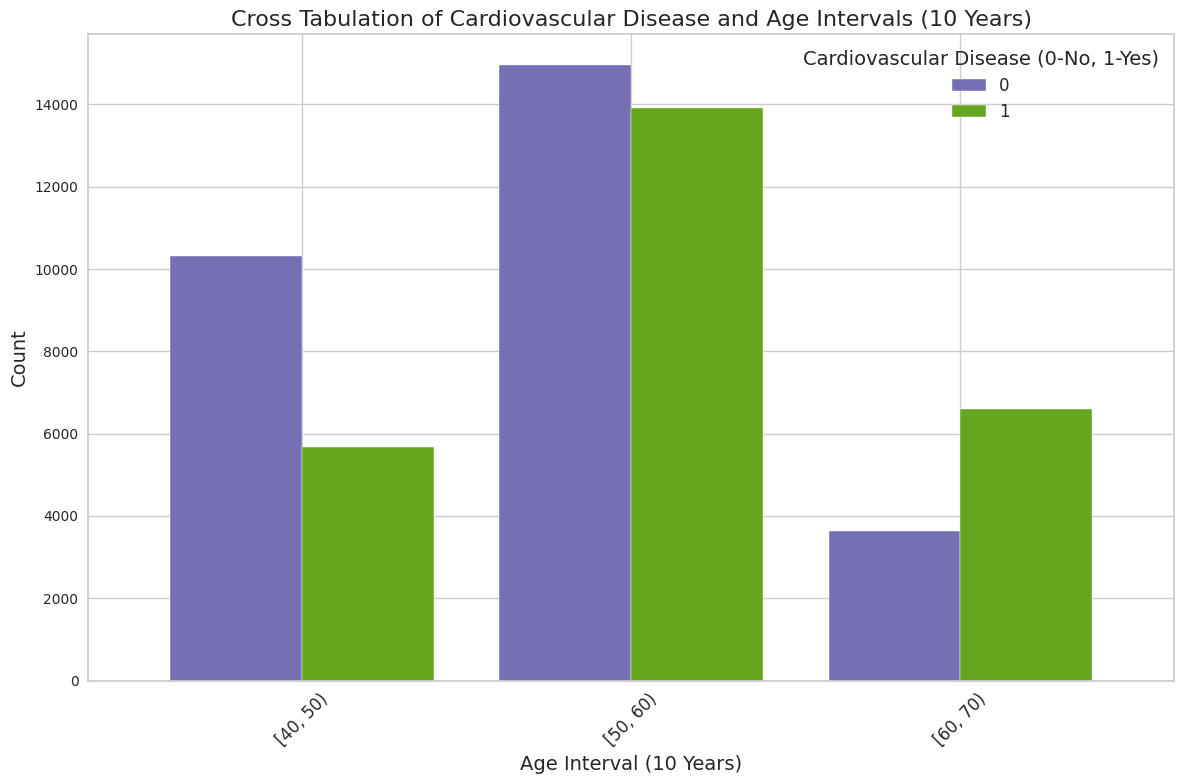


Percentage of individuals with cardiovascular disease within each 10-year age interval:
[40, 50): 35.47%
[50, 60): 48.20%
[60, 70): 64.45%


In [44]:
# Adjusting the plot size for better visibility of 10-year intervals in age categories
plt.figure(figsize=(12, 8))  # Increased figure size for better clarity

# Cross-tabulate age intervals in 10-year brackets with cardiovascular disease
healthData['age (in years) bracket'] = pd.cut(healthData['age (in years)'], bins=range(40, 71, 10), right=False)
age_cardiovascular_crosstab = pd.crosstab(healthData['age (in years) bracket'], healthData['cardio (0 - no cardiovascular disease, 1 -has cardiovascular disease)'])

# Generating the bar plot for cross-tabulation
age_cardiovascular_crosstab.plot(kind='bar', figsize=(12, 8), width=0.8)  # Adjusted width for spacing

plt.title('Cross Tabulation of Cardiovascular Disease and Age Intervals (10 Years)', fontsize=16)
plt.xlabel('Age Interval (10 Years)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.legend(title='Cardiovascular Disease (0-No, 1-Yes)', fontsize=12, title_fontsize=14)
plt.tight_layout()  # Ensures everything fits well within the figure
plt.show()

# Calculating and displaying the percentages from each age interval that have cardiovascular disease
age_interval_percentages = (age_cardiovascular_crosstab.loc[:, 1] / age_cardiovascular_crosstab.sum(axis=1)) * 100

print("\nPercentage of individuals with cardiovascular disease within each 10-year age interval:")
for interval, percentage in age_interval_percentages.items():
    print(f"{interval}: {percentage:.2f}%")

### Comments on Age:

As a person's age increases, their chances of having a cardiovascular disease increases gradually.

<Figure size 1200x800 with 0 Axes>

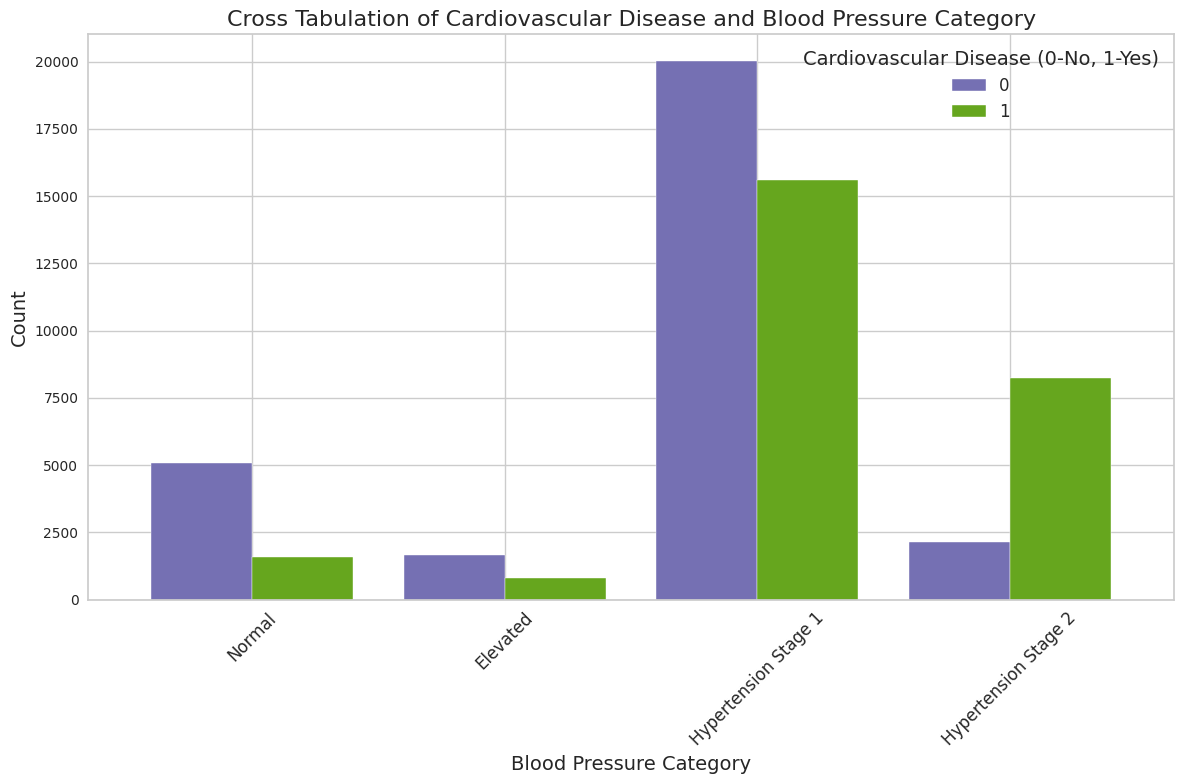


Percentage of individuals with cardiovascular disease within each blood pressure category:
Normal: 23.71%
Elevated: 32.48%
Hypertension Stage 1: 43.78%
Hypertension Stage 2: 79.28%


In [45]:
# Re-categorizing using the same logic as before but ensuring consistent indexing
def categorise_blood_pressure(systolic, diastolic):
    if systolic < 120 and diastolic < 80:
        return 'Normal'
    elif 120 <= systolic < 130 and diastolic < 80:
        return 'Elevated'
    elif 130 <= systolic < 140 or 80 <= diastolic < 90:
        return 'Hypertension Stage 1'
    elif 140 <= systolic or 90 <= diastolic:
        if systolic > 180 or diastolic > 120:
            return 'Hypertensive Crisis'
        return 'Hypertension Stage 2'
    else:
        return 'Unknown'

# Re-applying the function to the dataset
data_categories = ['Normal', 'Elevated', 'Hypertension Stage 1', 'Hypertension Stage 2', 'Hypertensive Crisis']
healthData['BP Category'] = healthData.apply(lambda row: categorise_blood_pressure(row['ap_hi (systolic blood pressure)'], row['ap_lo (diastolic blood pressure)']), axis=1)

# Ensuring categorical order is enforced for consistent plotting
healthData['BP Category'] = pd.Categorical(healthData['BP Category'], categories=data_categories, ordered=True)

# Regenerating the cross-tabulation frame with cleaned indexing
bp_cardiovascular_crosstab = pd.crosstab(healthData['BP Category'], healthData['cardio (0 - no cardiovascular disease, 1 -has cardiovascular disease)'])

# Re-plotting the graph based correctly sorted categories
plt.figure(figsize=(12, 8))
bp_cardiovascular_crosstab.plot(kind='bar', figsize=(12, 8), width=0.8)
plt.title('Cross Tabulation of Cardiovascular Disease and Blood Pressure Category', fontsize=16)
plt.xlabel('Blood Pressure Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.legend(title='Cardiovascular Disease (0-No, 1-Yes)', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

# Calculating and printing percentages for correctly ordered categories
bp_category_percentages = (bp_cardiovascular_crosstab.loc[:, 1] / bp_cardiovascular_crosstab.sum(axis=1)) * 100

print("\nPercentage of individuals with cardiovascular disease within each blood pressure category:")
for category in data_categories:
    if category in bp_category_percentages:
        print(f"{category}: {bp_category_percentages[category]:.2f}%")

### Comments on Blood Pressure:

As a person's blood pressure increases, their chances of having a cardiovascular disease increases gradually until Hypertension stage 1 after which it increases steeply.


<Figure size 1200x800 with 0 Axes>

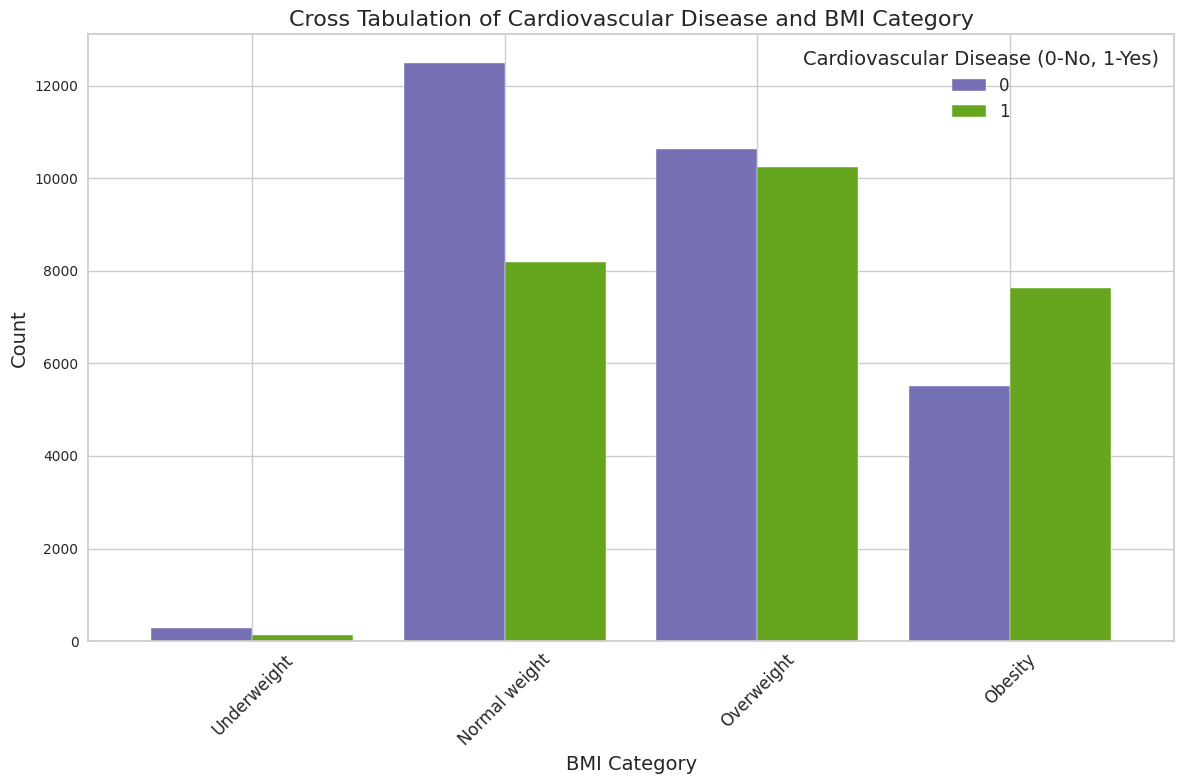


Percentage of individuals with cardiovascular disease within each BMI category:
Underweight: 29.83%
Normal weight: 39.61%
Overweight: 49.11%
Obesity: 58.04%


In [46]:
# Creating a cross-tabulation to calculate the relationships between BMI categories and cardiovascular disease
# Checking availability of necessary columns
if 'BMI Category' in healthData.columns and 'cardio (0 - no cardiovascular disease, 1 -has cardiovascular disease)' in healthData.columns:
    # Ensuring the BMI categories are ordered as desired
    bmi_categories_ordered = ['Underweight', 'Normal weight', 'Overweight', 'Obesity']
    healthData['BMI Category'] = pd.Categorical(healthData['BMI Category'], categories=bmi_categories_ordered, ordered=True)
    bmi_cardiovascular_crosstab = pd.crosstab(healthData['BMI Category'], healthData['cardio (0 - no cardiovascular disease, 1 -has cardiovascular disease)'])
else:
    print("Required columns for cross-tabulation are missing.")

# Adjusting the plot size for better visibility of cardiovascular disease categories
plt.figure(figsize=(12, 8))  # Increased figure size for better clarity

# Generating the bar plot again for cross-tabulation
bmi_cardiovascular_crosstab.plot(kind='bar', figsize=(12, 8), width=0.8)  # Adjusted width for spacing

plt.title('Cross Tabulation of Cardiovascular Disease and BMI Category', fontsize=16)
plt.xlabel('BMI Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.legend(title='Cardiovascular Disease (0-No, 1-Yes)', fontsize=12, title_fontsize=14)
plt.tight_layout()  # Ensures everything fits well within the figure
plt.show()

# Calculating and displaying the percentages from each category that have cardiovascular disease
bmi_category_percentages = (bmi_cardiovascular_crosstab.loc[:, 1] / bmi_cardiovascular_crosstab.sum(axis=1)) * 100

print("\nPercentage of individuals with cardiovascular disease within each BMI category:")
for category, percentage in bmi_category_percentages.items():
    print(f"{category}: {percentage:.2f}%")

### Comments on BMI: 
As a person's BMI increases, their risk of getting cardiovascular disesases increases gradually.

<Figure size 1200x800 with 0 Axes>

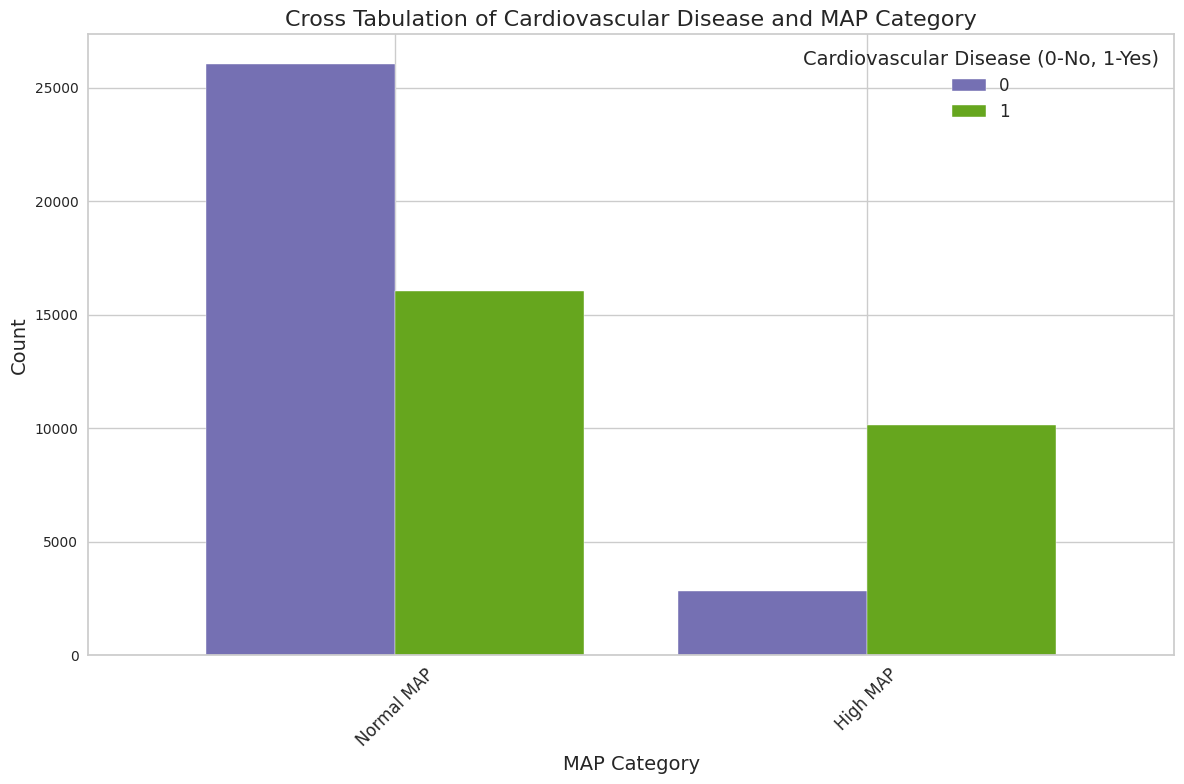


Percentage of individuals with cardiovascular disease within each MAP category:
Normal MAP: 38.11%
High MAP: 78.07%


In [47]:
# The reorder_map_categories function is missing, so we will define it here.
# This function ensures the categories in the 'MAP Category' column are ordered consistently for analysis.
def reorder_map_categories(data):
    """
    Reorders the 'MAP Category' in the dataset to maintain a logical order for plotting and analysis.

    Parameters:
    - data: DataFrame containing the 'MAP Category' column.

    Returns:
    - Updated DataFrame with ordered 'MAP Category'.
    """
    ordered_categories = ['Low MAP', 'Normal MAP', 'High MAP']
    data['MAP Category'] = pd.Categorical(data['MAP Category'], categories=ordered_categories, ordered=True)
    return data

# Define the 'categorise_map' function to categorize the mean arterial pressure (MAP).
def categorise_map(map_value):
    if map_value < 70:
        return 'Low MAP'
    elif 70 <= map_value <= 100:
        return 'Normal MAP'
    else:
        return 'High MAP'

# Reordering the MAP categories using the reorder_map_categories function
healthData['MAP Category'] = healthData['map (mean arterial pressure)'].apply(categorise_map)
healthData = reorder_map_categories(healthData)

# Creating a cross-tabulation of reordered MAP Category and Cardiovascular Disease
map_cardiovascular_crosstab = pd.crosstab(healthData['MAP Category'], healthData['cardio (0 - no cardiovascular disease, 1 -has cardiovascular disease)'])

# Adjusting the plot size for better visibility of cardiovascular disease categories
plt.figure(figsize=(12, 8))  # Increased figure size for better clarity

# Generating the bar plot for cross-tabulation with reordered MAP Categories
map_cardiovascular_crosstab.plot(kind='bar', figsize=(12, 8), width=0.8)  # Adjusted width for spacing

plt.title('Cross Tabulation of Cardiovascular Disease and MAP Category', fontsize=16)
plt.xlabel('MAP Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.legend(title='Cardiovascular Disease (0-No, 1-Yes)', fontsize=12, title_fontsize=14)
plt.tight_layout()  # Ensures everything fits well within the figure
plt.show()

# Calculating and displaying the percentages from each category that have cardiovascular disease
map_category_percentages = (map_cardiovascular_crosstab.loc[:, 1] / map_cardiovascular_crosstab.sum(axis=1)) * 100

print("\nPercentage of individuals with cardiovascular disease within each MAP category:")
for category, percentage in map_category_percentages.items():
    print(f"{category}: {percentage:.2f}%")

### Comments on MAP:

As a person's MAP increases, their risk of getting cardiovascular disesases increases significantly.

<Figure size 1200x800 with 0 Axes>

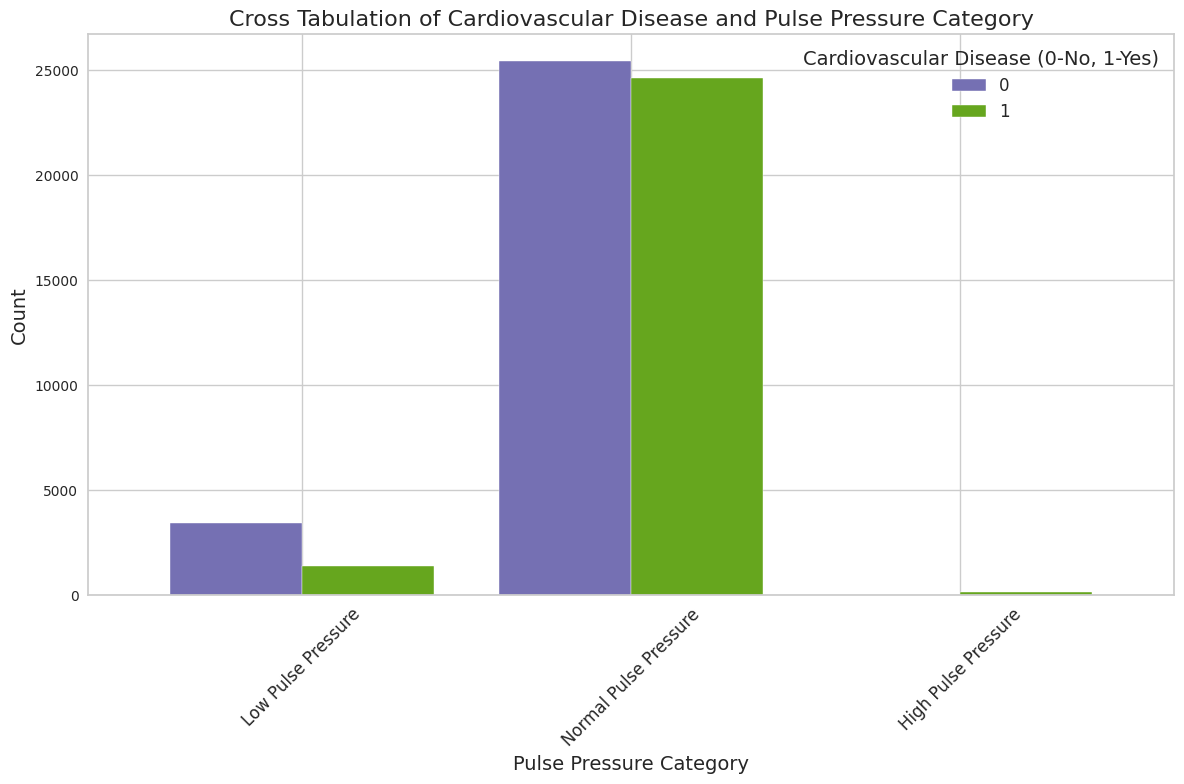


Percentage of individuals with cardiovascular disease within each Pulse Pressure category:
Low Pulse Pressure: 29.09%
Normal Pulse Pressure: 49.20%
High Pulse Pressure: 81.36%


In [48]:
# Function to categorise pulse pressure into Low, Normal, and High
# Low pulse pressure: < 40mmHg
# Normal pulse pressure: 40-60mmHg
# High pulse pressure: > 60mmHg
def categorise_pulse_pressure(pp_value):
    if pp_value < 40:
        return 'Low Pulse Pressure'
    elif 40 <= pp_value <= 60:
        return 'Normal Pulse Pressure'
    else:
        return 'High Pulse Pressure'

# Function to reorder and make Pulse Pressure an ordered categorical variable
def reorder_pulse_pressure_categories(dataframe):
    dataframe['Pulse Pressure Category'] = pd.Categorical(
        dataframe['Pulse Pressure Category'], 
        categories=['Low Pulse Pressure', 'Normal Pulse Pressure', 'High Pulse Pressure'], 
        ordered=True
    )
    return dataframe

# Categorizing pulse pressure values in the dataframe
healthData['Pulse Pressure Category'] = healthData['pp (pulse pressure)'].apply(categorise_pulse_pressure)

# Reordering the categories
healthData = reorder_pulse_pressure_categories(healthData)

# Creating a cross-tabulation of reordered Pulse Pressure Category and Cardiovascular Disease
pulse_pressure_cardiovascular_crosstab = pd.crosstab(
    healthData['Pulse Pressure Category'], 
    healthData['cardio (0 - no cardiovascular disease, 1 -has cardiovascular disease)']
)

# Adjusting the plot size for better visibility of cardiovascular disease categories
plt.figure(figsize=(12, 8))  # Increased figure size for better clarity

# Generating the bar plot for cross-tabulation with reordered Pulse Pressure Categories
pulse_pressure_cardiovascular_crosstab.plot(kind='bar', figsize=(12, 8), width=0.8)  # Adjusted width for spacing

plt.title('Cross Tabulation of Cardiovascular Disease and Pulse Pressure Category', fontsize=16)
plt.xlabel('Pulse Pressure Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.legend(title='Cardiovascular Disease (0-No, 1-Yes)', fontsize=12, title_fontsize=14)
plt.tight_layout()  # Ensures everything fits well within the figure
plt.show()

# Calculating and displaying the percentages from each category that have cardiovascular disease
pulse_pressure_category_percentages = (
    pulse_pressure_cardiovascular_crosstab.loc[:, 1] / pulse_pressure_cardiovascular_crosstab.sum(axis=1)
) * 100

print("\nPercentage of individuals with cardiovascular disease within each Pulse Pressure category:")
for category, percentage in pulse_pressure_category_percentages.items():
    print(f"{category}: {percentage:.2f}%")

### Comments on Pulse Pressure:

As a person's pulse pressure increases, their risk of getting cardiovascular disesases increases significantly.

<Figure size 1200x800 with 0 Axes>

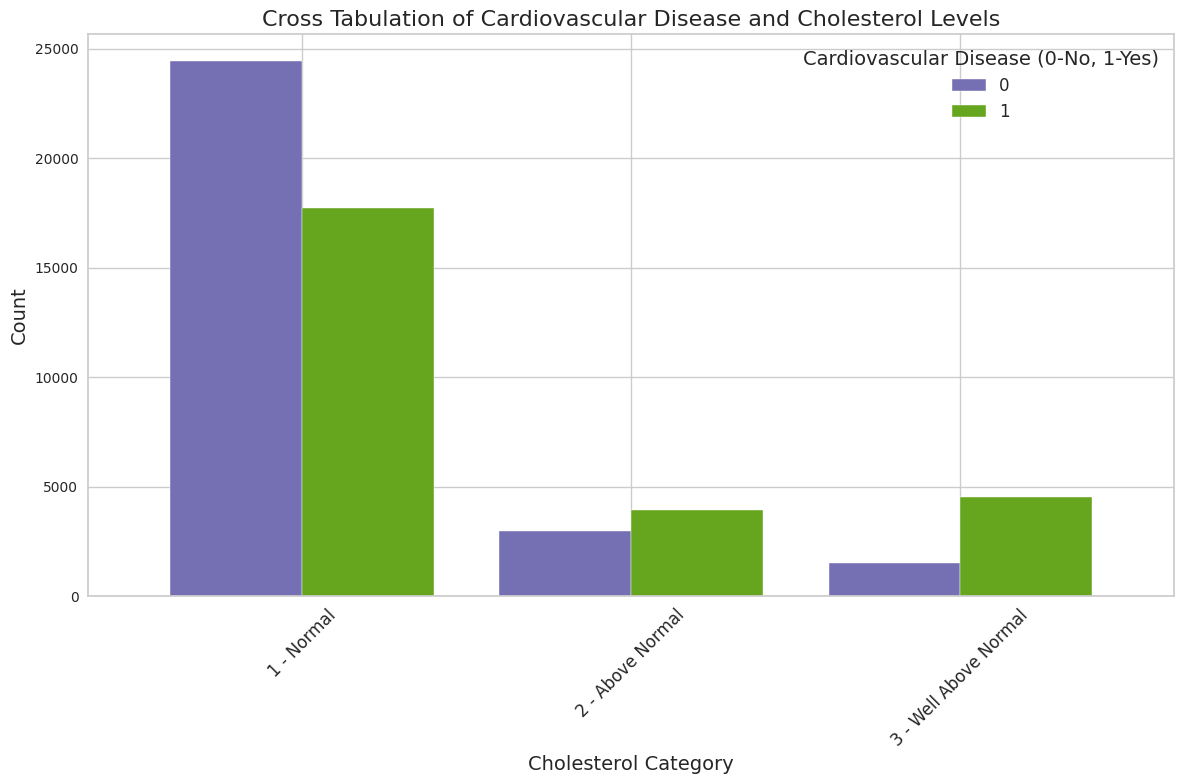


Percentage of individuals with cardiovascular disease within each Cholesterol category:
1 - Normal: 42.04%
2 - Above Normal: 57.03%
3 - Well Above Normal: 74.98%


In [49]:
# Function to reorder cholesterol levels to make them ordered categorical variables
def reorder_cholesterol_categories(dataframe):
    dataframe['cholesterol (Category)'] = pd.Categorical(
        dataframe['cholesterol (Category)'], 
        categories=['1 - Normal', '2 - Above Normal', '3 - Well Above Normal'], 
        ordered=True
    )
    return dataframe

# Reordering the cholesterol categories for maintaining meaningful order
healthData['cholesterol (Category)'] = healthData['cholesterol (1- normal, 2 - above normal, 3- well above normal)'].map({
    1: '1 - Normal',
    2: '2 - Above Normal',
    3: '3 - Well Above Normal',
})

healthData = reorder_cholesterol_categories(healthData)

# Creating a cross-tabulation of reordered Cholesterol Levels and Cardiovascular Disease
cholesterol_cardiovascular_crosstab = pd.crosstab(
    healthData['cholesterol (Category)'],
    healthData['cardio (0 - no cardiovascular disease, 1 -has cardiovascular disease)']
)

# Adjusting the plot size for better visibility of cardiovascular disease categories
plt.figure(figsize=(12, 8))  # Increased figure size for better clarity

# Generating the bar plot for cross-tabulation with reordered Cholesterol Levels
cholesterol_cardiovascular_crosstab.plot(kind='bar', figsize=(12, 8), width=0.8)  # Adjusted width for spacing

plt.title('Cross Tabulation of Cardiovascular Disease and Cholesterol Levels', fontsize=16)
plt.xlabel('Cholesterol Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.legend(title='Cardiovascular Disease (0-No, 1-Yes)', fontsize=12, title_fontsize=14)
plt.tight_layout()  # Ensures everything fits well within the figure
plt.show()

# Calculating and displaying the percentages from each category that have cardiovascular disease
cholesterol_category_percentages = (
    cholesterol_cardiovascular_crosstab.loc[:, 1] / cholesterol_cardiovascular_crosstab.sum(axis=1)
) * 100

print("\nPercentage of individuals with cardiovascular disease within each Cholesterol category:")
for category, percentage in cholesterol_category_percentages.items():
    print(f"{category}: {percentage:.2f}%")

### Comments on Cholesterol:

As a person's cholesterol level increases, their risk of getting cardiovascular disesases increases gradually.

<Figure size 1200x800 with 0 Axes>

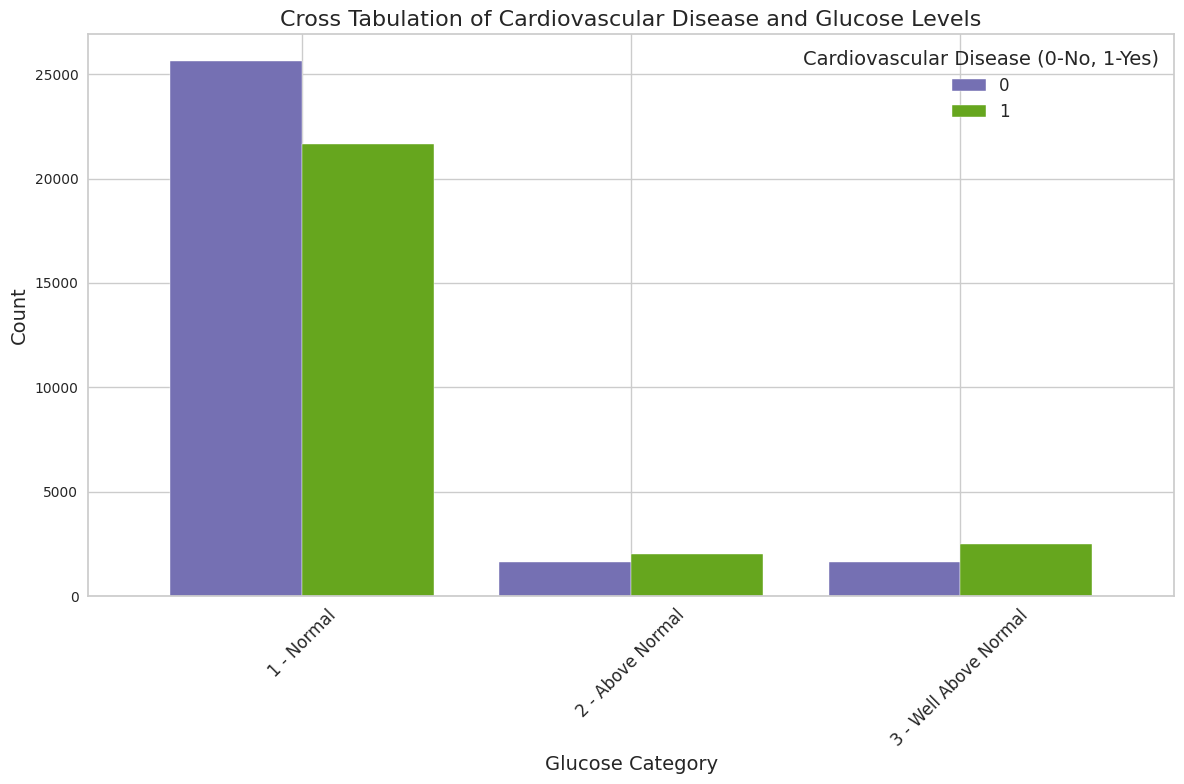


Percentage of individuals with cardiovascular disease within each Glucose category:
1 - Normal: 45.82%
2 - Above Normal: 55.27%
3 - Well Above Normal: 60.19%


In [50]:
# Function to reorder glucose levels to make them ordered categorical variables
def reorder_glucose_categories(dataframe):
    dataframe['gluc (Category)'] = pd.Categorical(
        dataframe['gluc (Category)'], 
        categories=['1 - Normal', '2 - Above Normal', '3 - Well Above Normal'], 
        ordered=True
    )
    return dataframe

# Reordering the glucose levels for maintaining meaningful order
healthData['gluc (Category)'] = healthData['gluc (1- normal, 2 - above normal, 3- well above normal)'].map({
    1: '1 - Normal',
    2: '2 - Above Normal',
    3: '3 - Well Above Normal',
})

healthData = reorder_glucose_categories(healthData)

# Creating a cross-tabulation of reordered Glucose Levels and Cardiovascular Disease
glucose_cardiovascular_crosstab = pd.crosstab(
    healthData['gluc (Category)'],
    healthData['cardio (0 - no cardiovascular disease, 1 -has cardiovascular disease)']
)

# Adjusting the plot size for better visibility of cardiovascular disease categories
plt.figure(figsize=(12, 8))  # Increased figure size for better clarity

# Generating the bar plot for cross-tabulation with reordered Glucose Levels
glucose_cardiovascular_crosstab.plot(kind='bar', figsize=(12, 8), width=0.8)  # Adjusted width for spacing

plt.title('Cross Tabulation of Cardiovascular Disease and Glucose Levels', fontsize=16)
plt.xlabel('Glucose Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.legend(title='Cardiovascular Disease (0-No, 1-Yes)', fontsize=12, title_fontsize=14)
plt.tight_layout()  # Ensures everything fits well within the figure
plt.show()

# Calculating and displaying the percentages from each category that have cardiovascular disease
glucose_category_percentages = (
    glucose_cardiovascular_crosstab.loc[:, 1] / glucose_cardiovascular_crosstab.sum(axis=1)
) * 100

print("\nPercentage of individuals with cardiovascular disease within each Glucose category:")
for category, percentage in glucose_category_percentages.items():
    print(f"{category}: {percentage:.2f}%")

### Comments on Glucose:

As a person's glucose level increases, their risk of getting cardiovascular disesases increases slightly.

<Figure size 1200x800 with 0 Axes>

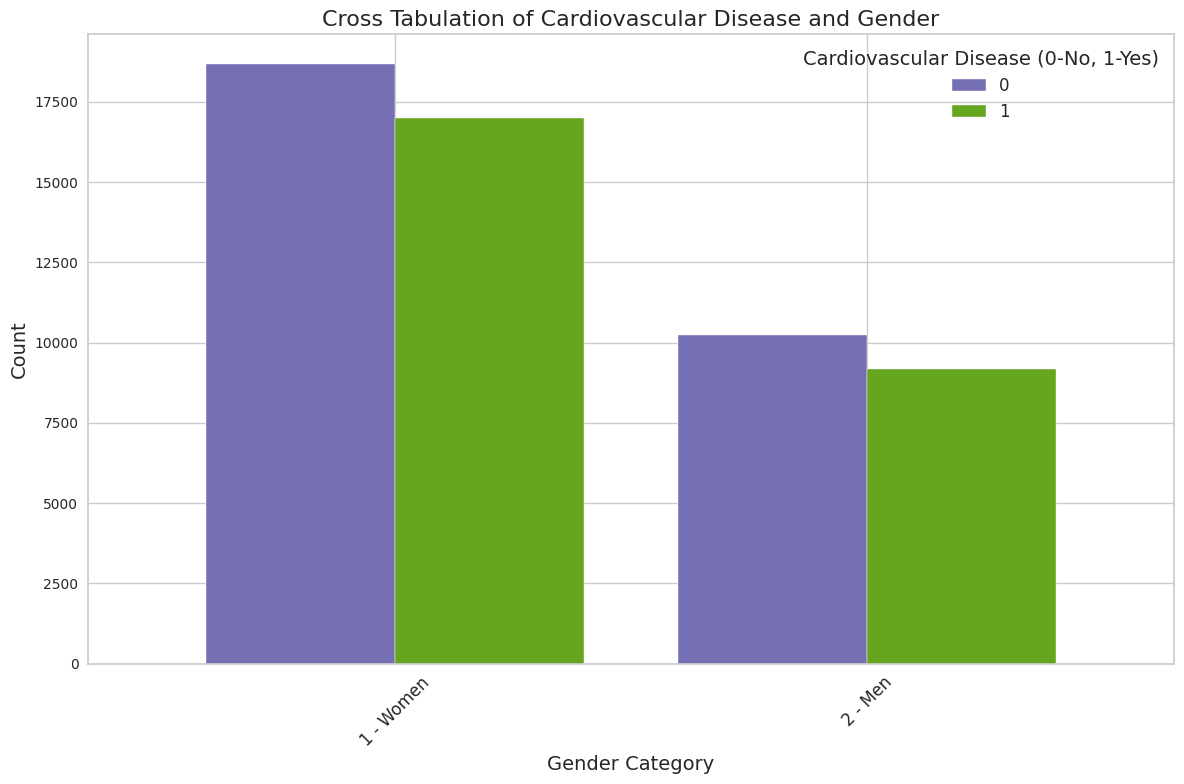


Percentage of individuals with cardiovascular disease within each Gender category:
1 - Women: 47.65%
2 - Men: 47.32%


In [51]:
# Function to categorise gender
# Male: '1 - Men'
# Female: '2 - Women'
def categorise_gender(sex_value):
    if sex_value == 1:
        return '1 - Women'
    elif sex_value == 2:
        return '2 - Men'

# Convert gender to ordered categorical variable
def reorder_gender_categories(dataframe):
    dataframe['Gender (Category)'] = pd.Categorical(
        dataframe['Gender (Category)'], 
        categories=['1 - Women', '2 - Men'], 
        ordered=True
    )
    return dataframe

# Applying categorization to the healthData dataset
healthData['Gender (Category)'] = healthData['gender( 1 for Women, 2 for Men)'].apply(categorise_gender)

# Reordering the gender categories
healthData = reorder_gender_categories(healthData)

# Creating a cross-tabulation of Gender and Cardiovascular disease
gender_cardiovascular_crosstab = pd.crosstab(
    healthData['Gender (Category)'], 
    healthData['cardio (0 - no cardiovascular disease, 1 -has cardiovascular disease)']
)

# Adjusting the plot size for better visibility of cardiovascular disease categories
plt.figure(figsize=(12, 8))  # Increased figure size for better clarity

# Creating the bar plot for cross-tabulation with gender and cardiovascular disease
gender_cardiovascular_crosstab.plot(kind='bar', figsize=(12, 8), width=0.8)

plt.title('Cross Tabulation of Cardiovascular Disease and Gender', fontsize=16)
plt.xlabel('Gender Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.legend(title='Cardiovascular Disease (0-No, 1-Yes)', fontsize=12, title_fontsize=14)
plt.tight_layout()  # Ensures everything fits well within the figure
plt.show()

# Calculating and displaying the percentages of cardiovascular disease within each gender category
gender_category_percentages = (
    gender_cardiovascular_crosstab.loc[:, 1] / gender_cardiovascular_crosstab.sum(axis=1)
) * 100

print("\nPercentage of individuals with cardiovascular disease within each Gender category:")
for category, percentage in gender_category_percentages.items():
    print(f"{category}: {percentage:.2f}%")

### Comments on Gender:

Cardiovascular diseases generally occur at about the same rate for both men and women.

<Figure size 1200x800 with 0 Axes>

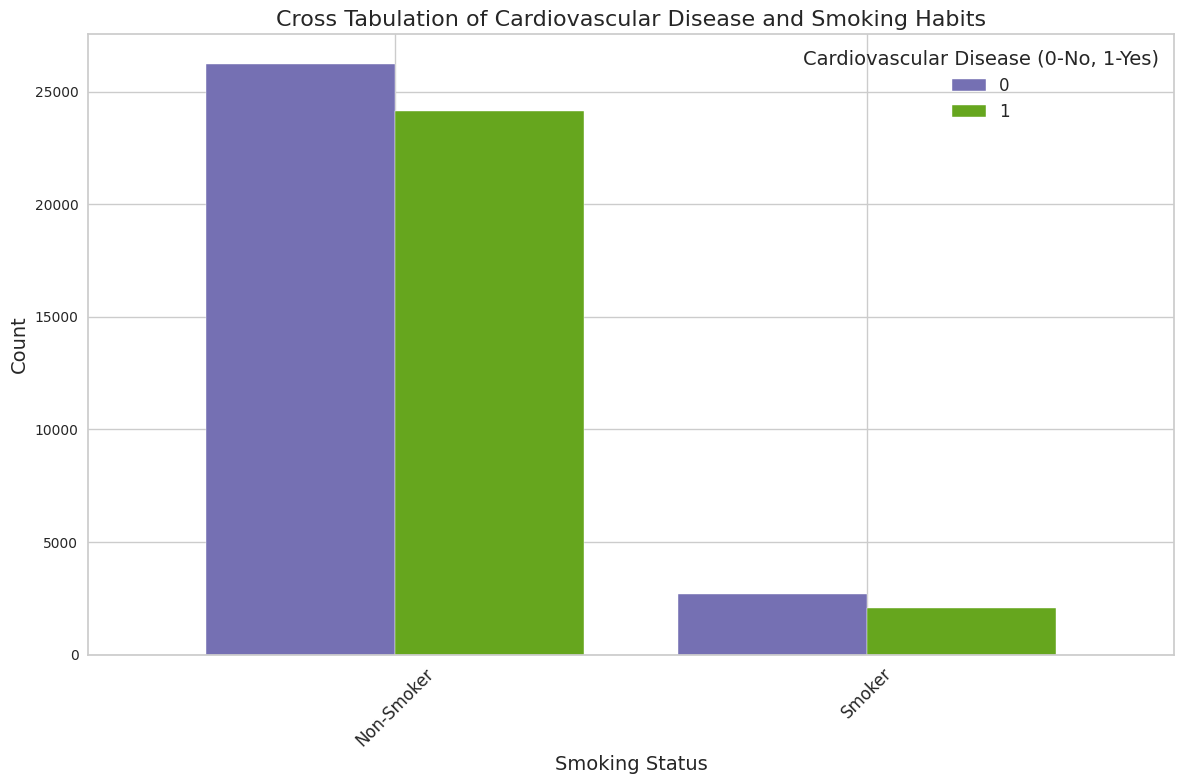


Percentage of individuals with cardiovascular disease within each Smoking category:
Non-Smoker: 47.91%
Smoker: 43.46%


In [52]:
# Function to categorise smoking habits
def categorise_smoking(smoke_value):
    if smoke_value == 0:
        return 'Non-Smoker'
    elif smoke_value == 1:
        return 'Smoker'

# Convert smoking column to categorical variable
def reorder_smoking_categories(dataframe):
    dataframe['Smoking Status'] = pd.Categorical(
        dataframe['Smoking Status'], 
        categories=['Non-Smoker', 'Smoker'], 
        ordered=True
    )
    return dataframe

# Applying categorization for smoking habits
healthData['Smoking Status'] = healthData['smoke (0 - does not smoke, 1 - smokes)'].apply(categorise_smoking)

# Reordering smoking status categories
healthData = reorder_smoking_categories(healthData)

# Creating a cross-tabulation of Smoking Status and Cardiovascular Disease
smoking_cardiovascular_crosstab = pd.crosstab(
    healthData['Smoking Status'], 
    healthData['cardio (0 - no cardiovascular disease, 1 -has cardiovascular disease)']
)

# Adjusting the plot size for better visibility of cardiovascular disease categories
plt.figure(figsize=(12, 8))  # Increased figure size for better clarity

# Creating the bar plot for cross-tabulation with smoking status and cardiovascular disease
smoking_cardiovascular_crosstab.plot(kind='bar', figsize=(12, 8), width=0.8)

plt.title('Cross Tabulation of Cardiovascular Disease and Smoking Habits', fontsize=16)
plt.xlabel('Smoking Status', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.legend(title='Cardiovascular Disease (0-No, 1-Yes)', fontsize=12, title_fontsize=14)
plt.tight_layout()  # Ensures everything fits well within the figure
plt.show()

# Calculating and displaying the percentages of cardiovascular disease within each smoking status
smoking_status_percentages = (
    smoking_cardiovascular_crosstab.loc[:, 1] / smoking_cardiovascular_crosstab.sum(axis=1)
) * 100

print("\nPercentage of individuals with cardiovascular disease within each Smoking category:")
for category, percentage in smoking_status_percentages.items():
    print(f"{category}: {percentage:.2f}%")

### Comments on Smoking:

Smoking is not an important distinguishing factor to determine whether a person has cardiovascular disease or not. It is also unclear in the data how often one smokes and how much they smoke.

<Figure size 1200x800 with 0 Axes>

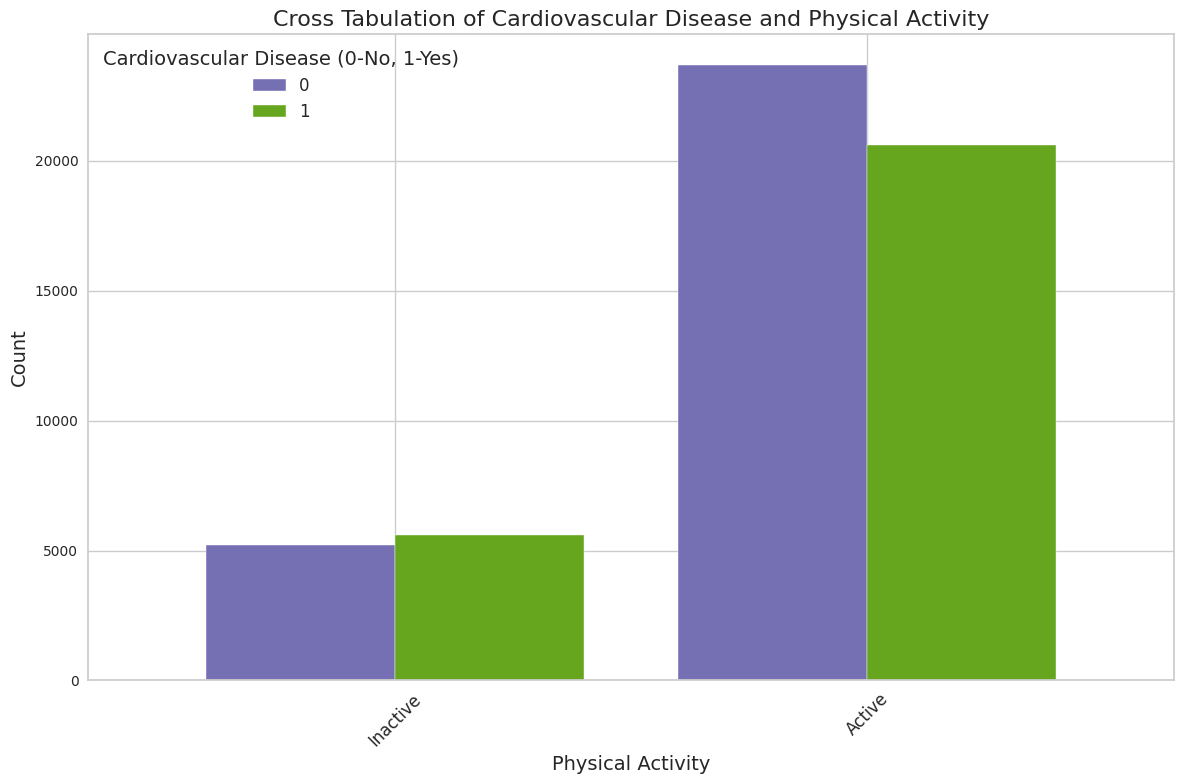


Percentage of individuals with cardiovascular disease within each Physical Activity category:
Inactive: 51.65%
Active: 46.53%


In [53]:
# Function to categorise physical activity into Active or Inactive
# Inactive (0): Does not exercise
# Active (1): Exercises
def categorise_activity(activity_value):
    if activity_value == 0:
        return 'Inactive'
    elif activity_value == 1:
        return 'Active'

# Reorder and make Physical Activity an ordered categorical variable
def reorder_activity_categories(dataframe):
    dataframe['Physical Activity'] = pd.Categorical(
        dataframe['Physical Activity'], 
        categories=['Inactive', 'Active'], 
        ordered=True
    )
    return dataframe

# Applying categorization to the healthData dataset
healthData['Physical Activity'] = healthData['active (0 - does not exercise, 1 - exercises)'].apply(categorise_activity)

# Reordering the physical activity categories
healthData = reorder_activity_categories(healthData)

# Creating a cross-tabulation of Physical Activity and Cardiovascular Disease
activity_cardiovascular_crosstab = pd.crosstab(
    healthData['Physical Activity'], 
    healthData['cardio (0 - no cardiovascular disease, 1 -has cardiovascular disease)']
)

# Adjusting the plot size for better visibility of cardiovascular disease categories
plt.figure(figsize=(12, 8))  # Increased figure size for better clarity

# Creating the bar plot for cross-tabulation with physical activity and cardiovascular disease
activity_cardiovascular_crosstab.plot(kind='bar', figsize=(12, 8), width=0.8)

plt.title('Cross Tabulation of Cardiovascular Disease and Physical Activity', fontsize=16)
plt.xlabel('Physical Activity', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.legend(title='Cardiovascular Disease (0-No, 1-Yes)', fontsize=12, title_fontsize=14)
plt.tight_layout()  # Ensures everything fits well within the figure
plt.show()

# Calculating and displaying the percentages of cardiovascular disease within each physical activity category
activity_percentages = (
    activity_cardiovascular_crosstab.loc[:, 1] / activity_cardiovascular_crosstab.sum(axis=1)
) * 100

print("\nPercentage of individuals with cardiovascular disease within each Physical Activity category:")
for category, percentage in activity_percentages.items():
    print(f"{category}: {percentage:.2f}%")

### Comments on Physical Activity:

Physical activity is not an important distinguishing factor to determine whether a person has cardiovascular disease. It is also unclear from the data what kind of physical activity one does, at what frequency and to what intensity.

<Figure size 1200x800 with 0 Axes>

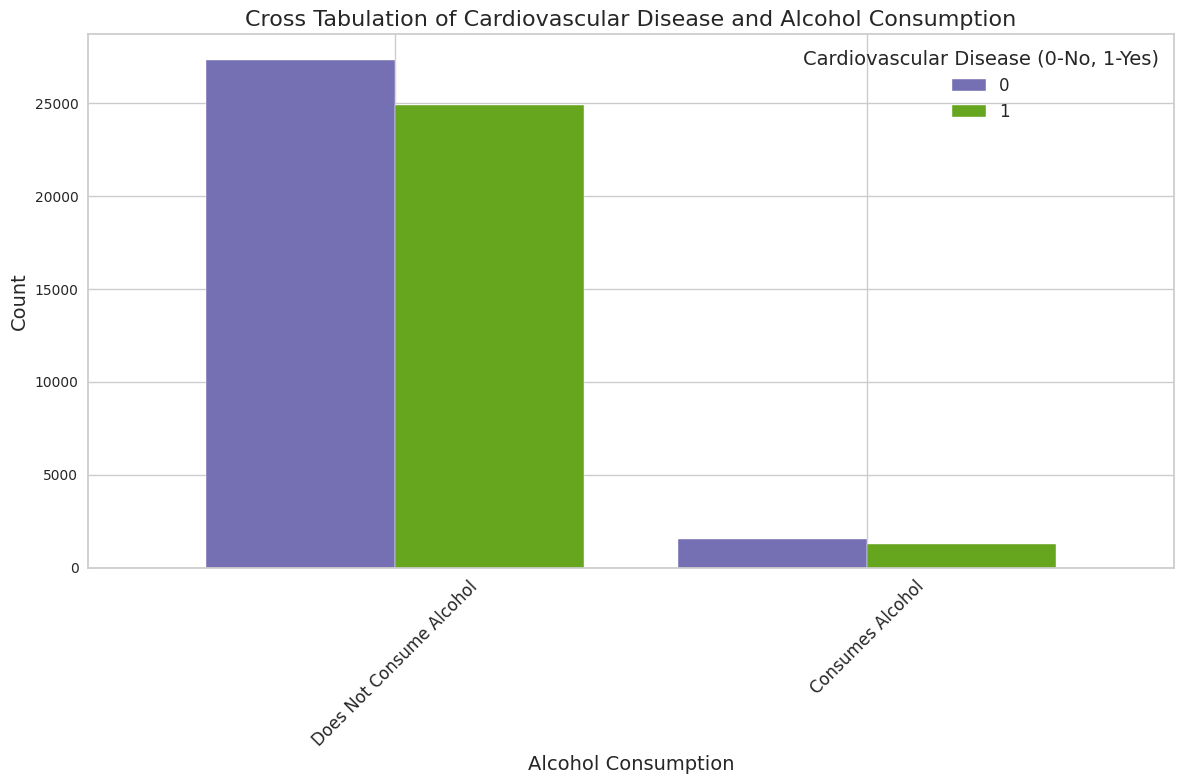


Percentage of individuals with cardiovascular disease within each Alcohol Consumption category:
Does Not Consume Alcohol: 47.69%
Consumes Alcohol: 44.53%


In [54]:
# Function to categorise alcohol consumption into descriptive categories
def categorise_alcohol(alcohol_value):
    if alcohol_value == 0:
        return 'Does Not Consume Alcohol'
    elif alcohol_value == 1:
        return 'Consumes Alcohol'

# Reorder and make Alcohol Consumption an ordered categorical variable
def reorder_alcohol_categories(dataframe):
    dataframe['Alcohol Consumption (Category)'] = pd.Categorical(
        dataframe['Alcohol Consumption (Category)'], 
        categories=['Does Not Consume Alcohol', 'Consumes Alcohol'], 
        ordered=True
    )
    return dataframe

# Reorder and make Alcohol Consumption an ordered categorical variable
if 'alco (0 - does not alcohol, 1 - consumes alcohol)' in healthData.columns:
    healthData['Alcohol Consumption (Category)'] = healthData['alco (0 - does not alcohol, 1 - consumes alcohol)'].apply(categorise_alcohol)

    # Reordering the alcohol consumption categories
    healthData = reorder_alcohol_categories(healthData)

    # Creating a cross-tabulation of Alcohol Consumption and Cardiovascular Disease
    alcohol_cardiovascular_crosstab = pd.crosstab(
        healthData['Alcohol Consumption (Category)'], 
        healthData['cardio (0 - no cardiovascular disease, 1 -has cardiovascular disease)']
    )

    # Adjusting the plot size for better visibility of cardiovascular disease categories
    plt.figure(figsize=(12, 8))  # Increased figure size for better clarity

    # Creating the bar plot for cross-tabulation with alcohol consumption and cardiovascular disease
    alcohol_cardiovascular_crosstab.plot(kind='bar', figsize=(12, 8), width=0.8)

    plt.title('Cross Tabulation of Cardiovascular Disease and Alcohol Consumption', fontsize=16)
    plt.xlabel('Alcohol Consumption', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(fontsize=12, rotation=45)
    plt.legend(title='Cardiovascular Disease (0-No, 1-Yes)', fontsize=12, title_fontsize=14)
    plt.tight_layout()  # Ensures everything fits well within the figure
    plt.show()

    # Calculating and displaying the percentages of cardiovascular disease within each alcohol consumption category
    alcohol_percentages = (
        alcohol_cardiovascular_crosstab.loc[:, 1] / alcohol_cardiovascular_crosstab.sum(axis=1)
    ) * 100

    print("\nPercentage of individuals with cardiovascular disease within each Alcohol Consumption category:")
    for category, percentage in alcohol_percentages.items():
        print(f"{category}: {percentage:.2f}%")
else:
    print("The column 'alco (0 - does not alcohol, 1 - consumes alcohol)' was not found in the dataset.")

## Comments on Alcohol:


Alcohol is not an important distinguishing factor to determine whether a person has cardiovascular disease. It is also unclear from the data what kind of Alcohol one consumes at what percentage, volume or frequency.

## Noting that from the above data,

    - Age
    - Blood Pressure
    - BMI
    - MAP
    - Pulse Pressure
    - Cholesterol
    - Glucose
have been correlated to better predict the likelihood of someone having cardiovascular disease

## While

    - Gender
    - Smoking
    - Physical Activity
    - Alcohol Consumption
have been shown not to be significant factors to predict the likelihood of someone having cardiovascular disease
    

## Summary of Exploratory Analysis Percentages

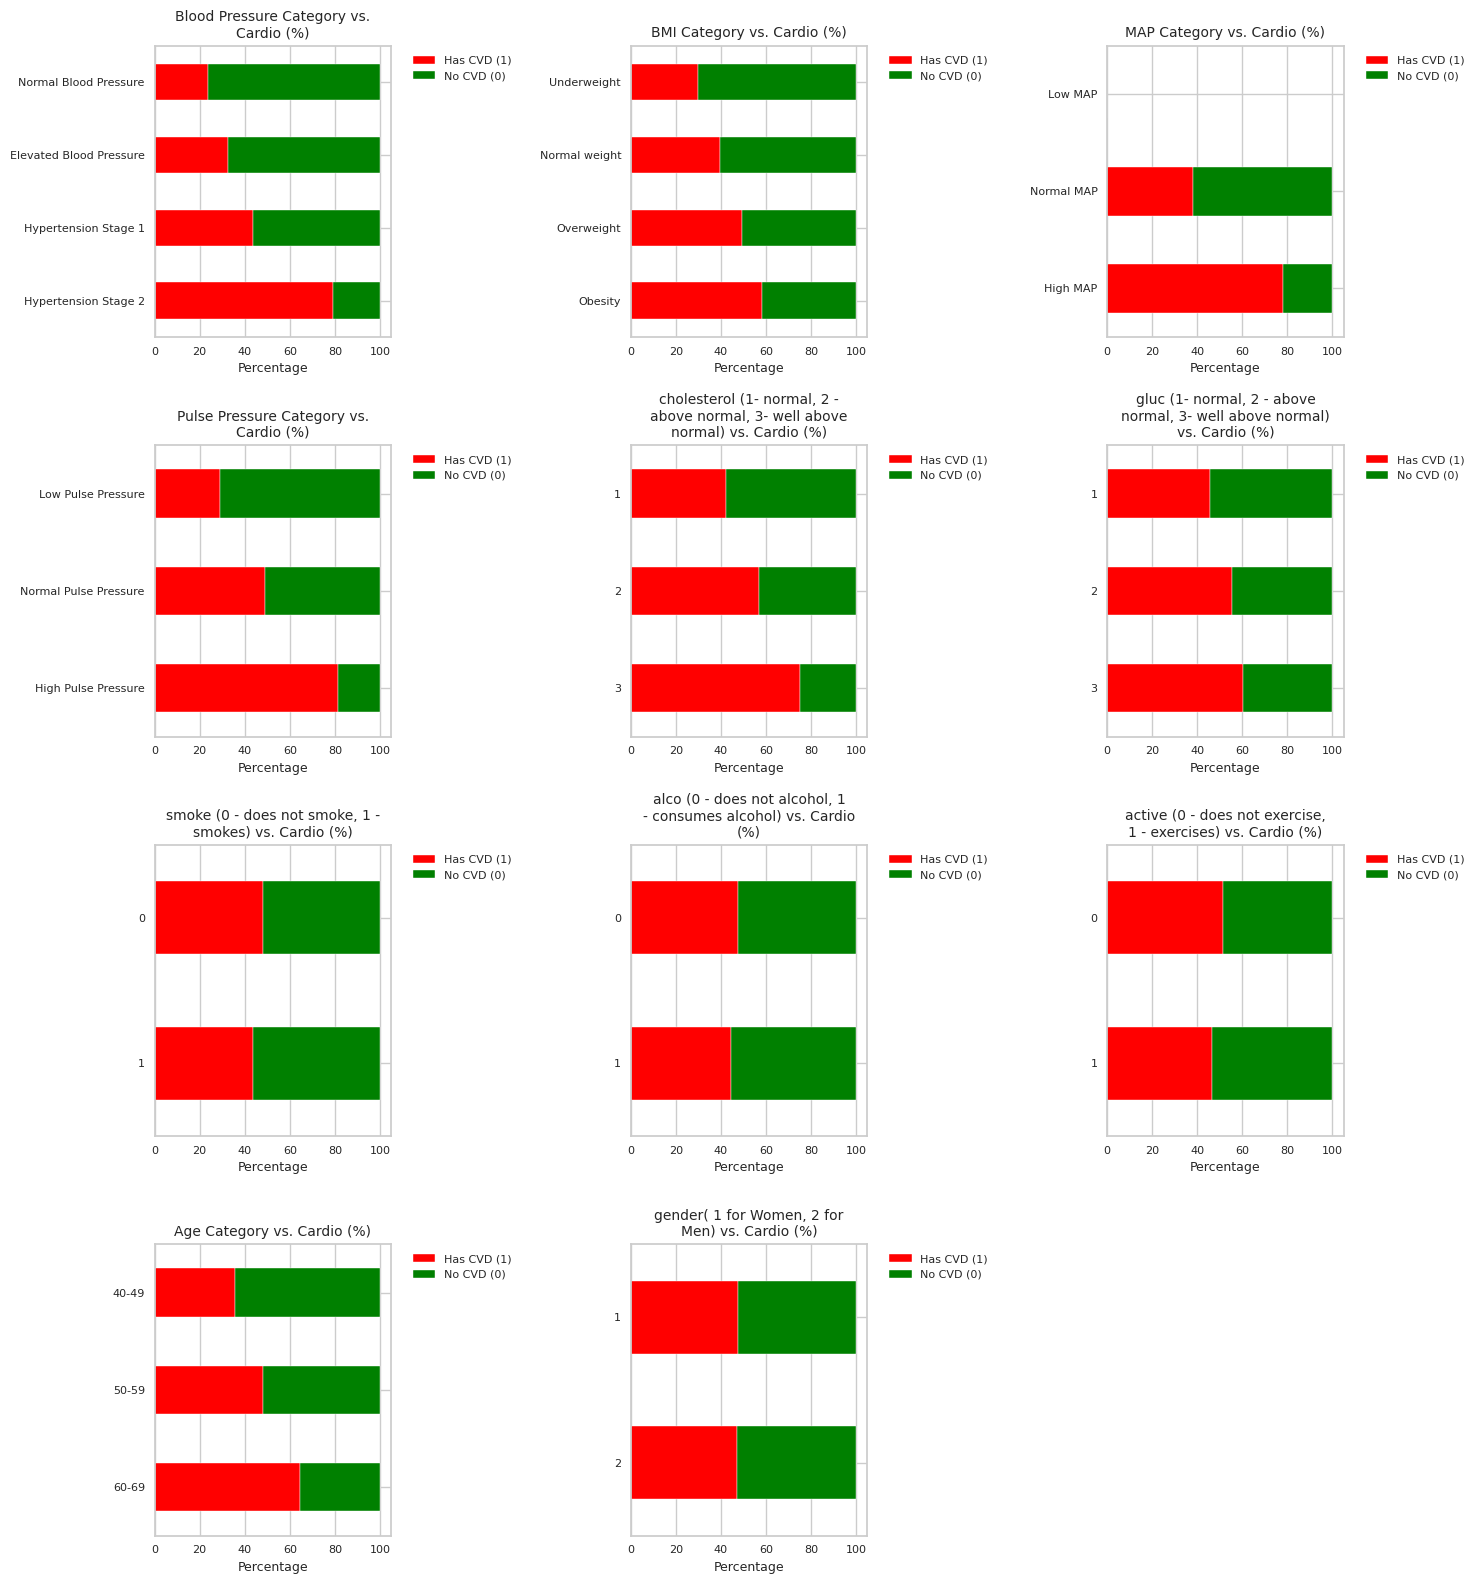

In [84]:
# Set order for different categorical variables
category_orders = {
    'Blood Pressure Category': [
        'Hypertension Stage 2', 'Hypertension Stage 1', 'Elevated Blood Pressure', 'Normal Blood Pressure'],
    'BMI Category': ['Obesity', 'Overweight', 'Normal weight', 'Underweight'], 
    'MAP Category': ['High MAP', 'Normal MAP', 'Low MAP'],
    'Pulse Pressure Category': ['High Pulse Pressure', 'Normal Pulse Pressure', 'Low Pulse Pressure'],
    'cholesterol (1- normal, 2 - above normal, 3- well above normal)': [3, 2, 1],
    'gluc (1- normal, 2 - above normal, 3- well above normal)': [3, 2, 1],
    'smoke (0 - does not smoke, 1 - smokes)': [1, 0],
    'alco (0 - does not alcohol, 1 - consumes alcohol)': [1, 0],
    'active (0 - does not exercise, 1 - exercises)': [1, 0],
    'Age Category': ['60-69', '50-59', '40-49'],
    'gender( 1 for Women, 2 for Men)': [2, 1]
}

# Set as ordered categorical (important for plotting)
for feature, order in category_orders.items():
    if feature in healthData.columns:
        healthData[feature] = pd.Categorical(healthData[feature], categories=order, ordered=True)

# List of features to visualize
categorical_features = [
    'Blood Pressure Category',
    'BMI Category',
    'MAP Category',
    'Pulse Pressure Category',
    'cholesterol (1- normal, 2 - above normal, 3- well above normal)',
    'gluc (1- normal, 2 - above normal, 3- well above normal)',
    'smoke (0 - does not smoke, 1 - smokes)',
    'alco (0 - does not alcohol, 1 - consumes alcohol)',
    'active (0 - does not exercise, 1 - exercises)',
    'Age Category',
    'gender( 1 for Women, 2 for Men)'
]

# Setup subplots
n_cols = 3
n_rows = -(-len(categorical_features) // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

# Loop through features
for i, feature in enumerate(categorical_features):

    # Calculate percentages
    counts = (
        healthData
        .groupby([feature, 'cardio (0 - no cardiovascular disease, 1 -has cardiovascular disease)'])
        .size()
        .reset_index(name='count')
    )
    pivoted = counts.pivot(
        index=feature, 
        columns='cardio (0 - no cardiovascular disease, 1 -has cardiovascular disease)', 
        values='count'
    ).fillna(0)

    pivoted_percent = pivoted.div(pivoted.sum(axis=1), axis=0) * 100

    # Ensure both CVD columns exist
    for col in [0, 1]:
        if col not in pivoted_percent.columns:
            pivoted_percent[col] = 0.0
    pivoted_percent = pivoted_percent[[1, 0]]
    pivoted_percent.columns = ['Has CVD (1)', 'No CVD (0)']

    # Plot
    ax = axes[i]
    pivoted_percent.plot(kind='barh', stacked=True, ax=ax, color=['red', 'green'])

    # Format titles and labels
    wrapped_title = textwrap.fill(f"{feature} vs. Cardio (%)", width=30)
    ax.set_title(wrapped_title, fontsize=10)
    ax.set_xlabel("Percentage", fontsize=9)
    ax.set_ylabel("")
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Remove empty subplots
for j in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Calculate the % of individuals with cardiovascular disease in each category

In [58]:
# Loop over each feature
for i, feature in enumerate(categorical_features):
    
    # Calculate the percentage of individuals with cardiovascular disease within each category.
    # Since the cardio column is 0 or 1, taking the mean gives the proportion with disease.
    percentages = healthData.groupby(feature)["cardio (0 - no cardiovascular disease, 1 -has cardiovascular disease)"].mean() * 100
    
    # Print descriptive comments for each feature.
    print(f"\nPercentage of individuals with cardiovascular disease within each {feature} category:")
    for category, percentage in percentages.items():
         print(f"  {category}: {percentage:.2f}%")


Percentage of individuals with cardiovascular disease within each Blood Pressure Category category:
  Hypertension Stage 2: 79.28%
  Hypertension Stage 1: 43.78%
  Elevated Blood Pressure: 32.48%
  Normal Blood Pressure: 23.71%

Percentage of individuals with cardiovascular disease within each BMI Category category:
  Obesity: 58.04%
  Overweight: 49.11%
  Normal weight: 39.61%
  Underweight: 29.83%

Percentage of individuals with cardiovascular disease within each MAP Category category:
  High MAP: 78.07%
  Normal MAP: 38.11%
  Low MAP: nan%

Percentage of individuals with cardiovascular disease within each Pulse Pressure Category category:
  High Pulse Pressure: 81.36%
  Normal Pulse Pressure: 49.20%
  Low Pulse Pressure: 29.09%

Percentage of individuals with cardiovascular disease within each cholesterol (1- normal, 2 - above normal, 3- well above normal) category:
  3: 74.98%
  2: 57.03%
  1: 42.04%

Percentage of individuals with cardiovascular disease within each gluc (1- norma

## Correlation Heatmap

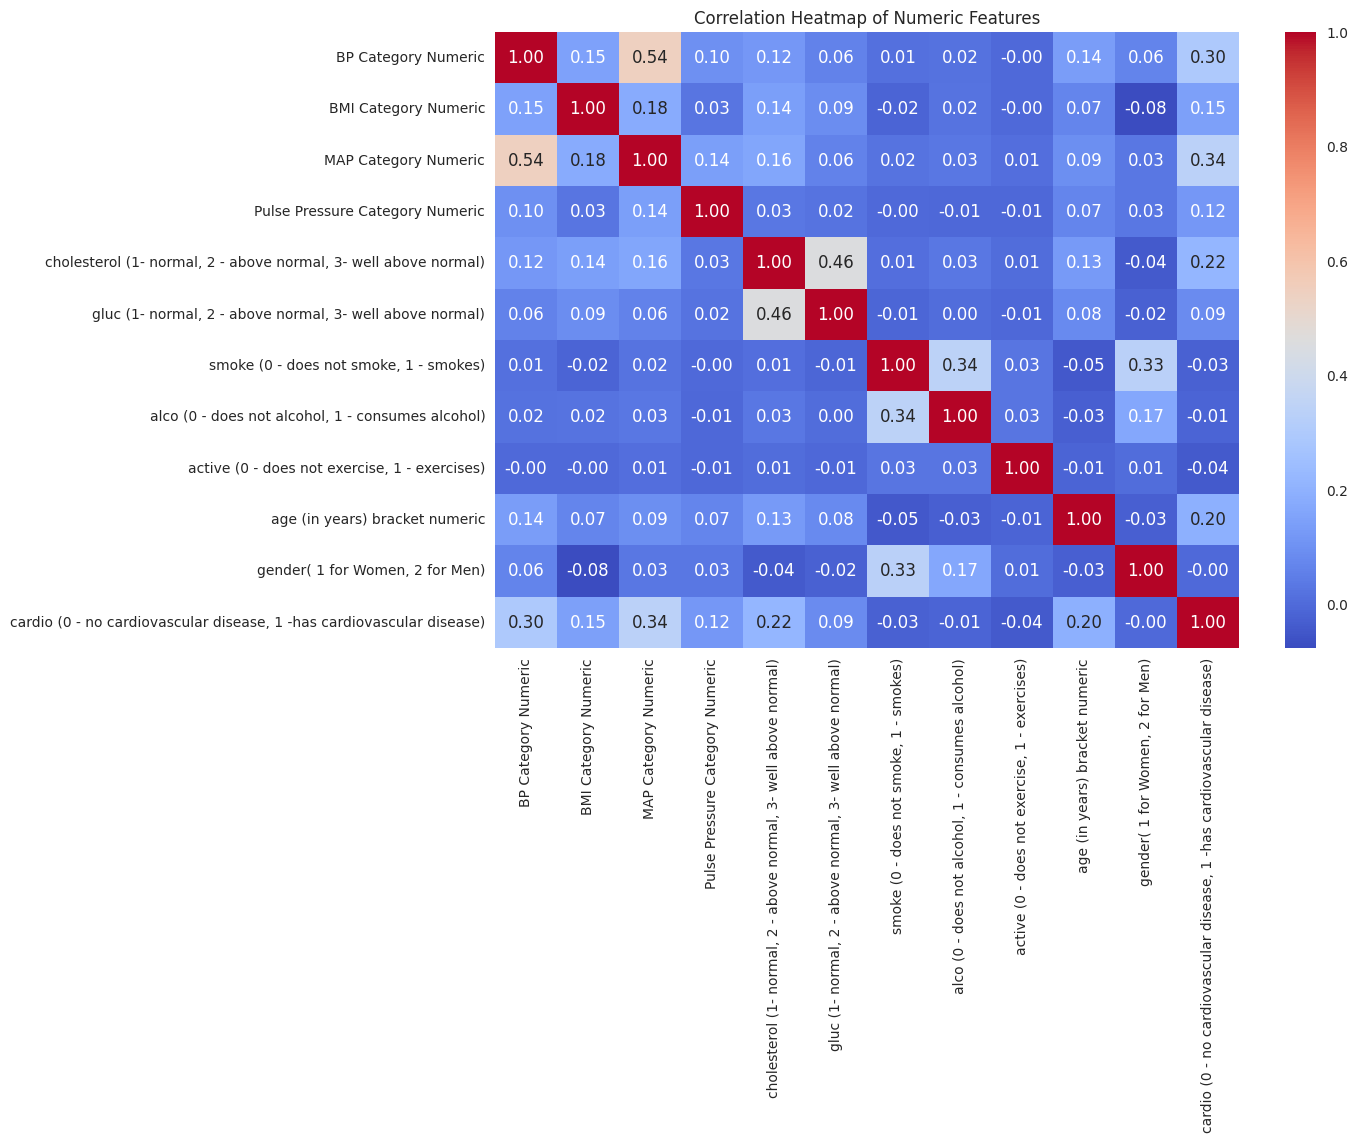

In [59]:
# 1. Select columns
numeric_cols = [
    'BP Category Numeric', 
    'BMI Category Numeric',
    'MAP Category Numeric',
    'Pulse Pressure Category Numeric',
    'cholesterol (1- normal, 2 - above normal, 3- well above normal)',
    'gluc (1- normal, 2 - above normal, 3- well above normal)',
    'smoke (0 - does not smoke, 1 - smokes)',
    'alco (0 - does not alcohol, 1 - consumes alcohol)',
    'active (0 - does not exercise, 1 - exercises)',
    'age (in years) bracket numeric',
    'gender( 1 for Women, 2 for Men)',
    'cardio (0 - no cardiovascular disease, 1 -has cardiovascular disease)'
]

# 2. Compute the correlation matrix
corr_matrix = healthData[numeric_cols].corr()

# 3. Create a heatmap
plt.figure(figsize=(12, 8))
sb.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

## Observations:
MAP Category (corr ≈ 0.34):
Mean Arterial Pressure (MAP) shows the strongest positive correlation with cardiovascular disease.
As MAP Category increases (from Low → Normal → High), the likelihood of cardiovascular disease rises significantly.
This suggests that elevated MAP is an important indicator of cardiovascular risk.

BP Category (corr ≈ 0.30):
Blood Pressure Category also has a relatively strong correlation with cardiovascular disease.
As BP progresses from Normal → Elevated → Hypertension Stage 1 → Hypertension Stage 2, the risk of cardiovascular disease increases, sometimes sharply.

Cholesterol (corr ≈ 0.22):
As cholesterol levels move from “normal” to “above normal” to “well above normal,” the risk of cardiovascular disease rises steadily.
This aligns with well-known clinical evidence that elevated cholesterol is a risk factor.

Age (corr ≈ 0.20):
Age has a positive correlation, indicating that as individuals get older, the probability of having cardiovascular disease gradually grows.

BMI Category (corr ≈ 0.15):
As BMI moves from “Underweight” → “Normal” → “Overweight” → “Obesity,” there is a steady climb in cardiovascular risk, but not as dramatic as with MAP or BP.

Pulse Pressure Category (corr ≈ 0.12):
Higher pulse pressure (difference between systolic and diastolic blood pressure) correlates moderately with having cardiovascular disease.
When pulse pressure is high, the risk becomes notably larger.

Glucose (corr ≈ 0.09):
Glucose levels (normal vs. above normal vs. well above normal) show a modest positive correlation.
This suggests slightly increased odds of cardiovascular disease in individuals with higher glucose, but it's weaker relative to MAP, BP, etc.

Gender (corr ≈ 0.02):
The correlation between gender and cardiovascular disease is very small.
This indicates cardiovascular disease is almost evenly distributed between men and women in the dataset, or other variables overshadow the effect of gender.

Alcohol (corr ≈ -0.01), Active (corr ≈ -0.04), Smoke (corr ≈ -0.03):
These three lifestyle factors show negligible negative correlations with cardiovascular disease in your dataset.
This suggests that, within this particular sample and after any outlier removal or encoding, they do not strongly distinguish those with cardiovascular disease from those without.
### In reality, smoking and alcohol use are known risk factors, so their low correlation here may reflect confounding, measurement errors, or other sample-specific factors (such as age or pre-existing conditions), their risk of getting cardiovascular disesases increases significantly.

## To better understand the relationship between the variables and cardiovascular disease, we should run a multiple logistic regression including known confounders (e.g., age, gender, BMI, blood pressure, cholesterol, etc.).

## We will be using these variables for any furthur analysis.

Ordinal Variables
BP Category Numeric
BMI Category Numeric
MAP Category Numeric
Pulse Pressure Category Numeric
cholesterol (1- normal, 2 - above normal, 3- well above normal)
gluc (1- normal, 2 - above normal, 3- well above normal)
age (in years) bracket numeric

Nominal Variables
smoke (0 - does not smoke, 1 - smokes)
alco (0 - does not alcohol, 1 - consumes alcohol)
active (0 - does not exercise, 1 - exercises)
gender( 1 for Women, 2 for Men)
cardio (0 - no cardiovascular disease, 1 -has cardiovascular disease)

## Noting that from the above data,

    - Age
    - Blood Pressure
    - BMI
    - MAP
    - Pulse Pressure
    - Cholesterol
    - Glucose

have been correlated to better predict the likelihood of someone having cardiovascular disease.

## We realise that gender( 1 for Women, 2 for Men) is not encoded properly for analysis
### Right now, your gender is encoded as:

1 for Women
2 for Men
This implies a false numeric relationship:
It says Men (2) > Women (1)
Logistic regression and other statistical models might interpret that as Men having "twice" the gender of Women which makes no sense in this context

### We need to encode it as 0 for Women and 1 for Men.
### Create a new column in the dataset: gender (0 for Women, 1 for Men)

In [60]:
# Create a new column with binary gender: 0 for Women, 1 for Men
healthData['gender (0 for Women, 1 for Men)'] = healthData['gender( 1 for Women, 2 for Men)'].map({1: 0, 2: 1})
healthData.head()

,age (in years),height (in m),weight (in kg),bmi (body mass index),ap_hi (systolic blood pressure),ap_lo (diastolic blood pressure),map (mean arterial pressure),pp (pulse pressure),"cholesterol (1- normal, 2 - above normal, 3- well above normal)","gluc (1- normal, 2 - above normal, 3- well above normal)",...,BP Category Numeric,age (in years) bracket numeric,BP Category,cholesterol (Category),gluc (Category),Gender (Category),Smoking Status,Physical Activity,Alcohol Consumption (Category),"gender (0 for Women, 1 for Men)"
0,50.39,1.68,62.0,21.97,110,80,90.00,30,1,1,...,2,1,Hypertension Stage 1,1 - Normal,1 - Normal,2 - Men,Non-Smoker,Active,Does Not Consume Alcohol,1
1,55.42,1.56,85.0,34.93,140,90,106.67,50,3,1,...,3,1,Hypertension Stage 2,3 - Well Above Normal,1 - Normal,1 - Women,Non-Smoker,Active,Does Not Consume Alcohol,0
2,51.66,1.65,64.0,23.51,130,70,90.00,60,3,1,...,2,1,Hypertension Stage 1,3 - Well Above Normal,1 - Normal,1 - Women,Non-Smoker,Inactive,Does Not Consume Alcohol,0
3,48.28,1.69,82.0,28.71,150,100,116.67,50,1,1,...,3,0,Hypertension Stage 2,1 - Normal,1 - Normal,2 - Men,Non-Smoker,Active,Does Not Consume Alcohol,1
5,60.04,1.51,67.0,29.38,120,80,93.33,40,2,2,...,2,2,Hypertension Stage 1,2 - Above Normal,2 - Above Normal,1 - Women,Non-Smoker,Inactive,Does Not Consume Alcohol,0


## There are 60+ predictive modelling algorithms to choose from. We must understand the type of problem and solution requirement to narrow down to a select few models which we can evaluate. Our problem is a classification and regression problem. We want to identify relationship between output (Has cardio disease or not) with other variables or features (Gender, Age, Bp, etc...). We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. With these two criteria - Supervised Learning plus Classification and Regression, we narrow down our choice of models to a few. These include:

Extracted from: https://www.kaggle.com/code/vbmokin/20-models-for-cardiovascular-disease-prediction

Logistic Regression
Support Vector Classifier
k-Nearest Neighbors
Gaussian Naive Bayes
Stochastic Gradient Descent, GradientBoostingClassifier, RidgeClassifier, BaggingClassifier
Decision Tree Classifier, Random Forest, XGB Classifier, ExtraTreesClassifier
Perceptron, Neural Networks with different archictures (Deep Learning)
VotingClassifier (hard or soft voting)

## We first set up a Data Preparation (train-test-split) and Evaluation Function (Accuracy, ROC AUC Score, Classification Report)

In [61]:
# --- Common Setup: Data Preparation and Evaluation Function ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Define your feature lists (make sure these column names exist in your DataFrame)
ordinal_features = [
    'BP Category Numeric',
    'BMI Category Numeric',
    'MAP Category Numeric',
    'Pulse Pressure Category Numeric',
    'cholesterol (1- normal, 2 - above normal, 3- well above normal)',
    'gluc (1- normal, 2 - above normal, 3- well above normal)',
    'age (in years) bracket numeric'
]

nominal_features = [
    'smoke (0 - does not smoke, 1 - smokes)',
    'alco (0 - does not alcohol, 1 - consumes alcohol)',
    'active (0 - does not exercise, 1 - exercises)',
    'gender (0 for Women, 1 for Men)'
]

all_features = ordinal_features + nominal_features 
target_col = 'cardio (0 - no cardiovascular disease, 1 -has cardiovascular disease)'

# Assume your DataFrame is named healthData
# According to point 2, I just, changed the X input to only use ordinal features and not nominal ones.
#X = healthData[all_features]
X = healthData[ordinal_features]
y = healthData[target_col]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#create a list for the results
model_results_list = []

# Define evaluation function
def run_model(model, model_name):
    model.fit(X_train, y_train)
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred_prob)
    else:
        auc_score = None
    
    print(f"=== {model_name} ===")
    print(f"Train Accuracy: {train_acc:.3f}")
    print(f"Test Accuracy:  {test_acc:.3f}")
    if auc_score is not None:
        print(f"ROC AUC:       {auc_score:.3f}")
    else:
        print("ROC AUC:       N/A")
    print("\nClassification Report:")
    print(classification_report(y_test, model.predict(X_test)))
    print("\n" + "="*50 + "\n")
    
    return {
        "Model": model_name,
        "Train Acc": train_acc,
        "Test Acc": test_acc,
        "AUC": auc_score
    }

## Then, run models in each specific block.

### Logistic Regression

In [62]:
# --- Logistic Regression ---
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(max_iter=1000, random_state=42)
result_lr = run_model(model_lr, "Logistic Regression")
model_results_list.append(result_lr)

=== Logistic Regression ===
Train Accuracy: 0.694
Test Accuracy:  0.693
ROC AUC:       0.748

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.80      0.73      5739
           1       0.73      0.57      0.64      5280

    accuracy                           0.69     11019
   macro avg       0.70      0.69      0.69     11019
weighted avg       0.70      0.69      0.69     11019





In [63]:
# --- Gaussian Naive Bayes ---
from sklearn.naive_bayes import GaussianNB
model_gnb = GaussianNB()
result_gnb = run_model(model_gnb, "Gaussian Naive Bayes")
model_results_list.append(result_gnb)

=== Gaussian Naive Bayes ===
Train Accuracy: 0.687
Test Accuracy:  0.684
ROC AUC:       0.730

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.81      0.73      5739
           1       0.72      0.55      0.62      5280

    accuracy                           0.68     11019
   macro avg       0.69      0.68      0.68     11019
weighted avg       0.69      0.68      0.68     11019





In [64]:
# --- Perceptron ---
from sklearn.linear_model import Perceptron
model_perc = Perceptron(random_state=42)
result_perc = run_model(model_perc, "Perceptron")
model_results_list.append(result_perc)

=== Perceptron ===
Train Accuracy: 0.624
Test Accuracy:  0.625
ROC AUC:       N/A

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.52      0.59      5739
           1       0.59      0.74      0.65      5280

    accuracy                           0.63     11019
   macro avg       0.64      0.63      0.62     11019
weighted avg       0.64      0.63      0.62     11019





In [65]:
# --- Stochastic gradient descent Classifier ---
from sklearn.linear_model import SGDClassifier
model_sgd = SGDClassifier(random_state=42)
result_sgd = run_model(model_sgd, "SGDClassifier")
model_results_list.append(result_sgd)

=== SGDClassifier ===
Train Accuracy: 0.689
Test Accuracy:  0.689
ROC AUC:       N/A

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.85      0.74      5739
           1       0.76      0.51      0.61      5280

    accuracy                           0.69     11019
   macro avg       0.71      0.68      0.68     11019
weighted avg       0.71      0.69      0.68     11019





In [66]:
# --- Decision Tree Classifier ---
from sklearn.tree import DecisionTreeClassifier
model_dt = DecisionTreeClassifier(random_state=42)
result_dt = run_model(model_dt, "Decision Tree Classifier")
model_results_list.append(result_dt)

=== Decision Tree Classifier ===
Train Accuracy: 0.703
Test Accuracy:  0.692
ROC AUC:       0.747

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.79      0.73      5739
           1       0.72      0.59      0.65      5280

    accuracy                           0.69     11019
   macro avg       0.70      0.69      0.69     11019
weighted avg       0.70      0.69      0.69     11019





In [67]:
# --- Random Forest ---
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(random_state=42)
result_rf = run_model(model_rf, "Random Forest")
model_results_list.append(result_rf)

=== Random Forest ===
Train Accuracy: 0.703
Test Accuracy:  0.692
ROC AUC:       0.748

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.78      0.73      5739
           1       0.72      0.59      0.65      5280

    accuracy                           0.69     11019
   macro avg       0.70      0.69      0.69     11019
weighted avg       0.70      0.69      0.69     11019





In [68]:
# --- XGBoost Classifier ---
from xgboost import XGBClassifier
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, enable_categorical=True)
result_xgb = run_model(model_xgb, "XGBoost Classifier")
model_results_list.append(result_xgb)

=== XGBoost Classifier ===
Train Accuracy: 0.702
Test Accuracy:  0.695
ROC AUC:       0.751

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.79      0.73      5739
           1       0.72      0.60      0.65      5280

    accuracy                           0.69     11019
   macro avg       0.70      0.69      0.69     11019
weighted avg       0.70      0.69      0.69     11019





In [69]:
# --- Gradient Boosting Classifier ---
from sklearn.ensemble import GradientBoostingClassifier
model_gb = GradientBoostingClassifier(random_state=42)
result_gb = run_model(model_gb, "Gradient Boosting Classifier")
model_results_list.append(result_gb)

=== Gradient Boosting Classifier ===
Train Accuracy: 0.698
Test Accuracy:  0.696
ROC AUC:       0.754

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.79      0.73      5739
           1       0.72      0.60      0.65      5280

    accuracy                           0.70     11019
   macro avg       0.70      0.69      0.69     11019
weighted avg       0.70      0.70      0.69     11019





In [70]:
# --- Bagging Classifier (using Decision Tree as base) ---
from sklearn.ensemble import BaggingClassifier
model_bag = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=10,
    random_state=42
)
result_bag = run_model(model_bag, "Bagging Classifier")
model_results_list.append(result_bag)

=== Bagging Classifier ===
Train Accuracy: 0.703
Test Accuracy:  0.694
ROC AUC:       0.747

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.78      0.73      5739
           1       0.72      0.60      0.65      5280

    accuracy                           0.69     11019
   macro avg       0.70      0.69      0.69     11019
weighted avg       0.70      0.69      0.69     11019





In [71]:
# --- ExtraTrees Classifier ---
from sklearn.ensemble import ExtraTreesClassifier
model_et = ExtraTreesClassifier(random_state=42)
result_et = run_model(model_et, "ExtraTrees Classifier")
model_results_list.append(result_et)

=== ExtraTrees Classifier ===
Train Accuracy: 0.703
Test Accuracy:  0.692
ROC AUC:       0.747

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.79      0.73      5739
           1       0.72      0.59      0.65      5280

    accuracy                           0.69     11019
   macro avg       0.70      0.69      0.69     11019
weighted avg       0.70      0.69      0.69     11019





In [72]:
# --- RidgeClassifier ---
from sklearn.linear_model import RidgeClassifier
model_ridge = RidgeClassifier(random_state=42)
result_ridge = run_model(model_ridge, "RidgeClassifier")
model_results_list.append(result_ridge)

=== RidgeClassifier ===
Train Accuracy: 0.694
Test Accuracy:  0.694
ROC AUC:       N/A

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.81      0.73      5739
           1       0.73      0.56      0.64      5280

    accuracy                           0.69     11019
   macro avg       0.70      0.69      0.69     11019
weighted avg       0.70      0.69      0.69     11019





In [73]:
# --- Neural Network (MLP with 64-32 architecture) ---
from sklearn.neural_network import MLPClassifier
model_mlp = MLPClassifier(hidden_layer_sizes=(64, 32),
                          max_iter=500,
                          random_state=42,
                          early_stopping=True,      # Stop training if no improvement on validation set
                          n_iter_no_change=10,        # Number of iterations with no improvement before stopping
                          verbose=False)
result_mlp = run_model(model_mlp, "Neural Network (MLP 64-32, Early Stopping)")
model_results_list.append(result_mlp)


=== Neural Network (MLP 64-32, Early Stopping) ===
Train Accuracy: 0.697
Test Accuracy:  0.694
ROC AUC:       0.751

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.79      0.73      5739
           1       0.72      0.59      0.65      5280

    accuracy                           0.69     11019
   macro avg       0.70      0.69      0.69     11019
weighted avg       0.70      0.69      0.69     11019





In [74]:
# --- VotingClassifier ---

from sklearn.ensemble import VotingClassifier

# Instantiate base models with the same hyperparameters as before.
# (Ensure these models are freshly created or re-instantiate them here.)
model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_rf = RandomForestClassifier(random_state=42)
model_gb = GradientBoostingClassifier(random_state=42)

# Create a VotingClassifier (soft voting, which uses predicted probabilities)
model_voting = VotingClassifier(
    estimators=[('lr', model_lr), ('rf', model_rf), ('gb', model_gb)],
    voting='soft'
)

# Run the model and append the result to model_results_list
result_voting = run_model(model_voting, "VotingClassifier (Soft)")
model_results_list.append(result_voting)

=== VotingClassifier (Soft) ===
Train Accuracy: 0.701
Test Accuracy:  0.696
ROC AUC:       0.753

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.78      0.73      5739
           1       0.72      0.60      0.65      5280

    accuracy                           0.70     11019
   macro avg       0.70      0.69      0.69     11019
weighted avg       0.70      0.70      0.69     11019





In [75]:
# --- CalibratedLinearSVC Classifier ---
# To reduce runtime, we only run the calibrated version of LinearSVC

from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Create a LinearSVC model (faster than SVC with non-linear kernels)
model_linearsvc = LinearSVC(random_state=42, max_iter=10000)

# Calibrate it to obtain probability estimates (necessary for ROC AUC)
calibrated_linearsvc = CalibratedClassifierCV(model_linearsvc, cv=3)

# Run the model using the common run_model function and append the result
result_linearsvc = run_model(calibrated_linearsvc, "LinearSVC (Calibrated)")
model_results_list.append(result_linearsvc)

=== LinearSVC (Calibrated) ===
Train Accuracy: 0.694
Test Accuracy:  0.693
ROC AUC:       0.748

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.81      0.73      5739
           1       0.73      0.57      0.64      5280

    accuracy                           0.69     11019
   macro avg       0.70      0.69      0.69     11019
weighted avg       0.70      0.69      0.69     11019





In [76]:
# --- K-Nearest Neighbors Classifier ---
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier()
result_knn = run_model(model_knn, "K-Nearest Neighbors")
model_results_list.append(result_knn)

=== K-Nearest Neighbors ===
Train Accuracy: 0.656
Test Accuracy:  0.646
ROC AUC:       0.693

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.68      0.67      5739
           1       0.64      0.61      0.62      5280

    accuracy                           0.65     11019
   macro avg       0.65      0.64      0.64     11019
weighted avg       0.65      0.65      0.65     11019





## Compare models

Model Comparison Summary:
                                     Model  Train Acc  Test Acc    AUC
              Gradient Boosting Classifier     0.6983    0.6963 0.7541
                   VotingClassifier (Soft)     0.7013    0.6959 0.7528
                        XGBoost Classifier     0.7022    0.6945 0.7508
Neural Network (MLP 64-32, Early Stopping)     0.6971    0.6941 0.7512
                        Bagging Classifier     0.7029    0.6939 0.7467
                           RidgeClassifier     0.6942    0.6935    NaN
                    LinearSVC (Calibrated)     0.6942    0.6933 0.7484
                       Logistic Regression     0.6935    0.6932 0.7483
                             Random Forest     0.7033    0.6924 0.7477
                  Decision Tree Classifier     0.7033    0.6923 0.7468
                     ExtraTrees Classifier     0.7033    0.6922 0.7473
                             SGDClassifier     0.6890    0.6891    NaN
                      Gaussian Naive Bayes     0.68

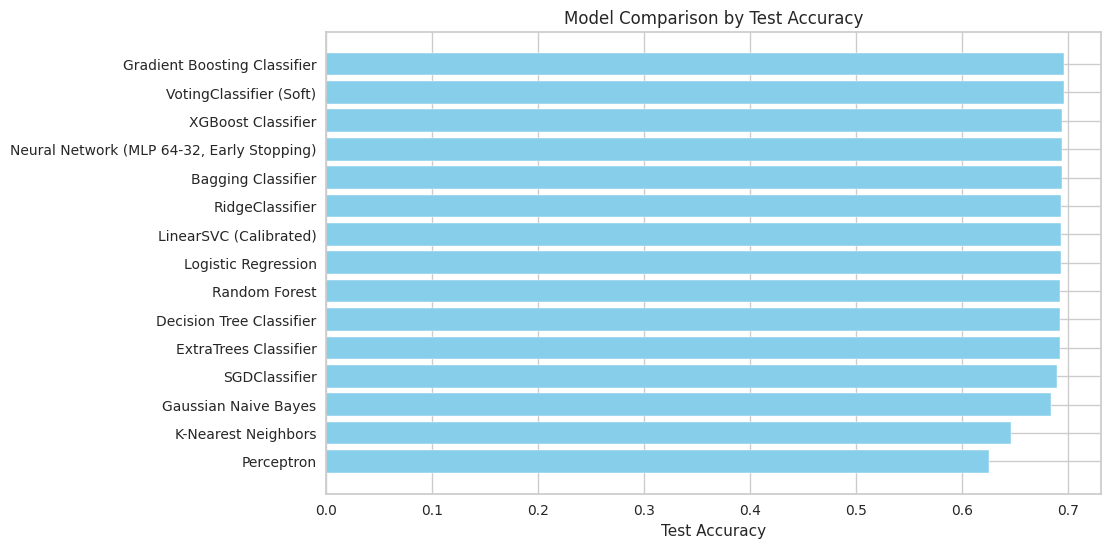

In [77]:
# Create a DataFrame from the aggregated results and sort by Test Accuracy (or AUC if desired)
results_df = pd.DataFrame(model_results_list)

# Optionally, you can sort by Test Accuracy:
results_df = results_df.sort_values(by="Test Acc", ascending=False)

print("Model Comparison Summary:")
print(results_df.to_string(index=False))

# Optionally, plot a comparison of Test Accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(results_df["Model"], results_df["Test Acc"], color='skyblue')
plt.xlabel("Test Accuracy")
plt.title("Model Comparison by Test Accuracy")
plt.gca().invert_yaxis()  # highest accuracy on top
plt.show()

## We need to realise that recall is a more important metric than accuracy/precision. It is better to have a false positive than a false negative, ie. it is better to have a higher recall than a higher accuracy. Thus, we check the recall of each model.

Logistic Regression is not fitted. Please ensure you run its training cell first.
Random Forest is not fitted. Please ensure you run its training cell first.
Gradient Boosting Classifier is not fitted. Please ensure you run its training cell first.
Precision and Recall for each model:
                            Precision  Recall
Model                                        
Gaussian Naive Bayes           0.7238  0.5498
Perceptron                     0.5862  0.7420
SGDClassifier                  0.7597  0.5136
Decision Tree Classifier       0.7178  0.5898
XGBoost Classifier             0.7185  0.5960
Bagging Classifier             0.7165  0.5977
ExtraTrees Classifier          0.7169  0.5909
RidgeClassifier                0.7348  0.5640
Neural Network (MLP 64-32)     0.7190  0.5936
VotingClassifier (Soft)        0.7180  0.6017
LinearSVC (Calibrated)         0.7320  0.5676
K-Nearest Neighbors            0.6360  0.6117


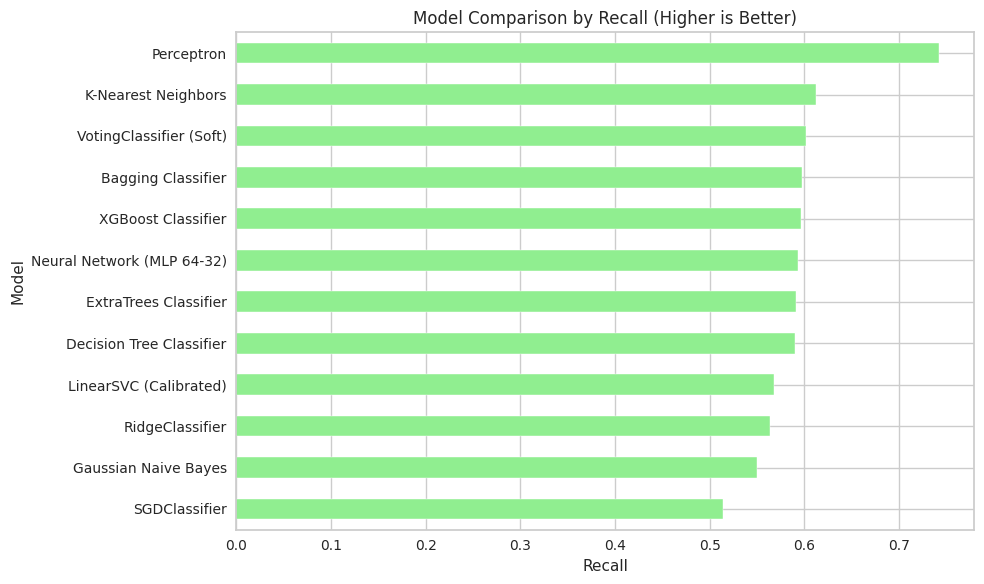

In [78]:
from sklearn.metrics import precision_score, recall_score
from sklearn.utils.validation import check_is_fitted

# Build a dictionary using the fitted model instances (do not reinitialize!)
fitted_models = {
    "Logistic Regression": model_lr,
    "Gaussian Naive Bayes": model_gnb,
    "Perceptron": model_perc,
    "SGDClassifier": model_sgd,
    "Decision Tree Classifier": model_dt,
    "Random Forest": model_rf,
    "XGBoost Classifier": model_xgb,
    "Gradient Boosting Classifier": model_gb,
    "Bagging Classifier": model_bag,
    "ExtraTrees Classifier": model_et,
    "RidgeClassifier": model_ridge,
    "Neural Network (MLP 64-32)": model_mlp,
    "VotingClassifier (Soft)": model_voting,
    "LinearSVC (Calibrated)": calibrated_linearsvc,
    "K-Nearest Neighbors": model_knn
}

# Initialize a list to store precision and recall metrics
model_precision_recall = []

# Loop over each model and ensure it is fitted; if not, print a warning (or fit it if desired)
for model_name, clf in fitted_models.items():
    try:
        check_is_fitted(clf)
    except Exception as e:
        print(f"{model_name} is not fitted. Please ensure you run its training cell first.")
        continue  # Skip this model if not fitted

    # Get predictions on the test set
    y_pred = clf.predict(X_test)
    # Calculate precision and recall
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    
    model_precision_recall.append({
        "Model": model_name,
        "Precision": prec,
        "Recall": rec
    })

# Create a DataFrame from the results and display it
df_precision_recall = pd.DataFrame(model_precision_recall).set_index("Model")
print("Precision and Recall for each model:")
print(df_precision_recall.to_string())

# Plot the recall values for each model (recall is emphasized)
plt.figure(figsize=(10, 6))
df_precision_recall["Recall"].sort_values(ascending=True).plot(kind='barh', color='lightgreen')
plt.xlabel("Recall")
plt.title("Model Comparison by Recall (Higher is Better)")
plt.tight_layout()
plt.show()

## ROC curve plots:
### This is to get an overall picture of model performance

True Positive Rate (Recall) vs. False Positive Rate
AUC = Area under this curve (ranges from 0.0 to 1.0)
1.0 = perfect classifier
0.5 = random guessing

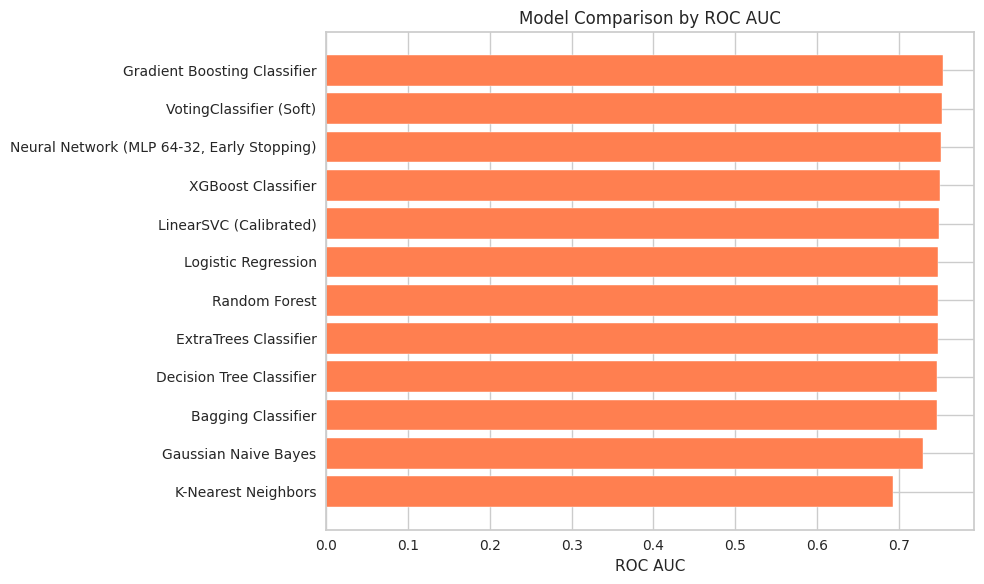

In [79]:
# Create a DataFrame from the aggregated results
results_df = pd.DataFrame(model_results_list)

# Filter out models that did not compute an AUC (i.e., AUC is None)
results_with_auc = results_df[results_df["AUC"].notnull()].copy()

# Sort the DataFrame by AUC in ascending order
results_with_auc.sort_values(by="AUC", inplace=True)

# Plot a horizontal bar chart of ROC AUC for each model
plt.figure(figsize=(10, 6))
plt.barh(results_with_auc["Model"], results_with_auc["AUC"], color='coral')
plt.xlabel("ROC AUC")
plt.title("Model Comparison by ROC AUC")
plt.tight_layout()
plt.show()

## We see that Neural Network is the best model as it has the highest recall. By checking the ROC AUC, it also has almost the same AUC compared to the model with the highest ROC AUC.

## Thus, we will be using the Neural Network for predicting cardiovascular disease. 

In [80]:
import pandas as pd
import numpy as np

# --- Assuming your VotingClassifier 'model_voting' has already been defined and trained ---
best_model = model_voting

# Define the feature set that the model was trained on (7 features)


# --- 2. Interactive Input Function with Minimal Output ---
def get_patient_input():
    """
    Prompts the user for input for each variable.
    Collects 11 features but the model uses only a subset.
    Returns a dictionary containing the patient's data.
    """
    patient = {}
    
    # BP Category Numeric
    bp_options = {
        0: "Normal", 1: "Elevated", 2: "Hypertension Stage 1", 3: "Hypertension Stage 2", -1: "Uncategorised"
    }
    while True:
        try:
            val = int(input("Enter BP Category Numeric (0=Normal, 1=Elevated, 2=Hypertension Stage 1, 3=Hypertension Stage 2, -1=Uncategorised): "))
            if val in bp_options:
                print(f"→ You selected: {bp_options[val]}\n")
                patient['BP Category Numeric'] = val
                break
            else:
                print('Invalid input')
        except ValueError:
            print("Please enter a valid integer.")
    
    # BMI Category Numeric
    bmi_options = {
        0: "Underweight", 1: "Normal weight", 2: "Overweight", 3: "Obesity"
    }
    while True:
        try:
            val = int(input("Enter BMI Category Numeric (0=Underweight, 1=Normal weight, 2=Overweight, 3=Obesity): "))
            if val in bmi_options:
                print(f"→ You selected: {bmi_options[val]}\n")
                patient['BMI Category Numeric'] = val
                break
            else:
                print('Invalid input')
        except ValueError:
            print("Please enter a valid integer.")
    
    # MAP Category Numeric
    map_options = {
        0: "Low MAP", 1: "Normal MAP", 2: "High MAP"
    }
    while True:
        try:
            val = int(input("Enter MAP Category Numeric (0=Low MAP, 1=Normal MAP, 2=High MAP): "))
            if val in map_options:
                print(f"→ You selected: {map_options[val]}\n")
                patient['MAP Category Numeric'] = val
                break
            else:
                print('Invalid input')
        except ValueError:
            print("Please enter a valid integer.")
    
    # Pulse Pressure Category Numeric
    pp_options = {
        0: "Low Pulse Pressure", 1: "Normal Pulse Pressure", 2: "High Pulse Pressure"
    }
    while True:
        try:
            val = int(input("Enter Pulse Pressure Category Numeric (0=Low, 1=Normal, 2=High): "))
            if val in pp_options:
                print(f"→ You selected: {pp_options[val]}\n")
                patient['Pulse Pressure Category Numeric'] = val
                break
            else:
                print('Invalid input')
        except ValueError:
            print("Please enter a valid integer.")
    
    # Cholesterol level
    chol_options = {
        1: "Normal", 2: "Above Normal", 3: "Well Above Normal"
    }
    while True:
        try:
            val = int(input("Enter Cholesterol level (1=Normal, 2=Above Normal, 3=Well Above Normal): "))
            if val in chol_options:
                print(f"→ You selected: {chol_options[val]}\n")
                patient['cholesterol (1- normal, 2 - above normal, 3- well above normal)'] = val
                break
            else:
                print('Invalid input')
        except ValueError:
            print("Please enter a valid integer.")
    
    # Glucose level (gluc)
    gluc_options = chol_options  # same options as cholesterol
    while True:
        try:
            val = int(input("Enter Glucose level (1=Normal, 2=Above Normal, 3=Well Above Normal): "))
            if val in gluc_options:
                print(f"→ You selected: {gluc_options[val]}\n")
                patient['gluc (1- normal, 2 - above normal, 3- well above normal)'] = val
                break
            else:
                print('Invalid input')
        except ValueError:
            print("Please enter a valid integer.")
    
    # Age (in years) bracket numeric
    age_options = {
        0: "40-50", 1: "50-60", 2: "60-70", 3: "70+"
    }
    while True:
        try:
            val = int(input("Enter Age Bracket Numeric (0=40-50, 1=50-60, 2=60-70, 3=70+): "))
            if val in age_options:
                print(f"→ You selected: {age_options[val]}\n")
                patient['age (in years) bracket numeric'] = val
                break
            else:
                print('Invalid input')
        except ValueError:
            print("Please enter a valid integer.")
    
    # Additional Features (if collected; these won't be used for prediction)
    # Smoking status
    smoke_options = {0: "Does not smoke", 1: "Smokes"}
    while True:
        try:
            val = int(input("Enter Smoking Status (0=Does not smoke, 1=Smokes): "))
            if val in smoke_options:
                print(f"→ You selected: {smoke_options[val]}\n")
                patient['smoke (0 - does not smoke, 1 - smokes)'] = val
                break
            else:
                print('Invalid input')
        except ValueError:
            print("Please enter a valid integer.")
    
    # Alcohol consumption
    alco_options = {0: "Does not consume alcohol", 1: "Consumes alcohol"}
    while True:
        try:
            val = int(input("Enter Alcohol Consumption (0=Does not consume, 1=Consumes): "))
            if val in alco_options:
                print(f"→ You selected: {alco_options[val]}\n")
                patient['alco (0 - does not alcohol, 1 - consumes alcohol)'] = val
                break
            else:
                print('Invalid input')
        except ValueError:
            print("Please enter a valid integer.")
    
    # Physical activity status
    active_options = {0: "Does not exercise", 1: "Exercises"}
    while True:
        try:
            val = int(input("Enter Physical Activity (0=Does not exercise, 1=Exercises): "))
            if val in active_options:
                print(f"→ You selected: {active_options[val]}\n")
                patient['active (0 - does not exercise, 1 - exercises)'] = val
                break
            else:
                print('Invalid input')
        except ValueError:
            print("Please enter a valid integer.")
    
    # Gender
    gender_options = {0: "Woman", 1: "Man"}
    while True:
        try:
            val = int(input("Enter Gender (0=Woman, 1=Man): "))
            if val in gender_options:
                print(f"→ You selected: {gender_options[val]}\n")
                patient['gender (0 for Women, 1 for Men)'] = val
                break
            else:
                print('Invalid input')
        except ValueError:
            print("Please enter a valid integer.")
    
    return patient

# --- 3. Prediction Function ---
def predict_cardio(model, input_data, features):
    """
    Converts input_data (dictionary) to a DataFrame using only the specified features,
    then returns the predicted probability for cardio = 1.
    """
    # Create DataFrame from input data
    input_df = pd.DataFrame([input_data])
    # Filter DataFrame to only include features used for training
    input_df = input_df[features]
    prob = model.predict_proba(input_df)[:, 1][0]
    return prob

# --- 4. Collect Patient Input and Predict Risk ---
patient_input = get_patient_input()
predicted_probability = predict_cardio(best_model, patient_input, all_features)
print(f"\nPredicted probability of cardiovascular disease: {predicted_probability:.2%}")

KeyboardInterrupt: Interrupted by user

## Recommended actions based on probabilty of cardiovascular disease

In [126]:
import pandas as pd

# Define the feature set used during training (7 features including age)
all_features = [
    'BP Category Numeric',
    'BMI Category Numeric',
    'MAP Category Numeric',
    'Pulse Pressure Category Numeric',
    'cholesterol (1- normal, 2 - above normal, 3- well above normal)',
    'gluc (1- normal, 2 - above normal, 3- well above normal)',
    'age (in years) bracket numeric'
]

# Define the healthy (normal) values for the ordinal (controllable) features
healthy_values = {
    'BP Category Numeric': 0,                    # Normal
    'BMI Category Numeric': 1,                   # Normal weight
    'MAP Category Numeric': 1,                   # Normal MAP
    'Pulse Pressure Category Numeric': 1,        # Normal Pulse Pressure
    'cholesterol (1- normal, 2 - above normal, 3- well above normal)': 1,  # Normal cholesterol
    'gluc (1- normal, 2 - above normal, 3- well above normal)': 1         # Normal gluc
}

# Define the healthy targets for the nominal features:
# For smoke and alco, healthy means 0
# For active, healthy means 1 (i.e., exercising)
nominal_healthy = {
    'smoke (0 - does not smoke, 1 - smokes)': 0,
    'alco (0 - does not alcohol, 1 - consumes alcohol)': 0,
    'active (0 - does not exercise, 1 - exercises)': 1
}

def recommend_changes(model, patient_data):
    """
    Checks how modifying each controllable risk factor affects predicted CVD probability.
    
    model: a trained sklearn model (e.g., VotingClassifier or MLPClassifier) with predict_proba()
    patient_data: dict containing the patient's feature values.
                  Must include:
                      - the 6 ordinal features plus age (as in all_features)
                      - may include nominal features:
                          'smoke (0 - does not smoke, 1 - smokes)',
                          'alco (0 - does not alcohol, 1 - consumes alcohol)',
                          'active (0 - does not exercise, 1 - exercises)'
                  
    Returns a DataFrame with recommendations. For the ordinal features, the function simulates a one-step change.
    If no ordinal feature changes are recommended (i.e., all are at healthy levels), then nominal features are checked.
    For nominal features, if the current value differs from the healthy target, a recommendation is provided.
    """
    
    # Prepare the baseline DataFrame (using only the expected training features)
    baseline_df = pd.DataFrame([patient_data])
    baseline_df = baseline_df[all_features]
    baseline_prob = model.predict_proba(baseline_df)[:, 1][0]
    
    results = []
    
    # Process ordinal features first (these are controlled by healthy_values)
    controllable_features = list(healthy_values.keys())
    
    for feature in controllable_features:
        old_val = patient_data[feature]
        healthy_val = healthy_values[feature]
        new_data = patient_data.copy()
        
        # If already healthy, skip this feature.
        if old_val == healthy_val:
            continue
        
        # If above healthy, recommend lowering (simulate one-step reduction)
        if old_val > healthy_val:
            new_val = old_val - 1
            new_data[feature] = new_val
            new_df = pd.DataFrame([new_data])[all_features]
            new_prob = model.predict_proba(new_df)[:, 1][0]
            improvement = baseline_prob - new_prob
            results.append({
                'Feature': feature,
                'Old Value': old_val,
                'New Value': new_val,
                'Recommendation': 'Lower',
                'Baseline Prob': baseline_prob,
                'New Prob': new_prob,
                'Risk Reduction': improvement
            })
        # If below healthy, recommend increasing (simulate one-step increase)
        elif old_val < healthy_val:
            new_val = old_val + 1
            new_data[feature] = new_val
            new_df = pd.DataFrame([new_data])[all_features]
            new_prob = model.predict_proba(new_df)[:, 1][0]
            improvement = baseline_prob - new_prob
            results.append({
                'Feature': feature,
                'Old Value': old_val,
                'New Value': new_val,
                'Recommendation': 'Increase',
                'Baseline Prob': baseline_prob,
                'New Prob': new_prob,
                'Risk Reduction': improvement
            })
    
    # Create DataFrame from ordinal recommendations
    rec_df = pd.DataFrame(results)
    
    # If no ordinal changes recommended (i.e., rec_df is empty), check nominal features.
    if rec_df.empty:
        new_recs = []
        nominal_features = list(nominal_healthy.keys())
        for feature in nominal_features:
            if feature in patient_data:
                current_val = patient_data[feature]
                target_val = nominal_healthy[feature]
                if current_val != target_val:
                    new_recs.append({
                        'Feature': feature,
                        'Old Value': current_val,
                        'New Value': target_val,
                        'Recommendation': f'Set to {target_val}',
                        'Baseline Prob': baseline_prob,
                        'New Prob': baseline_prob,
                        'Risk Reduction': 0
                    })
        rec_df = pd.DataFrame(new_recs)
    
    if not rec_df.empty:
        rec_df.sort_values(by='Risk Reduction', ascending=False, inplace=True)
    return rec_df


# Example usage:
# Assume patient_input is a dictionary from your interactive input function,
# and best_model is your trained VotingClassifier (or another classifier).

recommendation_df = recommend_changes(best_model, patient_input)

if recommendation_df.empty:
    print("No recommendations needed—the patient is at optimal levels on all measured factors.")
else:
    print("Recommended Changes to Reduce CVD Risk:")
    print(recommendation_df[['Feature', 'Old Value', 'New Value', 'Recommendation', 'Risk Reduction']].head(10))
    best_change = recommendation_df.iloc[0]
    print(f"\nBest Change Suggestion: For '{best_change['Feature']}', "
          f"{best_change['Recommendation']} from {best_change['Old Value']} to {best_change['New Value']} "
          f"reduces risk by {best_change['Risk Reduction']:.3f}")


Recommended Changes to Reduce CVD Risk:
                                             Feature  Old Value  New Value  \
0             smoke (0 - does not smoke, 1 - smokes)          1          0   
1  alco (0 - does not alcohol, 1 - consumes alcohol)          1          0   

  Recommendation  Risk Reduction  
0       Set to 0               0  
1       Set to 0               0  

Best Change Suggestion: For 'smoke (0 - does not smoke, 1 - smokes)', Set to 0 from 1 to 0 reduces risk by 0.000


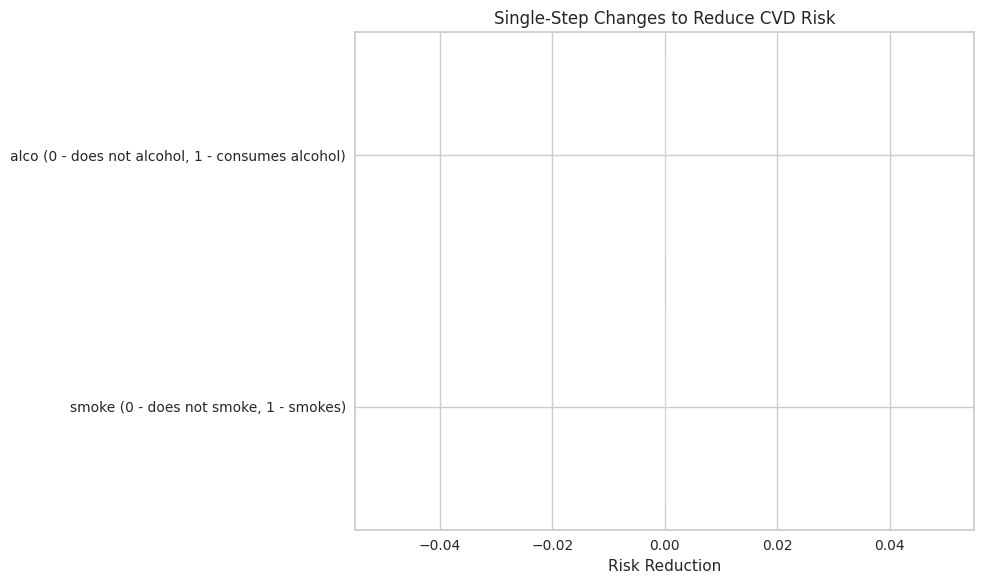

In [128]:
def visualize_recommendations(recommendation_df, top_n=10):
    """
    Visualizes the top 'top_n' recommended changes by Risk Reduction from recommendation_df
    as a horizontal bar chart.
    """
    # If empty, no improvements found
    if recommendation_df.empty:
        print("No single-step improvements found (patient might already be at best levels).")
        return
    
    # Take the top N changes and sort ascending so largest bar is at the bottom
    rec_plot = recommendation_df.head(top_n).sort_values("Risk Reduction", ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(rec_plot["Feature"], rec_plot["Risk Reduction"], color='skyblue')
    plt.xlabel("Risk Reduction")
    plt.title("Single-Step Changes to Reduce CVD Risk")
    plt.tight_layout()
    plt.show()

visualize_recommendations(recommendation_df)


## Limitations and Unexpected Results
### 1. The model's suggestions are purely correlational. It uses a Naive Single-Step approach: only try a one-level improvement in each feature, ignoring the possibility of multi-step improvements (e.g., from Overweight → Normal weight if BMI Category is 2 → 1 → 0) or combining multiple changes.

### 2. The model's recommendations are constrained by whatever patterns happen to appear in the dataset. This dataset show no strong association between smoking, activity, or alcohol use and cardiovascular disease outcomes, thus, the model will not prioritize changes in those variables, even though clinically we know they are significant risk factors. Essentially, the model can only learn from and make suggestions consistent with—the data it was given, which may not always reflect broader real-world evidence.